# Module 4 Assignment

# Tasks
## Recommend 5 players to a scout for drafting
- Player is a hybrid wing G/F
- Can guard multiple positions
- Provide names with justification
- Characteristics
    - length
    - ability to change directions

# Imports

In [2430]:
import re
import pandas as pd
import numpy as np
import scipy
from scipy import stats
import scipy.stats as stats
from statsmodels.stats.multitest import multipletests
from pathlib import Path
import matplotlib.pyplot as plt
import streamlit as st
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = 'notebook'
import plotly.offline as pyo
pyo.init_notebook_mode(connected=True)
import seaborn as sns
sns.set_theme(style="white")

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import TransformedTargetRegressor, make_column_transformer, ColumnTransformer, make_column_selector
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_score, adjusted_rand_score,r2_score, mean_squared_error, accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, roc_curve, precision_recall_curve, auc, confusion_matrix
from sklearn.model_selection import RepeatedKFold, cross_val_score

from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, plot_tree, DecisionTreeClassifier

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from xgboost import XGBRegressor, XGBRFClassifier

ModuleNotFoundError: No module named 'xgboost'

In [2431]:
project_path = Path.cwd()
print(f'project_path: {project_path}')
print('')
project_data_sources_path = Path.cwd() / 'data' / 'sources'
print(f'project_data_sources_path: {project_data_sources_path}')
print('')
project_data_exports_path = Path.cwd() / 'data' / 'exports'
print(f'project_data_exports_path: {project_data_exports_path}')

project_path: /Users/chrisizenour/Library/CloudStorage/Dropbox/msu_grad_school/classes/petway_ie_6990_553_202410/projects/msu_petway/module_4

project_data_sources_path: /Users/chrisizenour/Library/CloudStorage/Dropbox/msu_grad_school/classes/petway_ie_6990_553_202410/projects/msu_petway/module_4/data/sources

project_data_exports_path: /Users/chrisizenour/Library/CloudStorage/Dropbox/msu_grad_school/classes/petway_ie_6990_553_202410/projects/msu_petway/module_4/data/exports


# User Defined Functions

## Dataset Import and Wrangling

In [2432]:
def load_dataset():
    df = pd.read_excel(
        project_data_sources_path / 'Module4_Data-1.xlsx',
        sheet_name='Combine - 2018 Update',
        header=1
    )
    # df = df.iloc[:-2]
    print(f'Shape of dataframe: {df.shape[0]} rows, {df.shape[1]} columns')
    return df

In [2433]:
def clean_df_columns(df):
    df.columns = df.columns.str.lower()
    df.columns = df.columns.str.strip()
    # df.columns = df.columns.str.replace('%', 'pct', regex=False)
    # df.columns = df.columns.str.replace('|', '_', regex=False)
    # df.columns = df.columns.str.replace('.', '')
    # df.columns = df.columns.str.replace('-', '')
    df.columns = df.columns.str.replace(' ', '_')
    df['weight_(lbs)'] = df['weight_(lbs)'].replace('-', np.nan).astype(float)
    df['lane_agility_time_(s)'] = df['lane_agility_time_(s)'].replace('-', np.nan).astype(float)
    df['max_bench_press'] = df['max_bench_press'].replace('-', np.nan).astype(float)
    df['year'] = df['year'].astype(int)
    # df['date'] = pd.to_datetime(df['date'], errors='coerce')
    # df['date_str'] = df['date'].dt.strftime('%Y-%m-%d')
    # df = df.sort_values(by=['date', 'name', 'time'], ascending=[True, True, True])
    df['pos'] = df['pos'].fillna('Unassigned')
    return df

In [2434]:
def create_metric_columns(df):
    df['hand_length_(m)'] = df['hand_length_(inches)'] * 0.0254
    df['hand_width_(m)'] = df['hand_width_(inches)'] * 0.0254
    df['height_w/o_shoes_(m)'] = df['height_w/o_shoes_(inches)'] * 0.0254
    df['height_w/_shoes_(m)'] = df['height_w/_shoes_(inches)'] * 0.0254
    df['standing_reach_(m)'] = df['standing_reach_(inches)'] * 0.0254
    df['wingspan_(m)'] = df['wingspan_(inches)'] * 0.0254
    df['cmj_(m)'] = df['cmj_(inches)'] * 0.0254
    df['max_vjump_(m)'] = df['max_vjump_(inches)'] * 0.0254
    df['weight_(kg)'] = df['weight_(lbs)'] * 0.453592
    return df

In [2435]:
def create_metric_df(df):
    df = df.iloc[:, np.r_[0:4, 16:26, 11:14]]
    return df

In [2436]:
def create_imperial_df(df):
    df = df.iloc[:, np.r_[0:17]]
    return df

In [2437]:
def derived_features(df):
    df['three_quarter_velo_(m/s)'] = 22.86 / df['three_quarter_sprint_(s)']
    df['three_quarter_mean_accel_(m/s2)'] = (2 * 22.86) / df['three_quarter_sprint_(s)']**2
    df['three_quarter_force_(N)'] = df['weight_(kg)'] * df['three_quarter_mean_accel_(m/s2)']
    df['cmj_potential_energy_(J)'] = df['weight_(kg)'] * 9.81 * df['cmj_(m)']
    df['cmj_estimated_takeoff_velo_(m/s)'] = np.sqrt(2 * 9.81 * df['cmj_(m)'])
    df['max_vjump_potential_energy_(J)'] = df['weight_(kg)'] * 9.81 * df['max_vjump_(m)']
    df['max_vjump_takeoff_velo_(m/s)'] = np.sqrt(2 * 9.81 * df['max_vjump_(m)'])
    df['standing_reach_height_w/o_shoes_ratio'] = df['standing_reach_(m)'] / df['height_w/o_shoes_(m)']
    df['wingspan_height_w/o_shoes_ratio'] = df['wingspan_(m)'] / df['height_w/o_shoes_(m)']
    
    return df

## Corr & Pval Analysis

In [2438]:
def correlation_matrix(df):
    """create correlation matrix dataframe"""
    df_corr_mat = df.corr()
    return df_corr_mat

In [2439]:
def correlation_series(df):
    """create a dataframe which has unique feature pairs and their associated correlation coefficient"""
    upper_corr_mat = df.where(np.triu(np.ones(df.shape), k=1).astype(bool))
    unique_corr_pairs = upper_corr_mat.unstack().dropna()
    df_corr_series = unique_corr_pairs.sort_values(ascending=False)
    df_corr_series = df_corr_series.reset_index()
    df_corr_series = df_corr_series.rename(columns={
        'level_0': 'feature_1',
        'level_1': 'feature_2',
        0: 'correlation_coefficient'
    })
    return df_corr_series

In [2440]:
def correlation_plot(df, title='Correlation Heatmap'):
    """create a correlation heatmap plot using seaborn"""
    mask = np.triu(np.ones_like(df, dtype=bool))
    f, ax = plt.subplots(1, 1, figsize=(11,9))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    sns.heatmap(df,
                mask=mask,
                cmap=cmap,
                vmax=1,
                vmin=-1,
                center=0,
                annot=False,
                square=True,
                linewidths=0.5,
                cbar_kws={'shrink': 0.5})
    ax.set_title(title)
    ax.set_xlabel('Variables')
    ax.set_ylabel('Variables')

    plt.tight_layout() 
    return f

In [2441]:
def p_val_matrix(df):
    """create p-value matrix dataframe"""
    df_p_val_mat = df.corr(method=lambda x, y: stats.pearsonr(x, y)[1]) - np.eye(len(df.columns))
    return df_p_val_mat

In [2442]:
def p_val_series(df):
    """create a dataframe which has unique feature pairs and their associated level of statistical significance"""
    upper_corr_mat = df.where(np.triu(np.ones(df.shape), k=1).astype(bool))
    unique_p_val_pairs = upper_corr_mat.unstack().dropna()
    df_p_val_series = unique_p_val_pairs.sort_values()
    df_p_val_series = df_p_val_series.reset_index()
    df_p_val_series = df_p_val_series.rename(columns={
        'level_0': 'feature_1',
        'level_1': 'feature_2',
        0: 'p_value'
    })
    return df_p_val_series

In [2443]:
def p_val_plot(df, title="P-value Heatmap (Green: Significant, White: Not Significant"):
    """create a level of statistical significance heatmap plot using seaborn"""
    alpha = 0.05
    mask = np.triu(np.ones_like(df, dtype=bool))
    f, ax = plt.subplots(1, 1, figsize=(11,9))
    green = sns.light_palette('seagreen', reverse=True, as_cmap=True)
    green.set_over('white')
    # cmap = sns.diverging_palette(230, 20, as_cmap=True)
    sns.heatmap(df,
                mask=mask,
                cmap=green,
                # cmap=cmap,
                vmax=alpha,
                vmin=0,
                # center=0,
                annot=False,
                square=True,
                linewidths=0.5,
                cbar_kws={'shrink': 0.5})
    ax.set_title(title)
    ax.set_xlabel('Variables')
    ax.set_ylabel('Variables')
    plt.tight_layout()
    return f

## Clustering

In [2444]:
def inertia_scores(df):
    inertias_list = []
    for k in range(1, 16):
        pipe = Pipeline([
            ('scaler', StandardScaler()),
            ('pca', PCA(random_state=0)),
            ('clusterer', KMeans(n_clusters=k, n_init = 10, random_state=0))
        ]).fit(df)
        inertias_list.append(pipe.named_steps['clusterer'].inertia_)
    return inertias_list

In [2445]:
def elbow_plot(inertias):
    sns.set_theme(style='white')
    fig, ax = plt.subplots(figsize=(10, 6))  # Create a figure and a set of subplots
    sns.lineplot(x=range(len(inertias)), y=inertias, marker='o', linestyle='-', ax=ax)
    ax.set_title('Elbow Plot')
    ax.set_xlabel('K')
    ax.set_ylabel('Inertia')
    plt.show()
    return fig  # Return the figure object for further manipulation if needed

In [2446]:
def silhouette_scores(df):
    """calculate and create a dataframe containing the silhouette score for each k value"""
    silhouette_score_list = []
    for k in range(2, 16):
        pipe = Pipeline(steps=[
            ('scaler', StandardScaler()),
            ('pca', PCA(random_state=0)),
            ('clusterer', KMeans(n_clusters=k, random_state=0))]).fit(df)
        cluster_labels = pipe.named_steps['clusterer'].labels_
        silhouette_avg = silhouette_score(df, cluster_labels)
        silhouette_score_list.append(silhouette_avg)
    silhouette_df = pd.DataFrame(silhouette_score_list, columns=['silhouette_score'])
    silhouette_df['k'] = [k for k in range(2, 16)]
    return silhouette_df


In [2447]:
def silhouette_score_plot(df):
    sns.set_theme(style='white')  # Set the theme of the plot
    fig, ax = plt.subplots(figsize=(10, 6))  # Create a figure and an axes object

    # Create the line plot
    sns.lineplot(data=df, x='k', y='silhouette_score', ax=ax, marker='o', linestyle='-')

    ax.set_title('Average Cluster Silhouette Score')  # Set the title
    ax.set_xlabel('Number of Clusters (K)')  # Set the x-axis label
    ax.set_ylabel('Silhouette Score')  # Set the y-axis label

    return fig  # Return the figure object

In [2448]:
def pca_cumsum_exp_var_ratios(df):
    """calculate and create a dataframe containing each feature's explained variance ratio, the cumulative sum of explained variance ratios"""
    pca_feature_exp_var = []
    pca_feature_cumsum_exp_var = []
    pca_qty = []
    pca = Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('pca', PCA(random_state=0))]).fit(df)
    pca_feature_exp_var.append(pca.named_steps['pca'].explained_variance_ratio_)
    pca_feature_cumsum_exp_var.append(np.cumsum(pca.named_steps['pca'].explained_variance_ratio_))
    pca_qty.append(list(range(len(df.columns))))
    pca_df = pd.DataFrame({'principal_component_qty': pca_qty,
                           'feature_explained_variance': pca_feature_exp_var,
                           'feature_cumsum_explained_variance': pca_feature_cumsum_exp_var,
                           })
    pca_df = pca_df.explode(['principal_component_qty',
                             'feature_explained_variance',
                             'feature_cumsum_explained_variance',
                             ])
    pca_df = pca_df.reset_index(drop=True)
    return pca_df


In [2449]:
def scree_plot(df):
    sns.set_theme(style='white')  # Set the theme of the plot
    fig, ax = plt.subplots(figsize=(10, 6))  # Create a figure and an axes object

    # Create the line plot
    sns.lineplot(data=df, x=df.index, y='feature_cumsum_explained_variance', ax=ax, marker='o', linestyle='-')

    ax.set_title('Scree Plot, Cumulative Sum of PCA Explained Variance Ratios')  # Set the title
    ax.set_xlabel('Number of Principal Components')  # Set the x-axis label
    ax.set_ylabel('Cumulative Sum Explained Variance Ratios')  # Set the y-axis label

    return fig  # Return the figure object

In [2450]:
def pca_matrix_heatmap(df):
    pca_pipe = Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('pca', PCA(random_state=0))]).fit(df)
    pca_pipe.named_steps['pca'].components_**2

    fig, ax = plt.subplots(1, 1, figsize=(10, 6))

    sns.heatmap(
        pca_pipe.named_steps['pca'].components_**2,
        yticklabels=['PCA'+str(x) for x in range(1, pca_pipe.named_steps['pca'].n_components_+1)],
        xticklabels=list(df.columns),
        annot=True,
        fmt='.2f',
        square=True,
        linewidth=0.05,
        linecolor='white',
        cbar_kws={'orientation': 'vertical'},
        vmin=0,
        vmax=1,
        ax=ax,
    )
    return fig


In [2451]:
def plot_gmm_criteria(df, max_components):
    """
    Plots BIC and AIC for Gaussian Mixture Models to help determine the optimal number of components.
    Returns the figure object containing the plot.
    
    Parameters:
        df (DataFrame): The input data frame containing the features for clustering.
        max_components (int): The maximum number of components to consider.
    """
    # Scale the data
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(df)

    # Calculate BIC and AIC for different numbers of components
    n_components = np.arange(1, max_components + 1)
    bics = []
    aics = []
    for n in n_components:
        gmm = GaussianMixture(n_components=n, random_state=0).fit(data_scaled)
        bics.append(gmm.bic(data_scaled))
        aics.append(gmm.aic(data_scaled))

    # Creating a DataFrame for plotting
    criteria_df = pd.DataFrame({
        'Number of Components': n_components,
        'BIC': bics,
        'AIC': aics
    })
    criteria_df = pd.melt(criteria_df, id_vars='Number of Components', value_vars=['BIC', 'AIC'],
                           var_name='Criterion', value_name='Score')

    # Plotting using Seaborn
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.lineplot(data=criteria_df, x='Number of Components', y='Score', hue='Criterion', marker='o', ax=ax)
    ax.set_title('BIC and AIC vs. Number of Components')
    ax.set_xlabel('Number of Components')
    ax.set_ylabel('Criterion Score')
    
    return fig

In [2452]:
def pca_cluster_df(df, components, clusters):
    """calculate and create a dataframe containing the first two principal components and the associated cluster label"""
    pipe = Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('pca', PCA(random_state=0, n_components=components)),
        ('clusterer', KMeans(random_state=0, n_clusters=clusters))])
    pipe.fit(df)
    labels = pipe.named_steps['clusterer'].labels_
    labels = labels.astype(str)
    pc_1 = pipe[0:2].fit_transform(df)[:, 0]
    pc_2 = pipe[0:2].fit_transform(df)[:, 1]
    centroids_x = pipe.named_steps['clusterer'].cluster_centers_[:, 0]
    centroids_y = pipe.named_steps['clusterer'].cluster_centers_[:, 1]
    cluster_dict = {
        'pc_1': pc_1,
        'pc_2': pc_2,
        'label': labels
    }
    cluster_df = pd.DataFrame(cluster_dict)
    return cluster_df, centroids_x, centroids_y


In [2453]:
def pca_gmm_df(df, components, clusters):
    """Calculate and create a dataframe containing the first two principal components and the associated cluster label using Gaussian Mixture Modeling."""
    pipe = Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=components, random_state=0))
    ])
    # Fit only scaler and PCA
    pipe.fit(df)
    
    # Apply transformations
    transformed_data = pipe.transform(df)
    
    # Fit GMM to the PCA-transformed data
    gmm = GaussianMixture(n_components=clusters, random_state=0)
    gmm.fit(transformed_data)
    
    # Get posterior probabilities and Predict clusters using the PCA-transformed data
    posterior_probs = gmm.predict_proba(transformed_data)
    labels = gmm.predict(transformed_data)
    labels = labels.astype(str)
    
    pc_1 = transformed_data[:, 0]
    pc_2 = transformed_data[:, 1]
    
    # Obtain means (centers) from GMM and transform using PCA only, if needed
    # Since means are in PCA space already, no need to transform them again
    centroids_x = gmm.means_[:, 0]
    centroids_y = gmm.means_[:, 1]

    cluster_dict = {
        'pc_1': pc_1,
        'pc_2': pc_2,
        'label': labels
    }
    
    # add column for each cluster's probability
    for i in range(clusters):
        cluster_dict[f'cluster_{i}_probability'] = posterior_probs[:, i]
    
    cluster_df = pd.DataFrame(cluster_dict)
    
    return cluster_df, centroids_x, centroids_y

In [2454]:
def merge_cluster_df(df1, df2):
    """create a merged dataframe that combines the cleaned dataframe and the pca_cluster dataframe so each observation has its first two principal components and cluster label"""
    df_labeled = pd.concat([df1, df2], axis=1)
    df_labeled = df_labeled.sort_values(by=['label'])
    df_labeled = df_labeled.reset_index(drop=True)
    return df_labeled

In [2455]:
def pc12_cluster_plot(df, df_2, centroids_x, centroids_y):
    # Set the theme of the plot
    sns.set_theme(style='white')

    # Create a figure and an axes object
    fig, ax = plt.subplots(figsize=(10, 6))

    # Create the scatter plot for the clusters
    sns.scatterplot(data=df, x='pc_1', y='pc_2', hue='label', style='label', palette='deep', ax=ax, s=50, alpha=0.5)

    # Plot the centroids
    ax.scatter(centroids_x, centroids_y, color='black', s=100, marker='*', label='centroids')

    # Set the title and labels with explained variance
    title = f"Cluster Plot Projection of 2 Principal Components, Explained Variance: {round(df_2['feature_explained_variance'][0] + df_2['feature_explained_variance'][1], 3)}"
    ax.set_title(title)
    ax.set_xlabel(f"PC 1, Explained Variance: {round(df_2['feature_explained_variance'][0], 3)}")
    ax.set_ylabel(f"PC 2, Explained Variance: {round(df_2['feature_explained_variance'][1], 3)}")

    # Add legend
    ax.legend()

    # Return the figure object
    return fig

In [2456]:
def pc12_gmm_cluster_plot(df, df_2, centroids_x, centroids_y):
    # Set the theme of the plot
    sns.set_theme(style='white')

    # Create a figure and an axes object
    fig, ax = plt.subplots(figsize=(10, 6))

    # Create the scatter plot for the clusters
    sns.scatterplot(data=df, x='pc_1', y='pc_2', hue='label', style='label', palette='deep', ax=ax, s=50, alpha=0.5)

    # Plot the centroids
    ax.scatter(centroids_x, centroids_y, color='black', s=100, marker='*', label='Centroids')

    # Set the title and labels with explained variance
    title = f"Cluster Plot Projection of 2 Principal Components, Explained Variance: {round(df_2['feature_explained_variance'][0] + df_2['feature_explained_variance'][1], 3)}"
    ax.set_title(title)
    ax.set_xlabel(f"PC 1, Explained Variance: {round(df_2['feature_explained_variance'][0], 3)}")
    ax.set_ylabel(f"PC 2, Explained Variance: {round(df_2['feature_explained_variance'][1], 3)}")

    # Add legend to distinguish the centroids and clusters
    ax.legend(title='Cluster & Centroids')

    # Return the figure object
    return fig

# Dataset Imports

In [2457]:
df = load_dataset()
df = clean_df_columns(df)
df = create_metric_columns(df)
# df = rearrange_cols(df)
# df = create_zscore_cols(df)
# df = drop_subsequent_jump_observations(df)
# df, outliers_df = drop_2zscore_outliers(df)
# df = columns_to_keep(df)
df

Shape of dataframe: 1289 rows, 17 columns


/var/folders/kk/54xn9lv90wq5vmw11pj1svvr0000gn/T/ipykernel_15366/4156109044.py:9: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

/var/folders/kk/54xn9lv90wq5vmw11pj1svvr0000gn/T/ipykernel_15366/4156109044.py:10: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

/var/folders/kk/54xn9lv90wq5vmw11pj1svvr0000gn/T/ipykernel_15366/4156109044.py:11: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in t

player  year    pos  body_fat  hand_length_(inches)  \
0       Cory Hightower  2000  SG-SF       NaN                   NaN   
1     Harold Arceneaux  2000  SG-SF       NaN                   NaN   
2       Jamal Crawford  2000  PG-SG       NaN                   NaN   
3         Jaquay Walls  2000     PG       NaN                   NaN   
4        Jimmie Hunter  2000  SG-PG       NaN                   NaN   
...                ...   ...    ...       ...                   ...   
1284     PJ Washington  2018     PF      6.85                  9.00   
1285      Austin Wiley  2018      C      5.00                  9.75   
1286       Kris Wilkes  2018     SF      5.15                  8.75   
1287  Kenrich Williams  2018     SF      5.95                  8.50   
1288        Trae Young  2018     PG      5.35                  8.00   

      hand_width_(inches)  height_w/o_shoes_(inches)  \
0                     NaN                      77.50   
1                     NaN                      76.50   
2                     NaN                      76.50   
3                     NaN                      73.25   
4                     NaN                      75.00   
...                   ...                        ...   
1284                10.25                      78.50   
1285                10.25                      80.25   
1286                 9.25                      78.50   
1287                 9.75                      78.00   
1288                 9.25                      72.50   

      height_w/_shoes_(inches)  standing_reach_(inches)  weight_(lbs)  ...  \
0                          NaN                    101.5         183.0  ...   
1                          NaN                    103.0         219.0  ...   
2                          NaN                    102.5         175.0  ...   
3                          NaN                     96.5         165.5  ...   
4                          NaN                    100.0         170.0  ...   
...                        ...                      ...           ...  ...   
1284                     80.00                    107.0         223.0  ...   
1285                     82.00                    111.0         249.4  ...   
1286                     79.50                    103.5         205.0  ...   
1287                     79.50                    103.5         200.4  ...   
1288                     73.75                     95.5         177.8  ...   

      max_bench_press  hand_length_(m)  hand_width_(m)  height_w/o_shoes_(m)  \
0                 0.0              NaN             NaN               1.96850   
1                 0.0              NaN             NaN               1.94310   
2                 0.0              NaN             NaN               1.94310   
3                 0.0              NaN             NaN               1.86055   
4                 0.0              NaN             NaN               1.90500   
...               ...              ...             ...                   ...   
1284              NaN          0.22860         0.26035               1.99390   
1285              NaN          0.24765         0.26035               2.03835   
1286              NaN          0.22225         0.23495               1.99390   
1287              NaN          0.21590         0.24765               1.98120   
1288              NaN          0.20320         0.23495               1.84150   

      height_w/_shoes_(m)  standing_reach_(m)  wingspan_(m)  cmj_(m)  \
0                     NaN              2.5781       2.10820   0.7493   
1                     NaN              2.6162       2.04470      NaN   
2                     NaN              2.6035       2.08280      NaN   
3                     NaN              2.4511       1.89230   0.7239   
4                     NaN              2.5400       2.03200   0.7366   
...                   ...                 ...           ...      ...   
1284              2.03200              2.7178       2.19710   0.6858   
1285            

In [2458]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1289 entries, 0 to 1288
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   player                     1289 non-null   object 
 1   year                       1289 non-null   int64  
 2   pos                        1289 non-null   object 
 3   body_fat                   1052 non-null   float64
 4   hand_length_(inches)       547 non-null    float64
 5   hand_width_(inches)        547 non-null    float64
 6   height_w/o_shoes_(inches)  1224 non-null   float64
 7   height_w/_shoes_(inches)   921 non-null    float64
 8   standing_reach_(inches)    1188 non-null   float64
 9   weight_(lbs)               1282 non-null   float64
 10  wingspan_(inches)          1226 non-null   float64
 11  lane_agility_time_(s)      1146 non-null   float64
 12  shuttle_run_(s)            307 non-null    float64
 13  three_quarter_sprint_(s)   1146 non-null   float

# Final Useable Datasets

In [2459]:
df.to_csv(f'{project_data_exports_path}/df.csv')
df

player  year    pos  body_fat  hand_length_(inches)  \
0       Cory Hightower  2000  SG-SF       NaN                   NaN   
1     Harold Arceneaux  2000  SG-SF       NaN                   NaN   
2       Jamal Crawford  2000  PG-SG       NaN                   NaN   
3         Jaquay Walls  2000     PG       NaN                   NaN   
4        Jimmie Hunter  2000  SG-PG       NaN                   NaN   
...                ...   ...    ...       ...                   ...   
1284     PJ Washington  2018     PF      6.85                  9.00   
1285      Austin Wiley  2018      C      5.00                  9.75   
1286       Kris Wilkes  2018     SF      5.15                  8.75   
1287  Kenrich Williams  2018     SF      5.95                  8.50   
1288        Trae Young  2018     PG      5.35                  8.00   

      hand_width_(inches)  height_w/o_shoes_(inches)  \
0                     NaN                      77.50   
1                     NaN                      76.50   
2                     NaN                      76.50   
3                     NaN                      73.25   
4                     NaN                      75.00   
...                   ...                        ...   
1284                10.25                      78.50   
1285                10.25                      80.25   
1286                 9.25                      78.50   
1287                 9.75                      78.00   
1288                 9.25                      72.50   

      height_w/_shoes_(inches)  standing_reach_(inches)  weight_(lbs)  ...  \
0                          NaN                    101.5         183.0  ...   
1                          NaN                    103.0         219.0  ...   
2                          NaN                    102.5         175.0  ...   
3                          NaN                     96.5         165.5  ...   
4                          NaN                    100.0         170.0  ...   
...                        ...                      ...           ...  ...   
1284                     80.00                    107.0         223.0  ...   
1285                     82.00                    111.0         249.4  ...   
1286                     79.50                    103.5         205.0  ...   
1287                     79.50                    103.5         200.4  ...   
1288                     73.75                     95.5         177.8  ...   

      max_bench_press  hand_length_(m)  hand_width_(m)  height_w/o_shoes_(m)  \
0                 0.0              NaN             NaN               1.96850   
1                 0.0              NaN             NaN               1.94310   
2                 0.0              NaN             NaN               1.94310   
3                 0.0              NaN             NaN               1.86055   
4                 0.0              NaN             NaN               1.90500   
...               ...              ...             ...                   ...   
1284              NaN          0.22860         0.26035               1.99390   
1285              NaN          0.24765         0.26035               2.03835   
1286              NaN          0.22225         0.23495               1.99390   
1287              NaN          0.21590         0.24765               1.98120   
1288              NaN          0.20320         0.23495               1.84150   

      height_w/_shoes_(m)  standing_reach_(m)  wingspan_(m)  cmj_(m)  \
0                     NaN              2.5781       2.10820   0.7493   
1                     NaN              2.6162       2.04470      NaN   
2                     NaN              2.6035       2.08280      NaN   
3                     NaN              2.4511       1.89230   0.7239   
4                     NaN              2.5400       2.03200   0.7366   
...                   ...                 ...           ...      ...   
1284              2.03200              2.7178       2.19710   0.6858   
1285            

In [2460]:
metric_df = create_metric_df(df)
metric_df = derived_features(metric_df)
metric_df.to_csv(f'{project_data_exports_path}/metric_df.csv')
metric_df

/var/folders/kk/54xn9lv90wq5vmw11pj1svvr0000gn/T/ipykernel_15366/3823838797.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/kk/54xn9lv90wq5vmw11pj1svvr0000gn/T/ipykernel_15366/3823838797.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/kk/54xn9lv90wq5vmw11pj1svvr0000gn/T/ipykernel_15366/3823838797.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

player  year    pos  body_fat  max_bench_press  \
0       Cory Hightower  2000  SG-SF       NaN              0.0   
1     Harold Arceneaux  2000  SG-SF       NaN              0.0   
2       Jamal Crawford  2000  PG-SG       NaN              0.0   
3         Jaquay Walls  2000     PG       NaN              0.0   
4        Jimmie Hunter  2000  SG-PG       NaN              0.0   
...                ...   ...    ...       ...              ...   
1284     PJ Washington  2018     PF      6.85              NaN   
1285      Austin Wiley  2018      C      5.00              NaN   
1286       Kris Wilkes  2018     SF      5.15              NaN   
1287  Kenrich Williams  2018     SF      5.95              NaN   
1288        Trae Young  2018     PG      5.35              NaN   

      hand_length_(m)  hand_width_(m)  height_w/o_shoes_(m)  \
0                 NaN             NaN               1.96850   
1                 NaN             NaN               1.94310   
2                 NaN             NaN               1.94310   
3                 NaN             NaN               1.86055   
4                 NaN             NaN               1.90500   
...               ...             ...                   ...   
1284          0.22860         0.26035               1.99390   
1285          0.24765         0.26035               2.03835   
1286          0.22225         0.23495               1.99390   
1287          0.21590         0.24765               1.98120   
1288          0.20320         0.23495               1.84150   

      height_w/_shoes_(m)  standing_reach_(m)  ...  three_quarter_sprint_(s)  \
0                     NaN              2.5781  ...                      3.37   
1                     NaN              2.6162  ...                       NaN   
2                     NaN              2.6035  ...                       NaN   
3                     NaN              2.4511  ...                      3.23   
4                     NaN              2.5400  ...                      3.35   
...                   ...                 ...  ...                       ...   
1284              2.03200              2.7178  ...                      3.20   
1285              2.08280              2.8194  ...                      3.30   
1286              2.01930              2.6289  ...                      3.26   
1287              2.01930              2.6289  ...                      3.19   
1288              1.87325              2.4257  ...                       NaN   

      three_quarter_velo_(m/s)  three_quarter_mean_accel_(m/s2)  \
0                     6.783383                         4.025746   
1                          NaN                              NaN   
2                          NaN                              NaN   
3                     7.077399                         4.382291   
4                     6.823881                         4.073959   
...                        ...                              ...   
1284                  7.143750                         4.464844   
1285                  6.927273                         4.198347   
1286                  7.012270                         4.302006   
1287                  7.166144                         4.492880   
1288                       NaN                              NaN   

      three_quarter_force_(N)  cmj_potential_energy_(J)  \
0                  334.166489                610.156463   
1                         NaN                       NaN   
2                         NaN                       NaN   
3                  328.976262                533.102806   
4                  314.145552                557.205032   
...                       ...                       ...   
1284               451.623482                680.513488   
1285               474.941563                789.264539   
1286               400.027888                648.753931   
1287               408.402093                634.196526   
1288                      NaN                      

In [2461]:
imperial_df = create_imperial_df(df)
imperial_df.to_csv(f'{project_data_exports_path}/imperial_df.csv')
imperial_df

player  year    pos  body_fat  hand_length_(inches)  \
0       Cory Hightower  2000  SG-SF       NaN                   NaN   
1     Harold Arceneaux  2000  SG-SF       NaN                   NaN   
2       Jamal Crawford  2000  PG-SG       NaN                   NaN   
3         Jaquay Walls  2000     PG       NaN                   NaN   
4        Jimmie Hunter  2000  SG-PG       NaN                   NaN   
...                ...   ...    ...       ...                   ...   
1284     PJ Washington  2018     PF      6.85                  9.00   
1285      Austin Wiley  2018      C      5.00                  9.75   
1286       Kris Wilkes  2018     SF      5.15                  8.75   
1287  Kenrich Williams  2018     SF      5.95                  8.50   
1288        Trae Young  2018     PG      5.35                  8.00   

      hand_width_(inches)  height_w/o_shoes_(inches)  \
0                     NaN                      77.50   
1                     NaN                      76.50   
2                     NaN                      76.50   
3                     NaN                      73.25   
4                     NaN                      75.00   
...                   ...                        ...   
1284                10.25                      78.50   
1285                10.25                      80.25   
1286                 9.25                      78.50   
1287                 9.75                      78.00   
1288                 9.25                      72.50   

      height_w/_shoes_(inches)  standing_reach_(inches)  weight_(lbs)  \
0                          NaN                    101.5         183.0   
1                          NaN                    103.0         219.0   
2                          NaN                    102.5         175.0   
3                          NaN                     96.5         165.5   
4                          NaN                    100.0         170.0   
...                        ...                      ...           ...   
1284                     80.00                    107.0         223.0   
1285                     82.00                    111.0         249.4   
1286                     79.50                    103.5         205.0   
1287                     79.50                    103.5         200.4   
1288                     73.75                     95.5         177.8   

      wingspan_(inches)  lane_agility_time_(s)  shuttle_run_(s)  \
0                 83.00                  11.92              NaN   
1                 80.50                  13.80              NaN   
2                 82.00                    NaN              NaN   
3                 74.50                  10.75              NaN   
4                 80.00                  11.23              NaN   
...                 ...                    ...              ...   
1284              86.50                  11.39             3.42   
1285              89.00                  12.79             3.31   
1286              82.25                  11.29             3.16   
1287              79.25                  10.86             3.28   
1288              75.00                    NaN              NaN   

      three_quarter_sprint_(s)  cmj_(inches)  max_vjump_(inches)  \
0                         3.37          29.5                34.5   
1                          NaN           NaN                29.0   
2                          NaN           NaN                 NaN   
3                         3.23          28.5                35.5   
4                         3.35          29.0                36.0   
...                        ...           ...                 ...   
1284                      3.20          27.0                34.0   
1285                      3.30          28.0                33.5   
1286                      3.26          28.0                35.5   
1287                      3.19          28.0                33.0   
1288                       NaN           NaN                

# EDA

In [2462]:
metric_df.describe().T

count         mean         std  \
year                                   1289.0  2008.545384    5.547620   
body_fat                               1052.0     7.705466    2.967321   
max_bench_press                         947.0    10.631468    5.575390   
hand_length_(m)                         547.0     0.221971    0.012009   
hand_width_(m)                          547.0     0.238967    0.018200   
height_w/o_shoes_(m)                   1224.0     1.970149    0.103494   
height_w/_shoes_(m)                     921.0     1.999416    0.107157   
standing_reach_(m)                     1188.0     2.625859    0.146638   
wingspan_(m)                           1226.0     2.092021    0.119266   
cmj_(m)                                1155.0     0.740070    0.078866   
max_vjump_(m)                          1155.0     0.869604    0.094212   
weight_(kg)                            1282.0    98.140644   12.110062   
lane_agility_time_(s)                  1146.0    11.454267    0.611456   
shuttle_run_(s)                         307.0     3.093941    0.176659   
three_quarter_sprint_(s)               1146.0     3.287705    0.134296   
three_quarter_velo_(m/s)               1146.0     6.964571    0.279614   
three_quarter_mean_accel_(m/s2)        1146.0     4.250513    0.338809   
three_quarter_force_(N)                1145.0   414.554920   45.907913   
cmj_potential_energy_(J)               1154.0   708.926324   96.568714   
cmj_estimated_takeoff_velo_(m/s)       1155.0     3.805107    0.203411   
max_vjump_potential_energy_(J)         1154.0   831.523650  101.847181   
max_vjump_takeoff_velo_(m/s)           1155.0     4.124485    0.224256   
standing_reach_height_w/o_shoes_ratio  1187.0     1.332873    0.025045   
wingspan_height_w/o_shoes_ratio        1223.0     1.061909    0.029019   

                                               min          25%          50%  \
year                                   2000.000000  2004.000000  2008.000000   
body_fat                                  2.600000     5.600000     6.900000   
max_bench_press                           0.000000     7.000000    11.000000   
hand_length_(m)                           0.190500     0.215900     0.222250   
hand_width_(m)                            0.177800     0.228600     0.241300   
height_w/o_shoes_(m)                      0.000000     1.911350     1.981200   
height_w/_shoes_(m)                       0.000000     1.943100     2.006600   
standing_reach_(m)                        0.000000     2.540000     2.641600   
wingspan_(m)                              0.000000     2.025650     2.101850   
cmj_(m)                                   0.495300     0.685800     0.736600   
max_vjump_(m)                             0.533400     0.800100     0.863600   
weight_(kg)                              67.675926    89.357624    97.522280   
lane_agility_time_(s)                     9.650000    11.020000    11.390000   
shuttle_run_(s)                           2.640000     2.970000     3.090000   
three_quarter_sprint_(s)                  2.910000     3.200000     3.270000   
three_quarter_velo_(m/s)                  6.000000     6.783383     6.990826   
three_quarter_mean_accel_(m/s2)           3.149606     4.025746     4.275734   
three_quarter_force_(N)                 279.069958   382.133635   413.245082   
cmj_potential_energy_(J)                424.854709   641.215275   703.694574   
cmj_estimated_takeoff_velo_(m/s)          3.117336     3.668160     3.801591   
max_vjump_potential_energy_(J)          469.951019   765.336087   832.902848   
max_vjump_takeoff_velo_(m/s)              3.235013     3.962065     4.116289   
standing_reach_height_w/o_shoes_ratio     1.190184     1.317406     1.333333   
wingspan_height_w/o_shoes_ratio           0.976540     1.042385     1.061728   

                                               75%          max  
year                                   2013.000000  2018.000000  
body_fat                                  9.200000    23

In [2463]:
metric_df.groupby('pos', dropna=False).agg({'player': 'count'})

player
pos               
C               88
C-PF            63
PF             223
PF-C            78
PF-SF           56
PG             213
PG-SG           59
SF             129
SF-PF           51
SF-SG           47
SG             155
SG-PG           41
SG-SF           84
Unassigned       2

## Corr & P-Val

### Correlation

In [2464]:
metric_df

player  year    pos  body_fat  max_bench_press  \
0       Cory Hightower  2000  SG-SF       NaN              0.0   
1     Harold Arceneaux  2000  SG-SF       NaN              0.0   
2       Jamal Crawford  2000  PG-SG       NaN              0.0   
3         Jaquay Walls  2000     PG       NaN              0.0   
4        Jimmie Hunter  2000  SG-PG       NaN              0.0   
...                ...   ...    ...       ...              ...   
1284     PJ Washington  2018     PF      6.85              NaN   
1285      Austin Wiley  2018      C      5.00              NaN   
1286       Kris Wilkes  2018     SF      5.15              NaN   
1287  Kenrich Williams  2018     SF      5.95              NaN   
1288        Trae Young  2018     PG      5.35              NaN   

      hand_length_(m)  hand_width_(m)  height_w/o_shoes_(m)  \
0                 NaN             NaN               1.96850   
1                 NaN             NaN               1.94310   
2                 NaN             NaN               1.94310   
3                 NaN             NaN               1.86055   
4                 NaN             NaN               1.90500   
...               ...             ...                   ...   
1284          0.22860         0.26035               1.99390   
1285          0.24765         0.26035               2.03835   
1286          0.22225         0.23495               1.99390   
1287          0.21590         0.24765               1.98120   
1288          0.20320         0.23495               1.84150   

      height_w/_shoes_(m)  standing_reach_(m)  ...  three_quarter_sprint_(s)  \
0                     NaN              2.5781  ...                      3.37   
1                     NaN              2.6162  ...                       NaN   
2                     NaN              2.6035  ...                       NaN   
3                     NaN              2.4511  ...                      3.23   
4                     NaN              2.5400  ...                      3.35   
...                   ...                 ...  ...                       ...   
1284              2.03200              2.7178  ...                      3.20   
1285              2.08280              2.8194  ...                      3.30   
1286              2.01930              2.6289  ...                      3.26   
1287              2.01930              2.6289  ...                      3.19   
1288              1.87325              2.4257  ...                       NaN   

      three_quarter_velo_(m/s)  three_quarter_mean_accel_(m/s2)  \
0                     6.783383                         4.025746   
1                          NaN                              NaN   
2                          NaN                              NaN   
3                     7.077399                         4.382291   
4                     6.823881                         4.073959   
...                        ...                              ...   
1284                  7.143750                         4.464844   
1285                  6.927273                         4.198347   
1286                  7.012270                         4.302006   
1287                  7.166144                         4.492880   
1288                       NaN                              NaN   

      three_quarter_force_(N)  cmj_potential_energy_(J)  \
0                  334.166489                610.156463   
1                         NaN                       NaN   
2                         NaN                       NaN   
3                  328.976262                533.102806   
4                  314.145552                557.205032   
...                       ...                       ...   
1284               451.623482                680.513488   
1285               474.941563                789.264539   
1286               400.027888                648.753931   
1287               408.402093                634.196526   
1288                      NaN                      

In [2465]:
corr_df = correlation_matrix(metric_df.drop(['player', 'pos' ], axis=1))
corr_series_df = correlation_series(corr_df)
corr_series_df

feature_1                 feature_2  \
0     three_quarter_mean_accel_(m/s2)  three_quarter_velo_(m/s)   
1    cmj_estimated_takeoff_velo_(m/s)                   cmj_(m)   
2        max_vjump_takeoff_velo_(m/s)             max_vjump_(m)   
3                 height_w/_shoes_(m)      height_w/o_shoes_(m)   
4                  standing_reach_(m)       height_w/_shoes_(m)   
..                                ...                       ...   
271  cmj_estimated_takeoff_velo_(m/s)  three_quarter_sprint_(s)   
272          three_quarter_sprint_(s)             max_vjump_(m)   
273      max_vjump_takeoff_velo_(m/s)  three_quarter_sprint_(s)   
274   three_quarter_mean_accel_(m/s2)  three_quarter_sprint_(s)   
275          three_quarter_velo_(m/s)  three_quarter_sprint_(s)   

     correlation_coefficient  
0                   0.999589  
1                   0.999319  
2                   0.999283  
3                   0.997449  
4                   0.946214  
..                       ...  
271                -0.532177  
272                -0.577022  
273                -0.579778  
274                -0.996274  
275                -0.998334  

[276 rows x 3 columns]

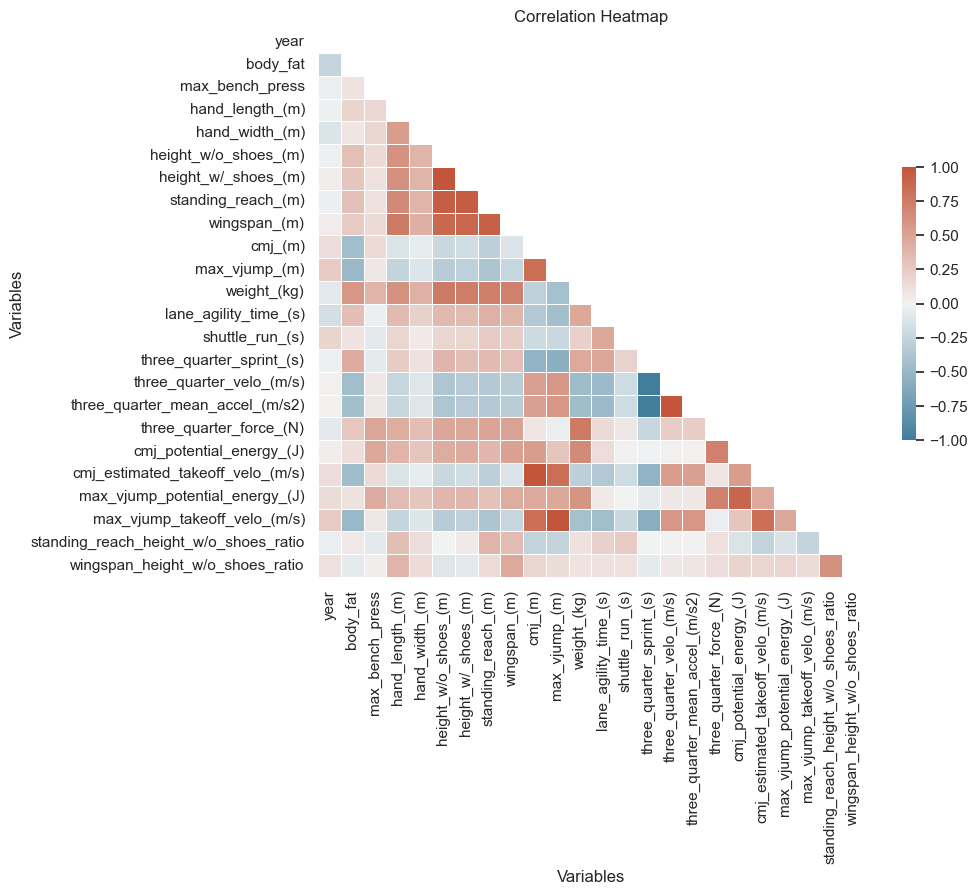

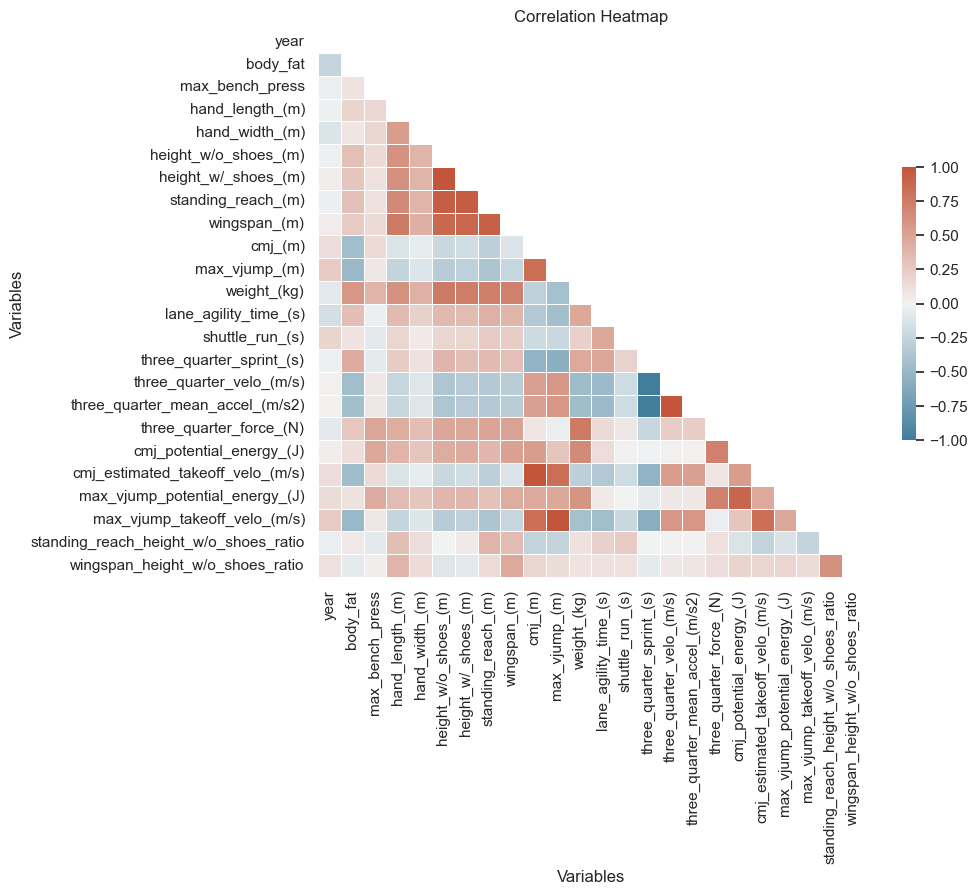

In [2466]:
correlation_plot(corr_df)

### P-Value

In [2467]:
pval_df = p_val_matrix(metric_df.drop(['player', 'pos'  ], axis=1))
pval_series_df = p_val_series(pval_df)
pval_series_df

feature_1                        feature_2  \
0          three_quarter_mean_accel_(m/s2)         three_quarter_sprint_(s)   
1             max_vjump_takeoff_velo_(m/s)                    max_vjump_(m)   
2                      height_w/_shoes_(m)             height_w/o_shoes_(m)   
3                             wingspan_(m)             height_w/o_shoes_(m)   
4                             wingspan_(m)               standing_reach_(m)   
..                                     ...                              ...   
271         max_vjump_potential_energy_(J)                  shuttle_run_(s)   
272  standing_reach_height_w/o_shoes_ratio  three_quarter_mean_accel_(m/s2)   
273  standing_reach_height_w/o_shoes_ratio         three_quarter_velo_(m/s)   
274  standing_reach_height_w/o_shoes_ratio         three_quarter_sprint_(s)   
275  standing_reach_height_w/o_shoes_ratio             height_w/o_shoes_(m)   

      p_value  
0    0.000000  
1    0.000000  
2    0.000000  
3    0.000000  
4    0.000000  
..        ...  
271  0.917167  
272  0.931876  
273  0.935432  
274  0.944080  
275  0.976767  

[276 rows x 3 columns]

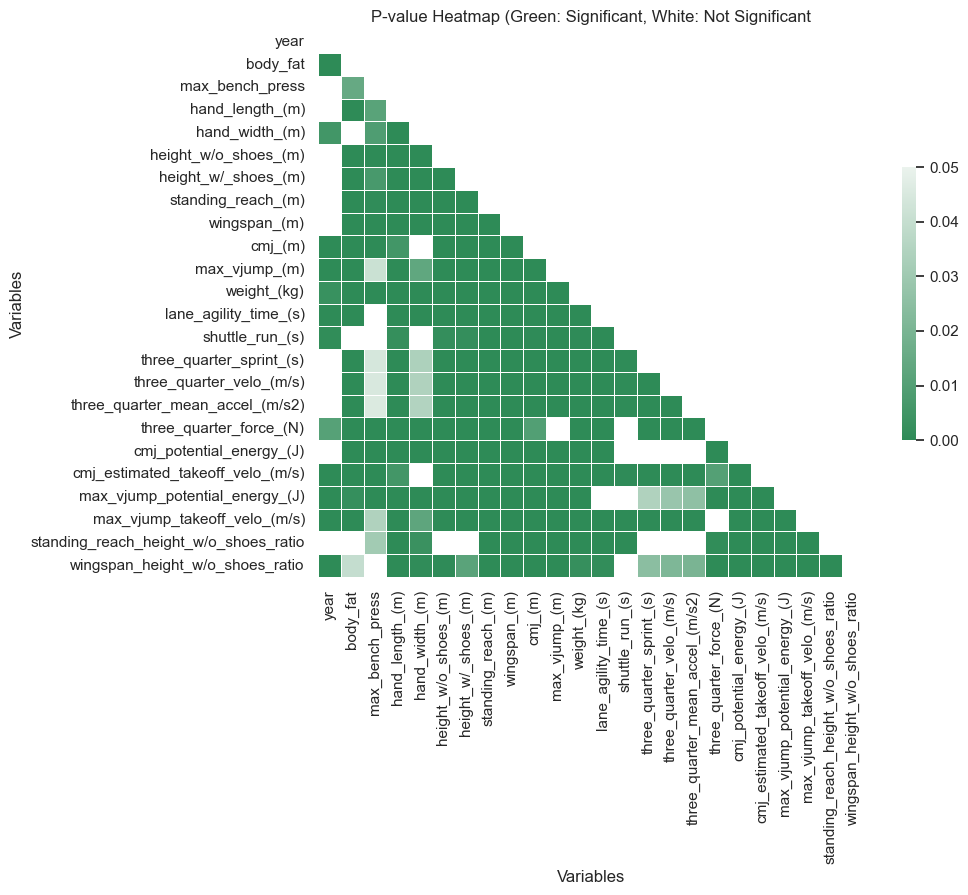

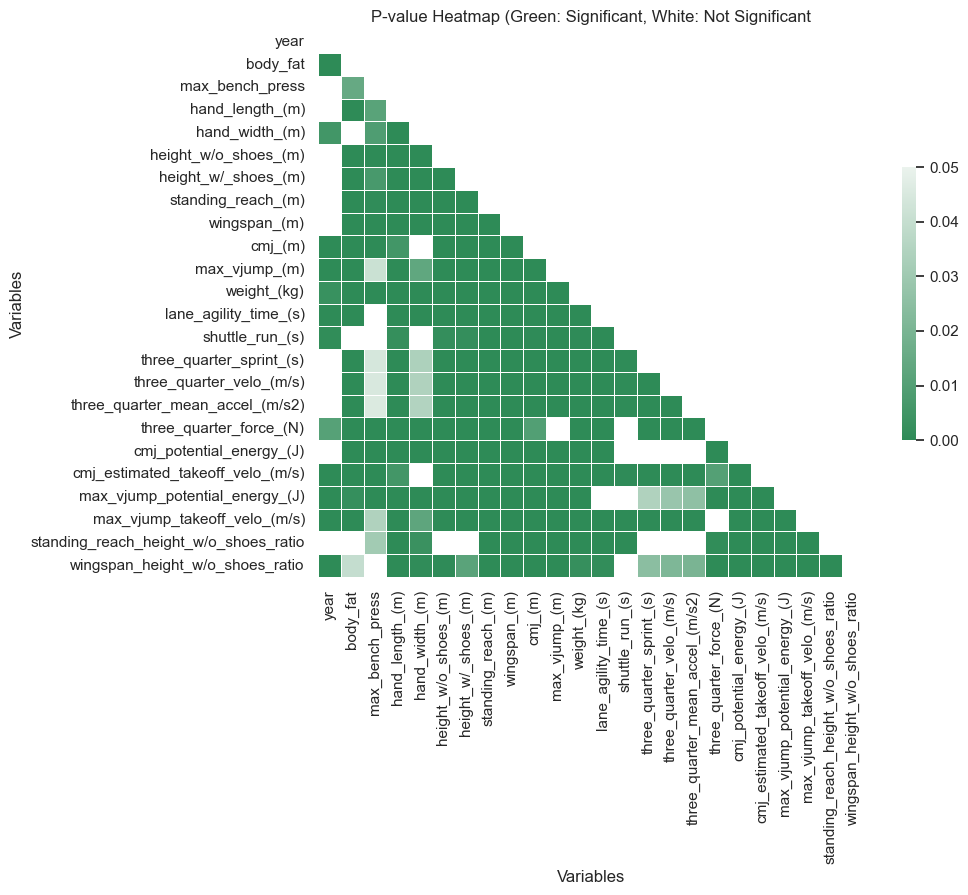

In [2468]:
p_val_plot(pval_df)

In [2469]:
corr_pval_series_merge_df = pd.merge(corr_series_df, pval_series_df, on = ['feature_1', 'feature_2'])
corr_pval_series_merge_df.to_csv(f'{project_data_exports_path}/corr_pval_series_merge_df.csv')
corr_pval_series_merge_df

feature_1                 feature_2  \
0     three_quarter_mean_accel_(m/s2)  three_quarter_velo_(m/s)   
1    cmj_estimated_takeoff_velo_(m/s)                   cmj_(m)   
2        max_vjump_takeoff_velo_(m/s)             max_vjump_(m)   
3                 height_w/_shoes_(m)      height_w/o_shoes_(m)   
4                  standing_reach_(m)       height_w/_shoes_(m)   
..                                ...                       ...   
271  cmj_estimated_takeoff_velo_(m/s)  three_quarter_sprint_(s)   
272          three_quarter_sprint_(s)             max_vjump_(m)   
273      max_vjump_takeoff_velo_(m/s)  three_quarter_sprint_(s)   
274   three_quarter_mean_accel_(m/s2)  three_quarter_sprint_(s)   
275          three_quarter_velo_(m/s)  three_quarter_sprint_(s)   

     correlation_coefficient        p_value  
0                   0.999589   0.000000e+00  
1                   0.999319   0.000000e+00  
2                   0.999283   0.000000e+00  
3                   0.997449   0.000000e+00  
4                   0.946214   0.000000e+00  
..                       ...            ...  
271                -0.532177   1.185452e-84  
272                -0.577022  1.305442e-102  
273                -0.579778  8.404893e-104  
274                -0.996274   0.000000e+00  
275                -0.998334   0.000000e+00  

[276 rows x 4 columns]

In [2470]:
corr_pval_series_merge_df.sort_values(by=['p_value', 'correlation_coefficient'], ascending=[True, False]).reset_index(drop=True)


feature_1                        feature_2  \
0          three_quarter_mean_accel_(m/s2)         three_quarter_velo_(m/s)   
1         cmj_estimated_takeoff_velo_(m/s)                          cmj_(m)   
2             max_vjump_takeoff_velo_(m/s)                    max_vjump_(m)   
3                      height_w/_shoes_(m)             height_w/o_shoes_(m)   
4                       standing_reach_(m)              height_w/_shoes_(m)   
..                                     ...                              ...   
271         max_vjump_potential_energy_(J)                  shuttle_run_(s)   
272  standing_reach_height_w/o_shoes_ratio  three_quarter_mean_accel_(m/s2)   
273  standing_reach_height_w/o_shoes_ratio         three_quarter_velo_(m/s)   
274  standing_reach_height_w/o_shoes_ratio         three_quarter_sprint_(s)   
275  standing_reach_height_w/o_shoes_ratio             height_w/o_shoes_(m)   

     correlation_coefficient   p_value  
0                   0.999589  0.000000  
1                   0.999319  0.000000  
2                   0.999283  0.000000  
3                   0.997449  0.000000  
4                   0.946214  0.000000  
..                       ...       ...  
271                -0.005960  0.917167  
272                 0.002634  0.931876  
273                 0.002496  0.935432  
274                -0.002161  0.944080  
275                -0.000846  0.976767  

[276 rows x 4 columns]

## Feature Histograms

/Users/chrisizenour/opt/anaconda3/envs/msu_petway/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



Text(0, 0.5, 'Frequency')

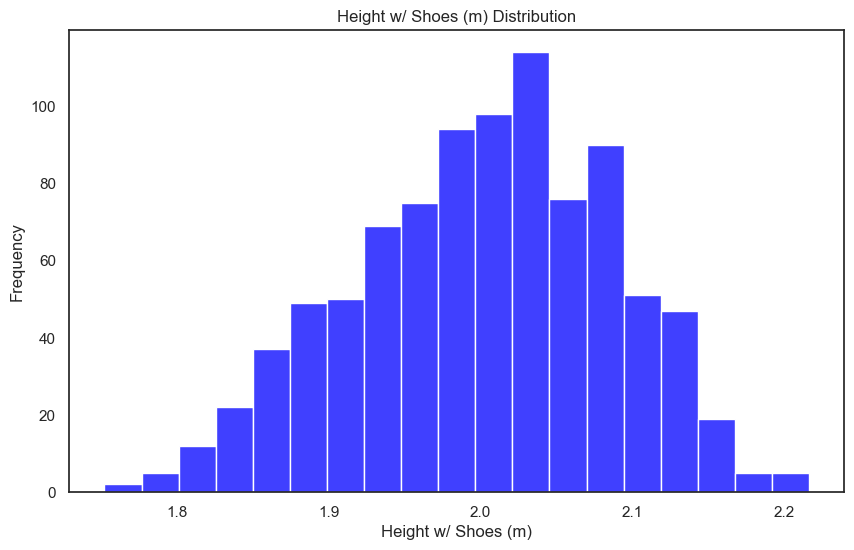

In [2471]:
height_w_shoes_hist, ax = plt.subplots(1, 1, figsize=(10, 6), facecolor='white')

sns.histplot(
    data=metric_df.loc[metric_df['height_w/_shoes_(m)'] > 0, :],
    x='height_w/_shoes_(m)',
    color='blue',
    ax=ax
)

ax.set_title('Height w/ Shoes (m) Distribution')
ax.set_xlabel('Height w/ Shoes (m)')
ax.set_ylabel('Frequency')


/Users/chrisizenour/opt/anaconda3/envs/msu_petway/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



Text(0, 0.5, 'Frequency')

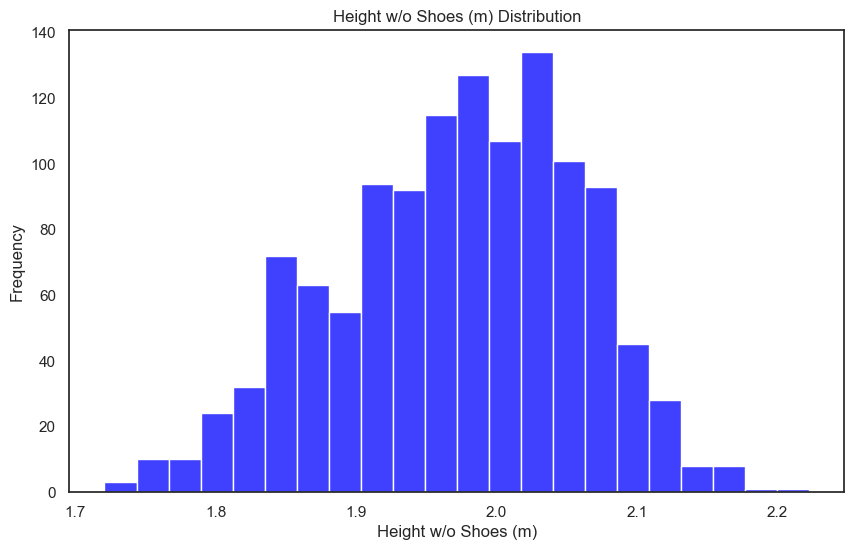

In [2472]:
height_wo_shoes_hist, ax = plt.subplots(1, 1, figsize=(10, 6), facecolor='white')

sns.histplot(
    data=metric_df.loc[metric_df['height_w/o_shoes_(m)'] > 0, :],
    x='height_w/o_shoes_(m)',
    color='blue',
    ax=ax
)

ax.set_title('Height w/o Shoes (m) Distribution')
ax.set_xlabel('Height w/o Shoes (m)')
ax.set_ylabel('Frequency')

/Users/chrisizenour/opt/anaconda3/envs/msu_petway/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



Text(0, 0.5, 'Frequency')

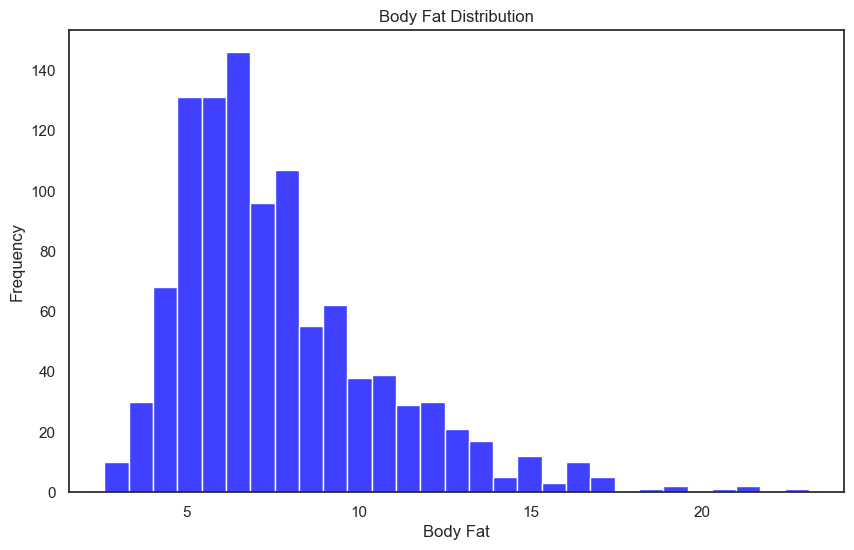

In [2473]:
body_fat_hist, ax = plt.subplots(1, 1, figsize=(10, 6), facecolor='white')

sns.histplot(
    data=metric_df.loc[metric_df['body_fat'] > 0, :],
    x='body_fat',
    color='blue',
    ax=ax
)

ax.set_title('Body Fat Distribution')
ax.set_xlabel('Body Fat')
ax.set_ylabel('Frequency')

/Users/chrisizenour/opt/anaconda3/envs/msu_petway/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



Text(0, 0.5, 'Frequency')

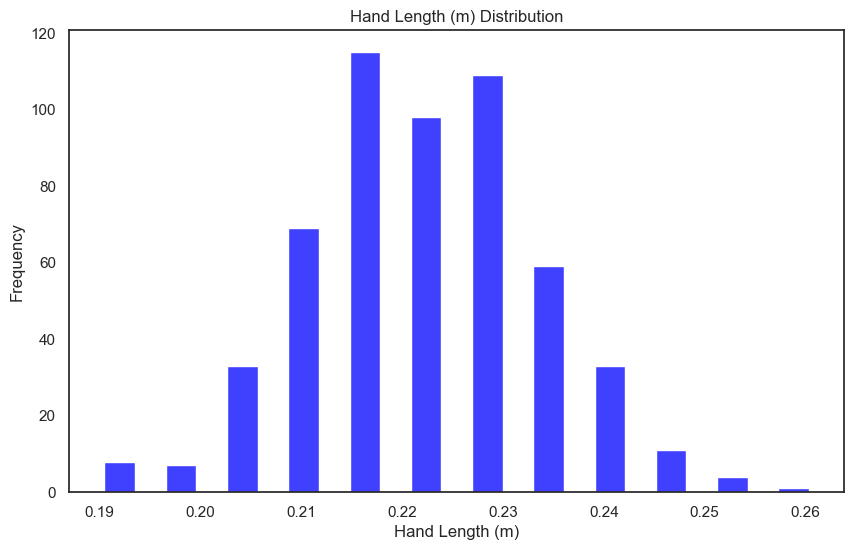

In [2474]:
hand_length_hist, ax = plt.subplots(1, 1, figsize=(10, 6), facecolor='white')

sns.histplot(
    data=metric_df.loc[metric_df['hand_length_(m)'] > 0, :],
    x='hand_length_(m)',
    color='blue',
    ax=ax
)

ax.set_title('Hand Length (m) Distribution')
ax.set_xlabel('Hand Length (m)')
ax.set_ylabel('Frequency')

/Users/chrisizenour/opt/anaconda3/envs/msu_petway/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



Text(0, 0.5, 'Frequency')

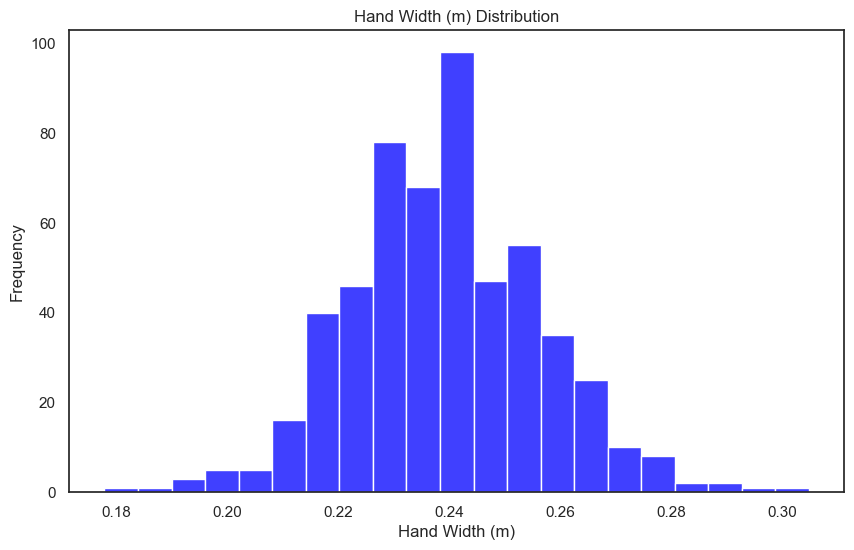

In [2475]:
hand_width_hist, ax = plt.subplots(1, 1, figsize=(10, 6), facecolor='white')

sns.histplot(
    data=metric_df.loc[metric_df['hand_width_(m)'] > 0, :],
    x='hand_width_(m)',
    color='blue',
    ax=ax
)

ax.set_title('Hand Width (m) Distribution')
ax.set_xlabel('Hand Width (m)')
ax.set_ylabel('Frequency')

/Users/chrisizenour/opt/anaconda3/envs/msu_petway/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



Text(0, 0.5, 'Frequency')

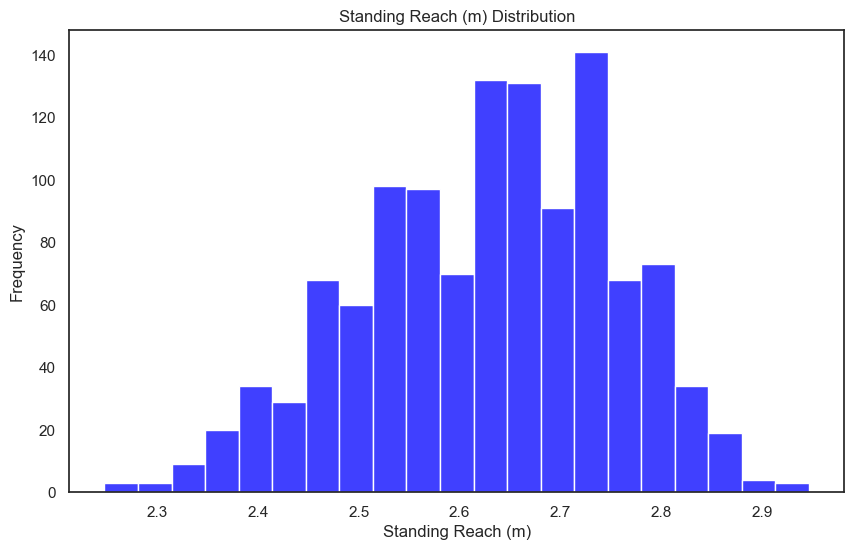

In [2476]:
standing_reach_hist, ax = plt.subplots(1, 1, figsize=(10, 6), facecolor='white')

sns.histplot(
    data=metric_df.loc[metric_df['standing_reach_(m)'] > 0, :],
    x='standing_reach_(m)',
    color='blue',
    ax=ax
)

ax.set_title('Standing Reach (m) Distribution')
ax.set_xlabel('Standing Reach (m)')
ax.set_ylabel('Frequency')

/Users/chrisizenour/opt/anaconda3/envs/msu_petway/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



Text(0, 0.5, 'Frequency')

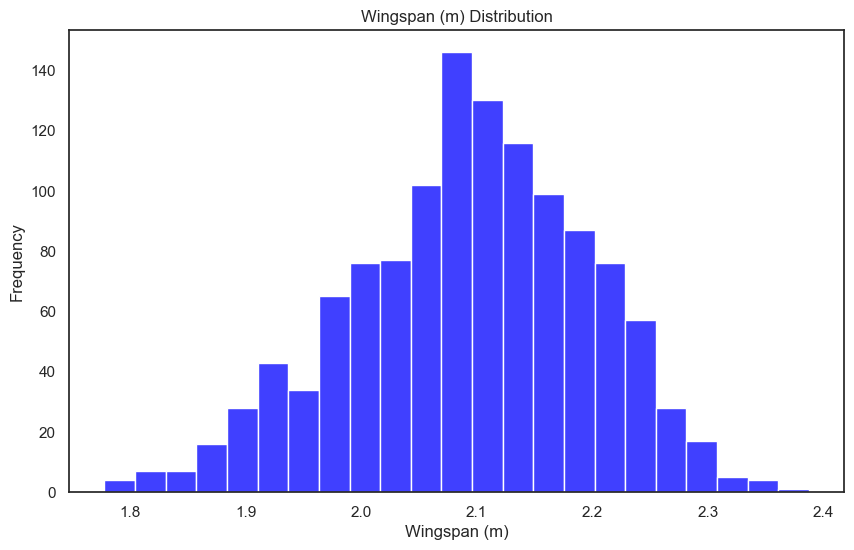

In [2477]:
wingspan_hist, ax = plt.subplots(1, 1, figsize=(10, 6), facecolor='white')

sns.histplot(
    data=metric_df.loc[metric_df['wingspan_(m)'] > 0, :],
    x='wingspan_(m)',
    color='blue',
    ax=ax
)

ax.set_title('Wingspan (m) Distribution')
ax.set_xlabel('Wingspan (m)')
ax.set_ylabel('Frequency')

/Users/chrisizenour/opt/anaconda3/envs/msu_petway/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



Text(0, 0.5, 'Frequency')

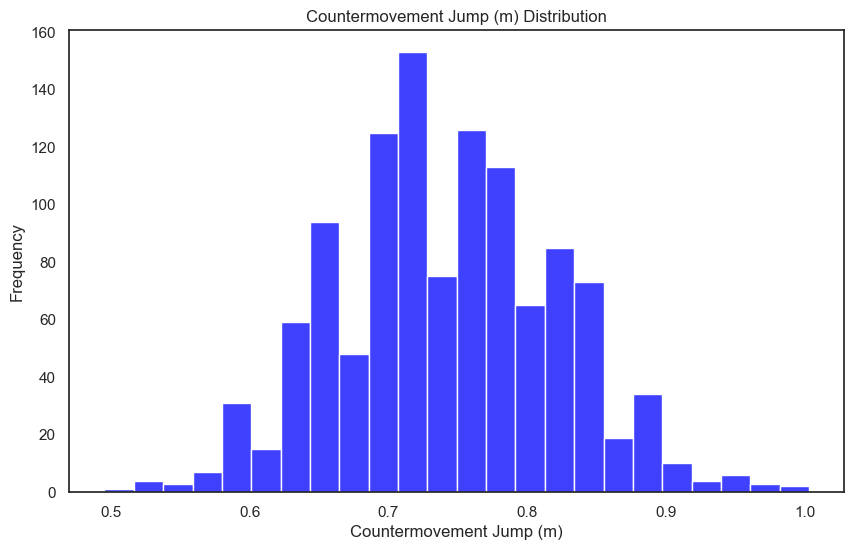

In [2478]:
cmj_hist, ax = plt.subplots(1, 1, figsize=(10, 6), facecolor='white')

sns.histplot(
    data=metric_df.loc[metric_df['cmj_(m)'] > 0, :],
    x='cmj_(m)',
    color='blue',
    ax=ax
)

ax.set_title('Countermovement Jump (m) Distribution')
ax.set_xlabel('Countermovement Jump (m)')
ax.set_ylabel('Frequency')

/Users/chrisizenour/opt/anaconda3/envs/msu_petway/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



Text(0, 0.5, 'Frequency')

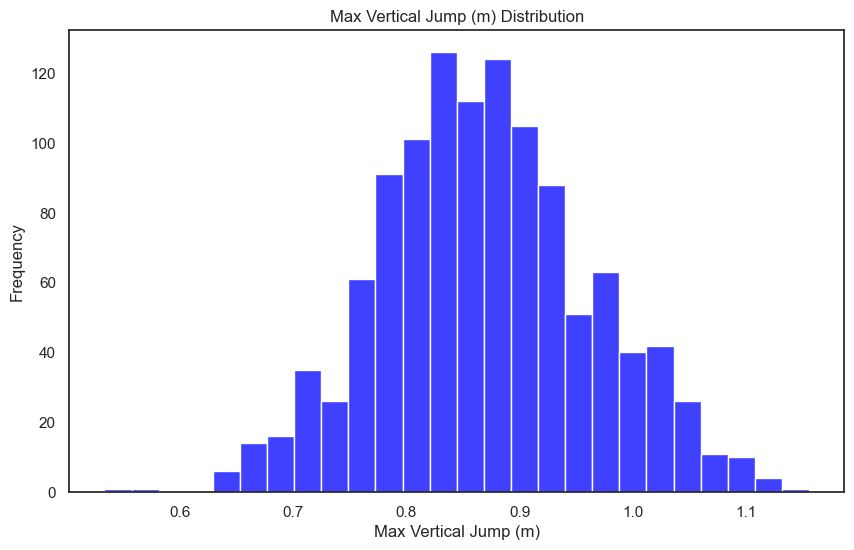

In [2479]:
max_vjump_hist, ax = plt.subplots(1, 1, figsize=(10, 6), facecolor='white')

sns.histplot(
    data=metric_df.loc[metric_df['max_vjump_(m)'] > 0, :],
    x='max_vjump_(m)',
    color='blue',
    ax=ax
)

ax.set_title('Max Vertical Jump (m) Distribution')
ax.set_xlabel('Max Vertical Jump (m)')
ax.set_ylabel('Frequency')

/Users/chrisizenour/opt/anaconda3/envs/msu_petway/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



Text(0, 0.5, 'Frequency')

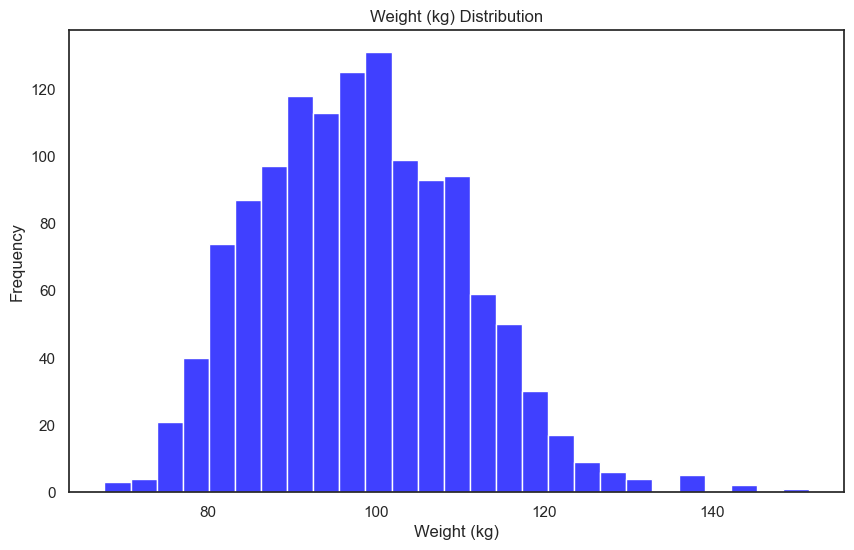

In [2480]:
weight_hist, ax = plt.subplots(1, 1, figsize=(10, 6), facecolor='white')

sns.histplot(
    data=metric_df.loc[metric_df['weight_(kg)'] > 0, :],
    x='weight_(kg)',
    color='blue',
    ax=ax
)

ax.set_title('Weight (kg) Distribution')
ax.set_xlabel('Weight (kg)')
ax.set_ylabel('Frequency')

/Users/chrisizenour/opt/anaconda3/envs/msu_petway/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



Text(0, 0.5, 'Frequency')

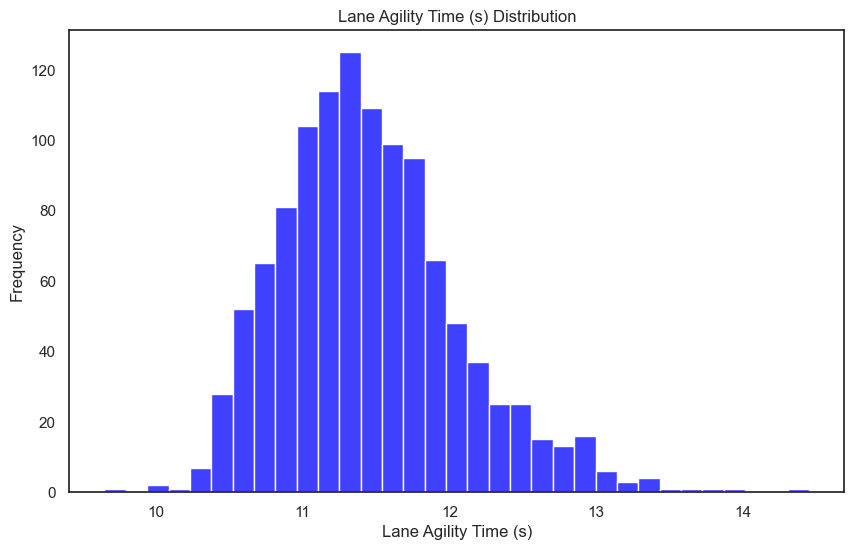

In [2481]:
lane_agility_time_hist, ax = plt.subplots(1, 1, figsize=(10, 6), facecolor='white')

sns.histplot(
    data=metric_df.loc[metric_df['lane_agility_time_(s)'] > 0, :],
    x='lane_agility_time_(s)',
    color='blue',
    ax=ax
)

ax.set_title('Lane Agility Time (s) Distribution')
ax.set_xlabel('Lane Agility Time (s)')
ax.set_ylabel('Frequency')

/Users/chrisizenour/opt/anaconda3/envs/msu_petway/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



Text(0, 0.5, 'Frequency')

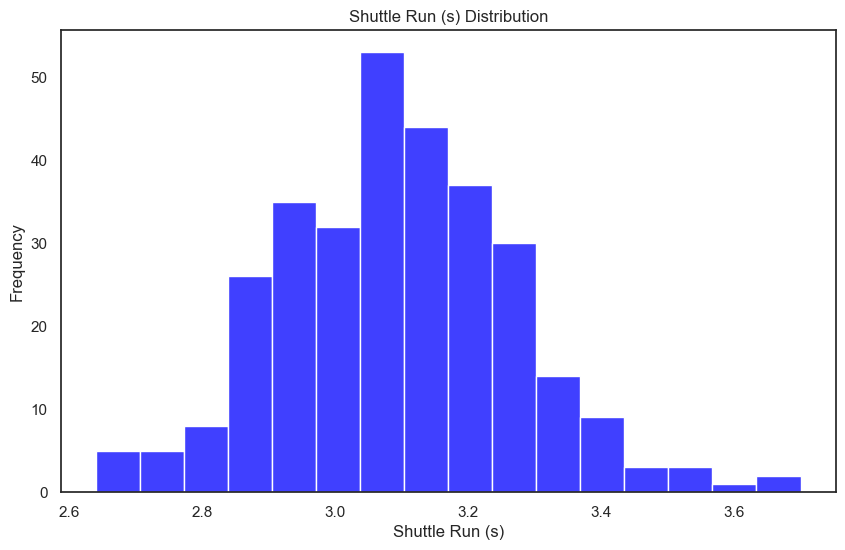

In [2482]:
shuttle_run_hist, ax = plt.subplots(1, 1, figsize=(10, 6), facecolor='white')

sns.histplot(
    data=metric_df.loc[metric_df['shuttle_run_(s)'] > 0, :],
    x='shuttle_run_(s)',
    color='blue',
    ax=ax
)

ax.set_title('Shuttle Run (s) Distribution')
ax.set_xlabel('Shuttle Run (s)')
ax.set_ylabel('Frequency')

/Users/chrisizenour/opt/anaconda3/envs/msu_petway/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



Text(0, 0.5, 'Frequency')

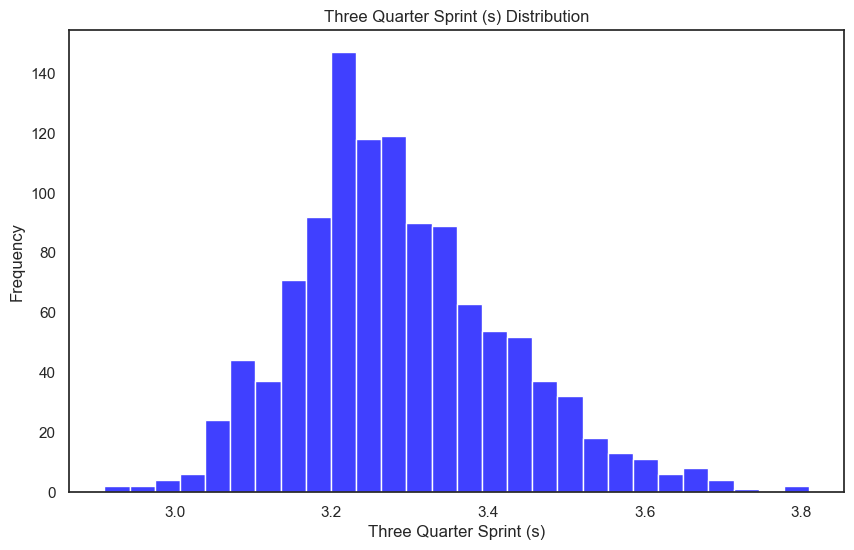

In [2483]:
three_quarter_sprint_hist, ax = plt.subplots(1, 1, figsize=(10, 6), facecolor='white')

sns.histplot(
    data=metric_df.loc[metric_df['three_quarter_sprint_(s)'] > 0, :],
    x='three_quarter_sprint_(s)',
    color='blue',
    ax=ax
)

ax.set_title('Three Quarter Sprint (s) Distribution')
ax.set_xlabel('Three Quarter Sprint (s)')
ax.set_ylabel('Frequency')

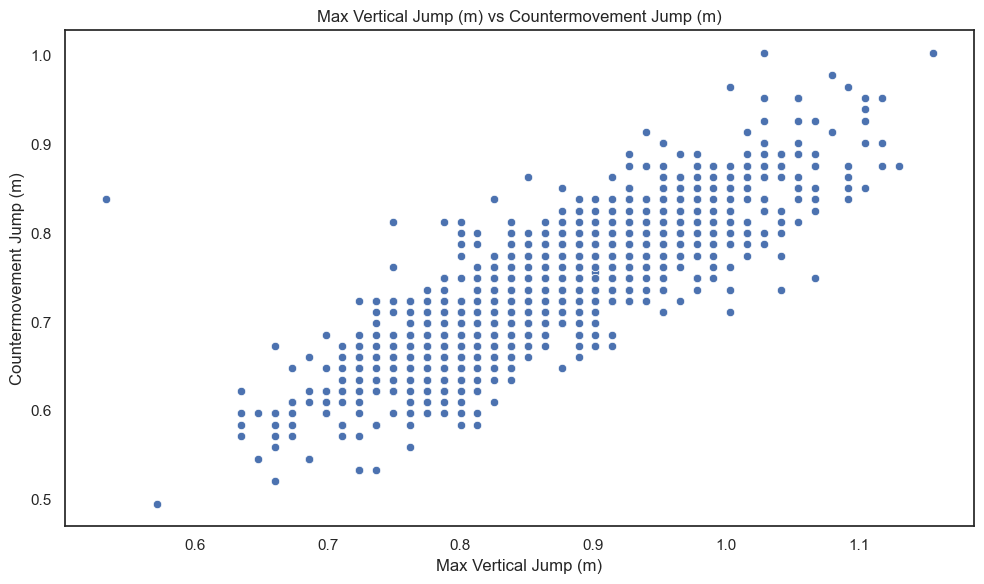

In [2484]:
max_vjump_cmj_scatter, ax = plt.subplots(1, 1, figsize=(10,6), facecolor='white')

# ax.set_ylim(0, 1)
# ax.set_xlim(0, 4)

sns.scatterplot(
    data=metric_df,
    x='max_vjump_(m)',
    y='cmj_(m)',
    # hue='position'
)

ax.set_title('Max Vertical Jump (m) vs Countermovement Jump (m)')
ax.set_xlabel('Max Vertical Jump (m)')
ax.set_ylabel('Countermovement Jump (m)')
max_vjump_cmj_scatter.tight_layout()
max_vjump_cmj_scatter.savefig(f'{project_data_exports_path}/max_vjump_cmj_scatter.png', dpi=300, bbox_inches='tight', pad_inches=0.5)

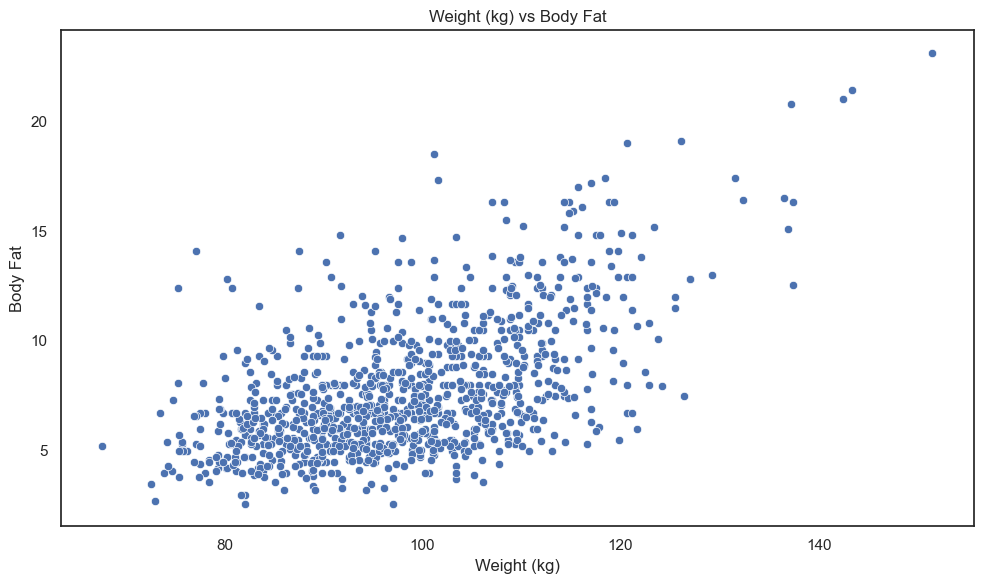

In [2485]:
weight_bodyfat_scatter, ax = plt.subplots(1, 1, figsize=(10,6), facecolor='white')

# ax.set_ylim(0, 1)
# ax.set_xlim(0, 4)

sns.scatterplot(
    data=metric_df,
    x='weight_(kg)',
    y='body_fat',
    # hue='position'
)

ax.set_title('Weight (kg) vs Body Fat')
ax.set_xlabel('Weight (kg)')
ax.set_ylabel('Body Fat')
weight_bodyfat_scatter.tight_layout()
weight_bodyfat_scatter.savefig(f'{project_data_exports_path}/weight_bodyfat_scatter.png', dpi=300, bbox_inches='tight', pad_inches=0.5)

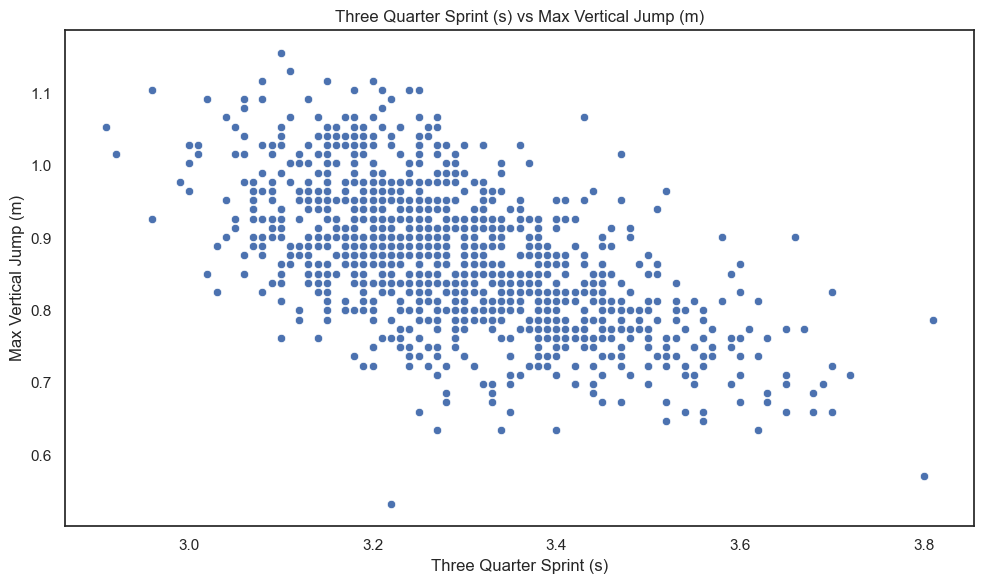

In [2486]:
three_quarter_sprint_max_vjump_scatter, ax = plt.subplots(1, 1, figsize=(10,6), facecolor='white')

# ax.set_ylim(0, 1)
# ax.set_xlim(0, 4)

sns.scatterplot(
    data=metric_df,
    x='three_quarter_sprint_(s)',
    y='max_vjump_(m)',
    # hue='position'
)

ax.set_title('Three Quarter Sprint (s) vs Max Vertical Jump (m)')
ax.set_xlabel('Three Quarter Sprint (s)')
ax.set_ylabel('Max Vertical Jump (m)')
three_quarter_sprint_max_vjump_scatter.tight_layout()
three_quarter_sprint_max_vjump_scatter.savefig(f'{project_data_exports_path}/three_quarter_sprint_max_vjump_scatter.png', dpi=300, bbox_inches='tight', pad_inches=0.5)

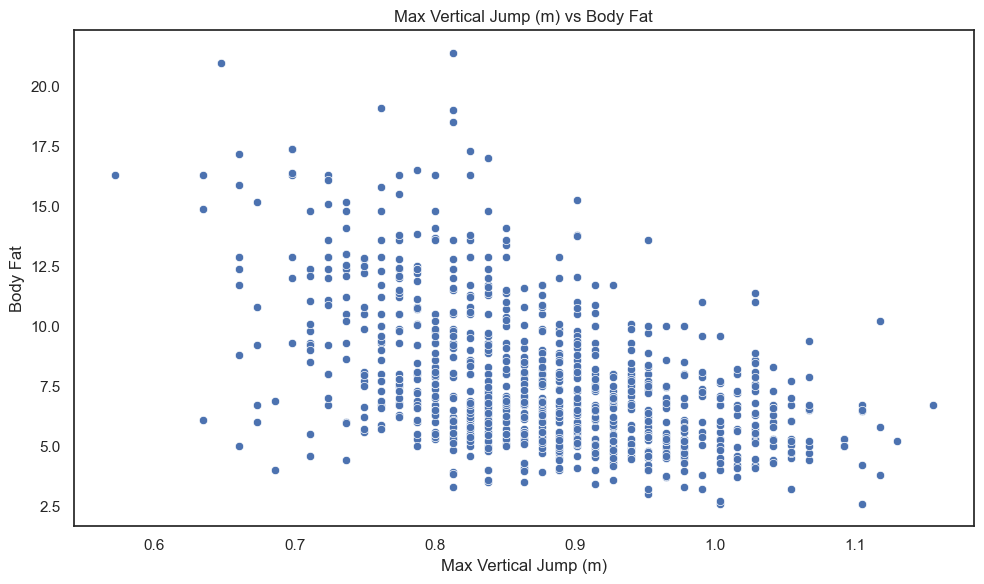

In [2487]:
max_vjump_bodyfat_scatter, ax = plt.subplots(1, 1, figsize=(10,6), facecolor='white')

# ax.set_ylim(0, 1)
# ax.set_xlim(0, 4)

sns.scatterplot(
    data=metric_df,
    x='max_vjump_(m)',
    y='body_fat',
    # hue='position'
)

ax.set_title('Max Vertical Jump (m) vs Body Fat')
ax.set_xlabel('Max Vertical Jump (m)')
ax.set_ylabel('Body Fat')
max_vjump_bodyfat_scatter.tight_layout()
max_vjump_bodyfat_scatter.savefig(f'{project_data_exports_path}/max_vjump_bodyfat_scatter.png', dpi=300, bbox_inches='tight', pad_inches=0.5)

# Clustering

In [2488]:
metric_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1289 entries, 0 to 1288
Data columns (total 26 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   player                                 1289 non-null   object 
 1   year                                   1289 non-null   int64  
 2   pos                                    1289 non-null   object 
 3   body_fat                               1052 non-null   float64
 4   max_bench_press                        947 non-null    float64
 5   hand_length_(m)                        547 non-null    float64
 6   hand_width_(m)                         547 non-null    float64
 7   height_w/o_shoes_(m)                   1224 non-null   float64
 8   height_w/_shoes_(m)                    921 non-null    float64
 9   standing_reach_(m)                     1188 non-null   float64
 10  wingspan_(m)                           1226 non-null   float64
 11  cmj_

In [2489]:
metric_df.isnull().sum()

player                                     0
year                                       0
pos                                        0
body_fat                                 237
max_bench_press                          342
hand_length_(m)                          742
hand_width_(m)                           742
height_w/o_shoes_(m)                      65
height_w/_shoes_(m)                      368
standing_reach_(m)                       101
wingspan_(m)                              63
cmj_(m)                                  134
max_vjump_(m)                            134
weight_(kg)                                7
lane_agility_time_(s)                    143
shuttle_run_(s)                          982
three_quarter_sprint_(s)                 143
three_quarter_velo_(m/s)                 143
three_quarter_mean_accel_(m/s2)          143
three_quarter_force_(N)                  144
cmj_potential_energy_(J)                 135
cmj_estimated_takeoff_velo_(m/s)         134
max_vjump_

In [2490]:
metric_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1289 entries, 0 to 1288
Data columns (total 26 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   player                                 1289 non-null   object 
 1   year                                   1289 non-null   int64  
 2   pos                                    1289 non-null   object 
 3   body_fat                               1052 non-null   float64
 4   max_bench_press                        947 non-null    float64
 5   hand_length_(m)                        547 non-null    float64
 6   hand_width_(m)                         547 non-null    float64
 7   height_w/o_shoes_(m)                   1224 non-null   float64
 8   height_w/_shoes_(m)                    921 non-null    float64
 9   standing_reach_(m)                     1188 non-null   float64
 10  wingspan_(m)                           1226 non-null   float64
 11  cmj_

In [2491]:
metric_clustering_df = metric_df.iloc[:, np.r_[0, 1, 2, 13, 3, 4, 7, 9, 10, 11, 20, 21, 12, 23, 22, 16:20, 14, 24, 25]].dropna().reset_index(drop=True)
metric_clustering_df
clustering_df = metric_df.iloc[:, np.r_[13, 3, 4, 7, 9, 10, 11, 20, 21, 12, 23, 22, 16:20, 14, 24, 25]].dropna().reset_index(drop=True)
clustering_df

weight_(kg)  body_fat  max_bench_press  height_w/o_shoes_(m)  \
0      83.914520       5.3              0.0               1.99390   
1      94.800728      10.5              0.0               2.08915   
2      83.007336       6.7              0.0               1.86055   
3      80.739376       6.7              1.0               1.87960   
4      90.264808      13.6              1.0               1.84785   
..           ...       ...              ...                   ...   
604    82.281589       6.6              4.0               1.93675   
605   104.416878       5.8             12.0               1.96850   
606   118.568949      12.0              8.0               2.01295   
607    86.998946       5.5              9.0               1.84785   
608    91.353429       4.0              9.0               1.93040   

     standing_reach_(m)  wingspan_(m)  cmj_(m)  cmj_potential_energy_(J)  \
0                2.6162       2.12090   0.8382                690.007448   
1                2.8067       2.27965   0.5969                555.114100   
2                2.4511       1.91770   0.8382                682.547908   
3                2.5400       2.00025   0.7747                613.603675   
4                2.4765       2.01930   0.7112                629.766012   
..                  ...           ...      ...                       ...   
604              2.5781       2.01930   0.7493                604.821762   
605              2.6670       2.10820   0.7239                741.512181   
606              2.7051       2.17805   0.6477                753.379631   
607              2.5273       2.03200   0.7239                617.819445   
608              2.6543       2.13995   0.8636                773.938575   

     cmj_estimated_takeoff_velo_(m/s)  max_vjump_(m)  \
0                            4.055303         1.0922   
1                            3.422160         0.7493   
2                            4.055303         0.9271   
3                            3.898668         0.8763   
4                            3.735471         0.9525   
..                                ...            ...   
604                          3.834223         0.7874   
605                          3.768676         0.8763   
606                          3.564811         0.7239   
607                          3.768676         0.8636   
608                          4.116289         1.0033   

     max_vjump_takeoff_velo_(m/s)  max_vjump_potential_energy_(J)  \
0                        4.629143                      899.100614   
1                        3.834223                      696.845360   
2                        4.264939                      754.939353   
3                        4.146445                      694.076288   
4                        4.322968                      843.436623   
..                            ...                             ...   
604                      3.930495                      635.575411   
605                      4.146445                      897.620008   
606                      3.768676                      842.012529   
607                      4.116289                      737.047759   
608                      4.436749                      899.134521   

     three_quarter_sprint_(s)  three_quarter_velo_(m/s)  \
0                        3.08                  7.422078   
1                        3.55                  6.439437   
2                        3.10                  7.374194   
3                        3.21                  7.121495   
4                        3.20                  7.143750   
..                        ...                       ...   
604                      3.29                  6.948328   
605                      3.20                  7.143750   
606                      3.50                  6.531429   
607                      3.51                  6.512821   
608                      3.18                  7.188679   

     three_quarter_mean_accel_(m/s2)  three_quarter_

In [2492]:
clustering_df.isnull().sum()

weight_(kg)                              0
body_fat                                 0
max_bench_press                          0
height_w/o_shoes_(m)                     0
standing_reach_(m)                       0
wingspan_(m)                             0
cmj_(m)                                  0
cmj_potential_energy_(J)                 0
cmj_estimated_takeoff_velo_(m/s)         0
max_vjump_(m)                            0
max_vjump_takeoff_velo_(m/s)             0
max_vjump_potential_energy_(J)           0
three_quarter_sprint_(s)                 0
three_quarter_velo_(m/s)                 0
three_quarter_mean_accel_(m/s2)          0
three_quarter_force_(N)                  0
lane_agility_time_(s)                    0
standing_reach_height_w/o_shoes_ratio    0
wingspan_height_w/o_shoes_ratio          0
dtype: int64

## KMeans Clustering

In [2493]:
inertias_df = inertia_scores(clustering_df)
inertias_df

[11571.000000000007,
 8610.363533814358,
 7157.208933522063,
 6434.823264782062,
 5999.774777293103,
 5669.645386277465,
 5388.147949292129,
 5170.813002471719,
 4964.473566462964,
 4813.979162549121,
 4651.72926120582,
 4549.2902187300315,
 4395.7099004032425,
 4278.585627569766,
 4172.270654771445]

/Users/chrisizenour/opt/anaconda3/envs/msu_petway/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/Users/chrisizenour/opt/anaconda3/envs/msu_petway/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



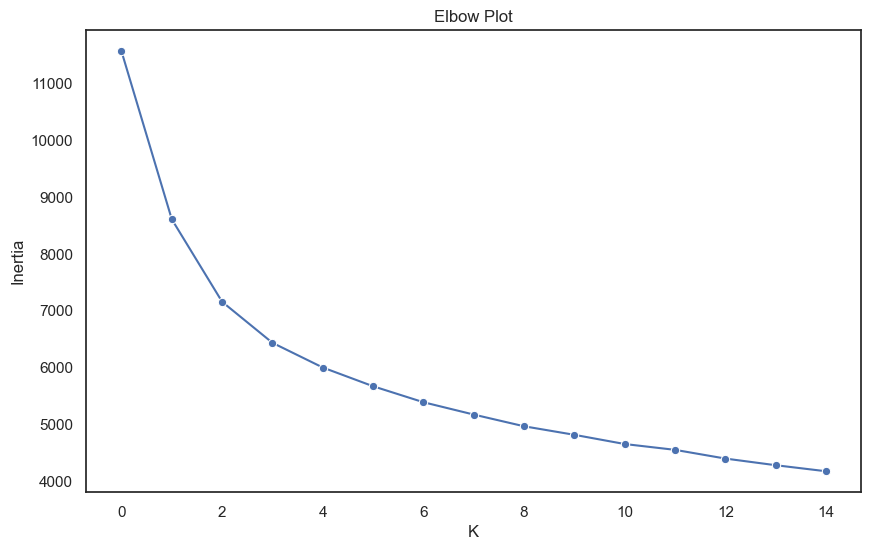

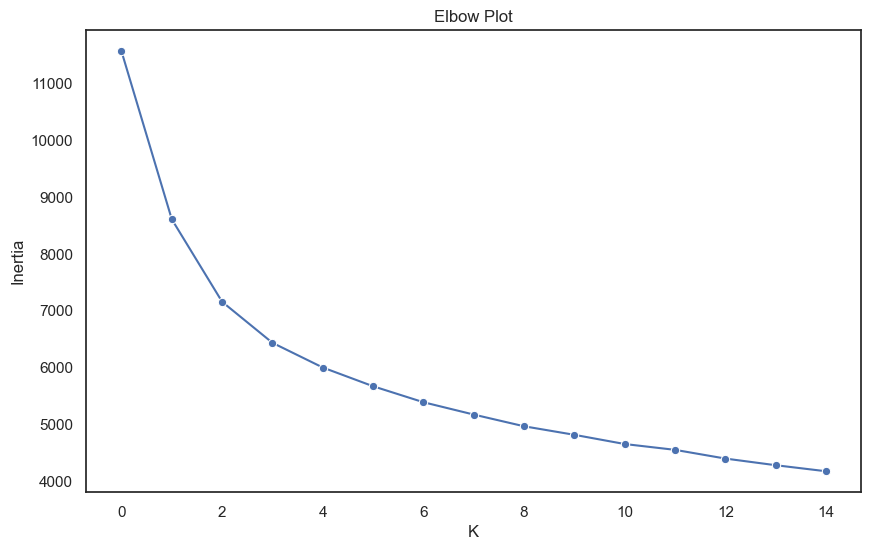

In [2494]:
elbow_plot(inertias_df)

In [2495]:
silhouettes_df = silhouette_scores(clustering_df)
silhouettes_df

/Users/chrisizenour/opt/anaconda3/envs/msu_petway/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/chrisizenour/opt/anaconda3/envs/msu_petway/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/chrisizenour/opt/anaconda3/envs/msu_petway/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/chrisizenour/opt/anaconda3/envs/msu_petway/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicit

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/chrisizenour/opt/anaconda3/envs/msu_petway/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/chrisizenour/opt/anaconda3/envs/msu_petway/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/chrisizenour/opt/anaconda3/envs/msu_petway/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/chrisizenour/opt/anaconda3/envs/msu_petway/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/chrisizenour/opt/anaconda3/envs/msu_petway/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/chrisizenour/opt/anaconda3/envs/msu_petway/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/chrisizenour/opt/anaconda3/envs/msu_petway/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/chrisizenour/opt/anaconda3/envs/msu_petway/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/chrisizenour/opt/anaconda3/envs/msu_petway/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/chrisizenour/opt/anaconda3/envs/msu_petway/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



silhouette_score   k
0           0.017518   2
1           0.111741   3
2           0.062767   4
3           0.036099   5
4          -0.038567   6
5          -0.044167   7
6          -0.040832   8
7          -0.049227   9
8          -0.059415  10
9          -0.079971  11
10         -0.096872  12
11         -0.068766  13
12         -0.077248  14
13         -0.086233  15

/Users/chrisizenour/opt/anaconda3/envs/msu_petway/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/Users/chrisizenour/opt/anaconda3/envs/msu_petway/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



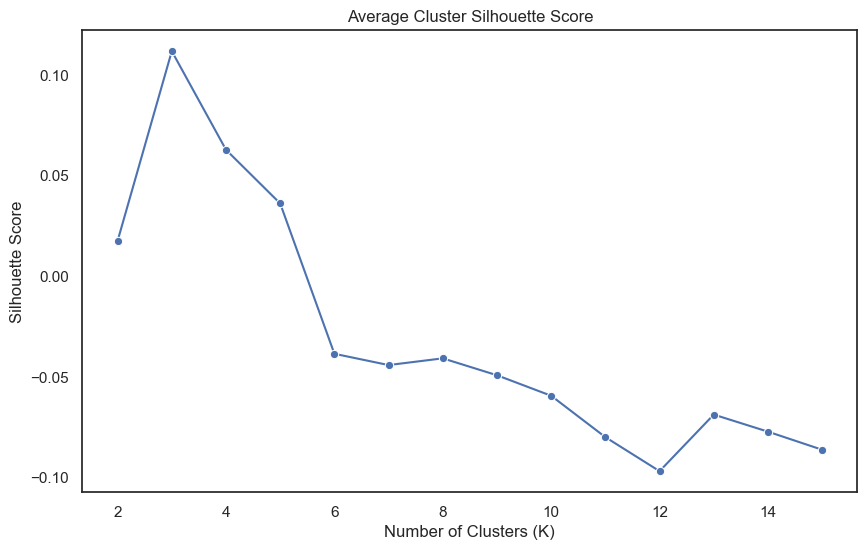

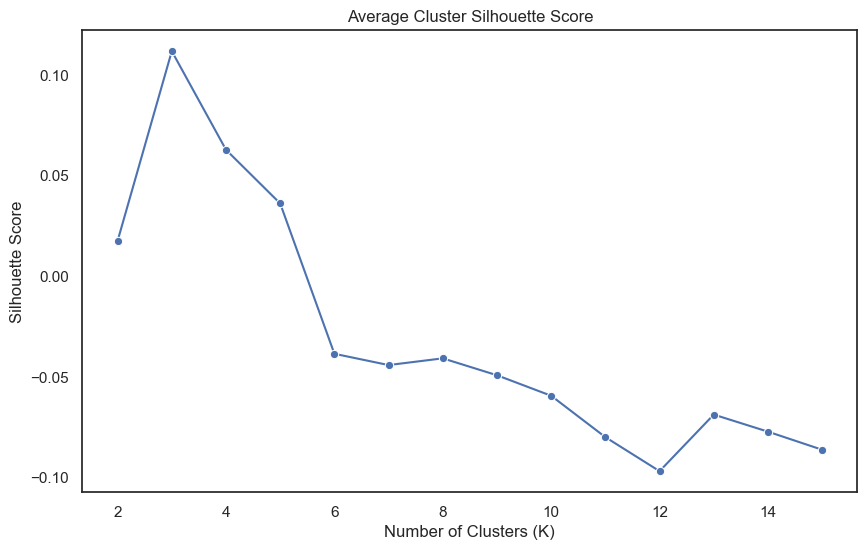

In [2496]:
silhouette_score_plot(silhouettes_df)

In [2497]:
pca_exp_var_df = pca_cumsum_exp_var_ratios(clustering_df)
pca_exp_var_df


principal_component_qty feature_explained_variance  \
0                        0                   0.397987   
1                        1                   0.242302   
2                        2                   0.105968   
3                        3                   0.088621   
4                        4                   0.052185   
5                        5                   0.035823   
6                        6                    0.02834   
7                        7                   0.019707   
8                        8                    0.01564   
9                        9                   0.012631   
10                      10                   0.000385   
11                      11                   0.000189   
12                      12                   0.000096   
13                      13                   0.000054   
14                      14                   0.000043   
15                      15                   0.000014   
16                      16                   0.000009   
17                      17                   0.000004   
18                      18                        0.0   

   feature_cumsum_explained_variance  
0                           0.397987  
1                           0.640288  
2                           0.746256  
3                           0.834877  
4                           0.887062  
5                           0.922885  
6                           0.951226  
7                           0.970933  
8                           0.986573  
9                           0.999204  
10                          0.999589  
11                          0.999778  
12                          0.999874  
13                          0.999928  
14                          0.999972  
15                          0.999986  
16                          0.999996  
17                               1.0  
18                               1.0

/Users/chrisizenour/opt/anaconda3/envs/msu_petway/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/Users/chrisizenour/opt/anaconda3/envs/msu_petway/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



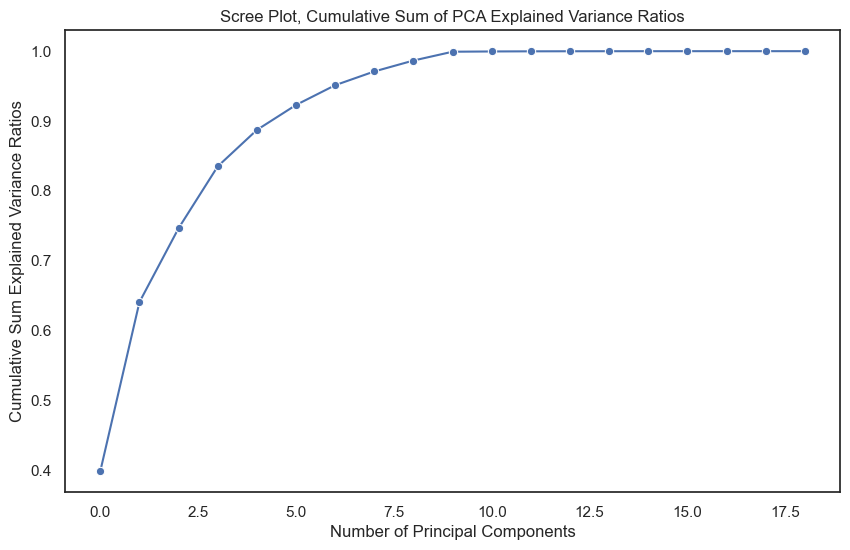

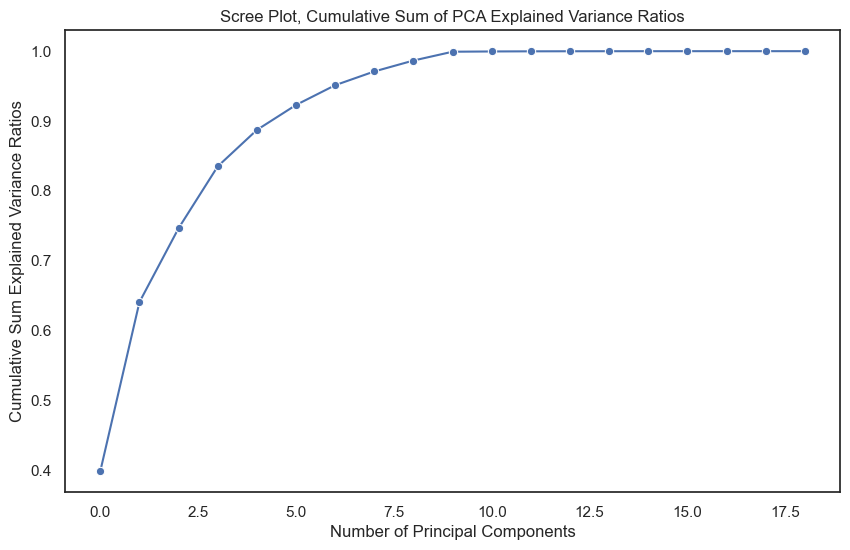

In [2498]:
scree_plot(pca_exp_var_df)

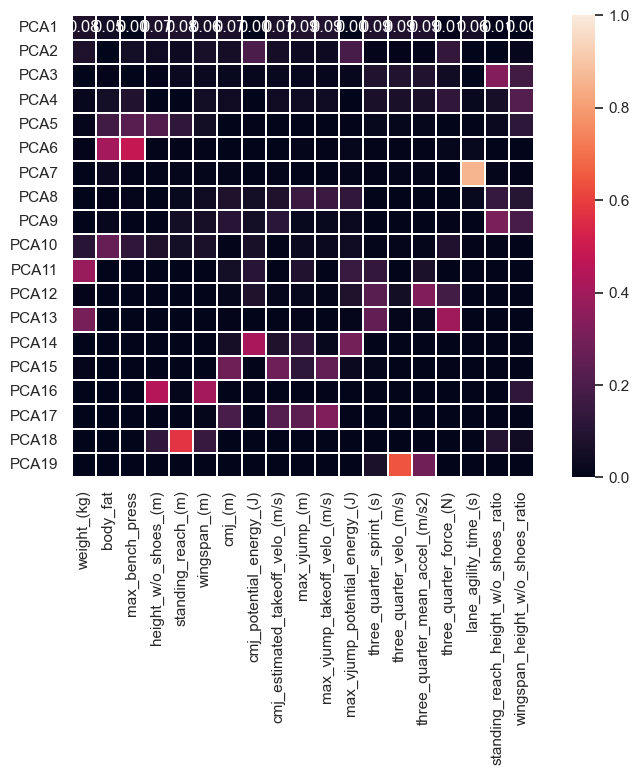

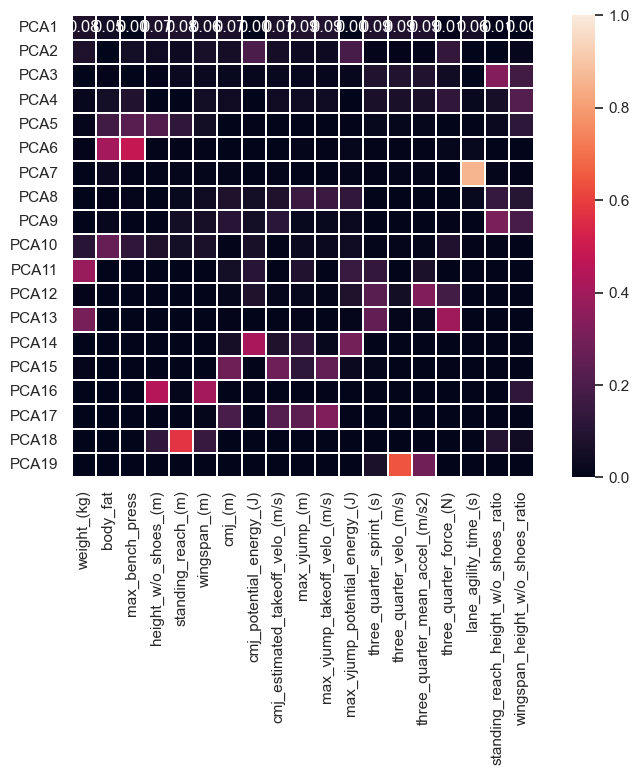

In [2499]:
pca_matrix_heatmap(clustering_df)

In [2500]:
pca_cluster_df, centroids_x, centroids_y = pca_cluster_df(clustering_df, 2, 5)
pca_cluster_df

/Users/chrisizenour/opt/anaconda3/envs/msu_petway/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



pc_1      pc_2 label
0   -3.916383 -1.123224     3
1    5.243532  3.018949     4
2   -4.023721  1.472709     3
3   -2.155939  2.625259     1
4   -1.470632  1.315256     1
..        ...       ...   ...
604 -0.702608  3.325390     1
605  0.060537 -1.146058     2
606  4.539285  0.180943     4
607 -0.094274  2.981117     1
608 -2.487654 -1.878385     0

[609 rows x 3 columns]

In [2501]:
print(centroids_x, centroids_y)

[-1.15842201 -0.63974939  0.67703307 -3.40158593  4.10740655] [-2.87061947  3.12101636 -0.36482586  0.44565222  0.20550321]


In [2502]:
labeled_df = merge_cluster_df(metric_clustering_df, pca_cluster_df)
labeled_df.to_csv(f'{project_data_exports_path}/labeled_df.csv')
labeled_df

player  year    pos  weight_(kg)  body_fat  max_bench_press  \
0     Michael Qualls  2015  SG-SF    91.353429      4.00              9.0   
1      Tony Mitchell  2013  PF-SF   107.229149      5.55             13.0   
2    Carmelo Anthony  2003     SF   105.686936      8.00              7.0   
3     Thaddeus Young  2007     SF    95.254320      4.90             13.0   
4    Thomas Robinson  2012     PF   110.767166      5.00             15.0   
..               ...   ...    ...          ...       ...              ...   
604      Rich Melzer  2004  PF-SF   103.872568     12.40              8.0   
605    Byron Mullens  2009      C   117.117454      8.50             10.0   
606   Tiago Splitter  2004   C-PF   105.686936      5.30              8.0   
607    Wesley Wilson  2003   C-PF   116.573144     12.40             20.0   
608       Taj Gibson  2009     PF    97.250125      6.60             12.0   

     height_w/o_shoes_(m)  standing_reach_(m)  wingspan_(m)  cmj_(m)  ...  \
0                 1.93040              2.6543       2.13995   0.8636  ...   
1                 2.01930              2.7051       2.19710   0.8509  ...   
2                 1.98755              2.6797       2.13360   0.7747  ...   
3                 1.97485              2.6924       2.12090   0.8763  ...   
4                 2.02565              2.6924       2.21615   0.7239  ...   
..                    ...                 ...           ...      ...  ...   
604               2.01930              2.7178       2.18440   0.6223  ...   
605               2.12725              2.8194       2.17170   0.7239  ...   
606               2.08915              2.7813       2.18440   0.6604  ...   
607               2.08915              2.8067       2.20980   0.6858  ...   
608               2.04470              2.7686       2.23520   0.6477  ...   

     three_quarter_sprint_(s)  three_quarter_velo_(m/s)  \
0                        3.18                  7.188679   
1                        3.52                  6.494318   
2                        3.15                  7.257143   
3                        3.19                  7.166144   
4                        3.17                  7.211356   
..                        ...                       ...   
604                      3.39                  6.743363   
605                      3.45                  6.626087   
606                      3.38                  6.763314   
607                      3.30                  6.927273   
608                      3.41                  6.703812   

     three_quarter_mean_accel_(m/s2)  three_quarter_force_(N)  \
0                           4.521182               413.025470   
1                           3.689954               395.670574   
2                           4.607710               486.974726   
3                           4.492880               427.966265   
4                           4.549752               503.963105   
..                               ...                      ...   
604                         3.978385               413.245082   
605                         3.841210               449.872717   
606                         4.001961               422.954966   
607                         4.198347               489.414522   
608                         3.931855               382.373363   

     lane_agility_time_(s)  standing_reach_height_w/o_shoes_ratio  \
0                    11.88                               1.375000   
1                    11.82                               1.339623   
2                    11.40                               1.348243   
3                    11.06                               1.363344   
4                    11.96                               1.329154   
..                     ...                                    ...   
604                  11.74                               1.345912   
605                  11.10                               1.325373   
606                  11.65                           

In [2503]:
pd.DataFrame(labeled_df.columns)

0
0                                  player
1                                    year
2                                     pos
3                             weight_(kg)
4                                body_fat
5                         max_bench_press
6                    height_w/o_shoes_(m)
7                      standing_reach_(m)
8                            wingspan_(m)
9                                 cmj_(m)
10               cmj_potential_energy_(J)
11       cmj_estimated_takeoff_velo_(m/s)
12                          max_vjump_(m)
13           max_vjump_takeoff_velo_(m/s)
14         max_vjump_potential_energy_(J)
15               three_quarter_sprint_(s)
16               three_quarter_velo_(m/s)
17        three_quarter_mean_accel_(m/s2)
18                three_quarter_force_(N)
19                  lane_agility_time_(s)
20  standing_reach_height_w/o_shoes_ratio
21        wingspan_height_w/o_shoes_ratio
22                                   pc_1
23                                   pc_2
24                                  label

In [2504]:
grouped_clusters_df = labeled_df.groupby(['label']).agg({
    'player': 'count',
    'weight_(kg)': 'mean',
    'body_fat': 'mean',
    'max_bench_press': 'mean',
    'height_w/o_shoes_(m)': 'mean',
    'standing_reach_(m)': 'mean',
    'wingspan_(m)': 'mean',
    'cmj_(m)': 'mean',
    'cmj_potential_energy_(J)': 'mean',
    'cmj_estimated_takeoff_velo_(m/s)': 'mean',
    'max_vjump_(m)': 'mean',
    'max_vjump_takeoff_velo_(m/s)': 'mean',
    'max_vjump_potential_energy_(J)': 'mean',
    'three_quarter_sprint_(s)': 'mean',
    'three_quarter_velo_(m/s)': 'mean',
    'three_quarter_mean_accel_(m/s2)': 'mean',
    'three_quarter_force_(N)': 'mean',
    'lane_agility_time_(s)': 'mean',
    'standing_reach_height_w/o_shoes_ratio': 'mean',
    'wingspan_height_w/o_shoes_ratio': 'mean'
})
grouped_clusters_df = grouped_clusters_df.reset_index()
# grouped_clusters_df = grouped_clusters_df.rename(columns={
#     'label': 'Cluster',
#     'testid': 'Count',
#     'takeoff_velocity': 'Takeoff Velocity (m/s)',
#     'system_weight': 'System Weight (N)',
#     'countermovement_depth': 'Countermovement Depth (m)',
#     'time_to_takeoff': 'Time to Takeoff (s)',
#     'unweighting_phase': 'Unweighting Phase (s)',
#     'braking_phase': 'Braking Phase (s)',
#     'peak_braking_power': 'Peak Braking Power (W)',
#     'force_at_min_displacement': 'Force At Min Displacement (N)',
#     'propulsive_phase': 'Propulsive Phase (s)',
#     'peak_propulsive_power': 'Peak Propulsive Power (W)',
# })
grouped_clusters_df.to_csv(f'{project_data_exports_path}/grouped_clusters_df.csv')
grouped_clusters_df

label  player  weight_(kg)   body_fat  max_bench_press  \
0     0     110   104.006584   7.311364        13.945455   
1     1      96    86.640324   7.283854         7.062500   
2     2     167   101.513618   7.869162        11.347305   
3     3     119    86.926523   5.943697         9.915966   
4     4     117   112.113986  11.147436        11.042735   

   height_w/o_shoes_(m)  standing_reach_(m)  wingspan_(m)   cmj_(m)  \
0              1.999199            2.654358      2.140585  0.824115   
1              1.897459            2.524654      1.994165  0.693552   
2              2.006866            2.679396      2.132132  0.729528   
3              1.875278            2.488186      1.995181  0.802768   
4              2.060439            2.759482      2.188850  0.652476   

   cmj_potential_energy_(J)  ...  max_vjump_(m)  max_vjump_takeoff_velo_(m/s)  \
0                839.105979  ...       0.947997                      4.310379   
1                588.597663  ...       0.829601                      4.032320   
2                725.830904  ...       0.856451                      4.097623   
3                684.058242  ...       0.964239                      4.347024   
4                716.568994  ...       0.758418                      3.854684   

   max_vjump_potential_energy_(J)  three_quarter_sprint_(s)  \
0                      964.450089                  3.214545   
1                      704.725735                  3.299792   
2                      851.458572                  3.304431   
3                      821.256221                  3.161261   
4                      832.823442                  3.471795   

   three_quarter_velo_(m/s)  three_quarter_mean_accel_(m/s2)  \
0                  7.115964                         4.432954   
1                  6.933399                         4.209186   
2                  6.923489                         4.197105   
3                  7.236180                         4.584265   
4                  6.591693                         3.805547   

   three_quarter_force_(N)  lane_agility_time_(s)  \
0               460.556607              11.303364   
1               364.425049              11.220833   
2               425.831353              11.493593   
3               398.350616              10.974622   
4               426.141756              12.139316   

   standing_reach_height_w/o_shoes_ratio  wingspan_height_w/o_shoes_ratio  
0                               1.327876                         1.070968  
1                               1.330755                         1.051324  
2                               1.335360                         1.062675  
3                               1.326945                         1.064071  
4                               1.339416                         1.062533  

[5 rows x 21 columns]

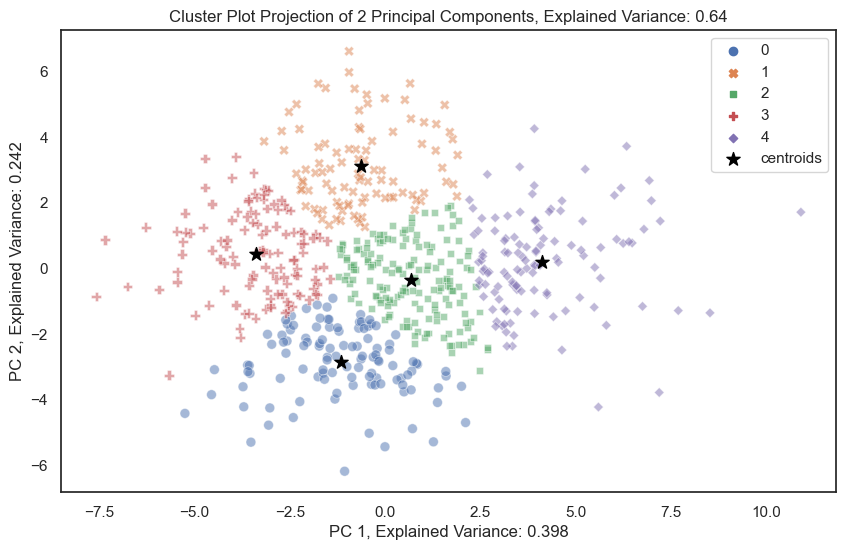

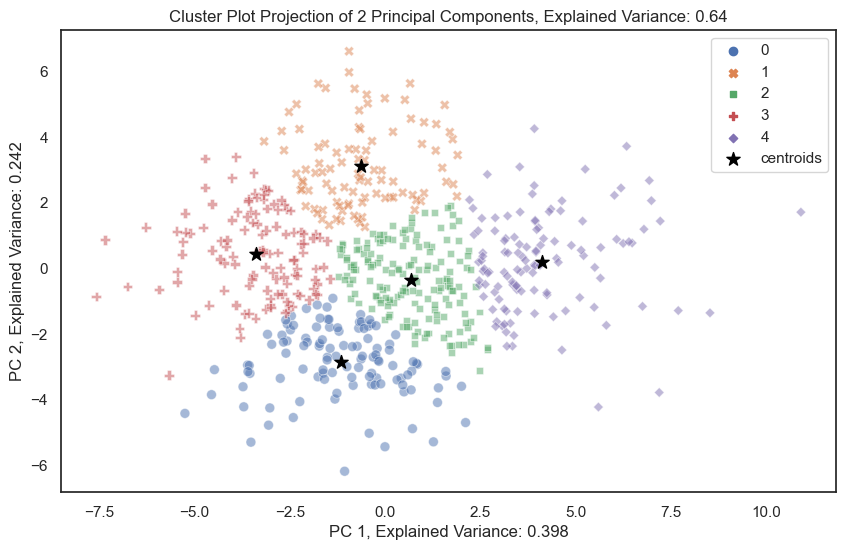

In [2505]:
pc12_cluster_plot(labeled_df, pca_exp_var_df, centroids_x, centroids_y)

In athletics, such as high jumping or pole vaulting, higher potential energy at the peak of a jump could indicate better performance. This is because achieving a higher potential energy (due to reaching a greater height) typically requires more power and skill from the athlete. Thus, in sports, higher potential energy can reflect greater athletic ability and performance.

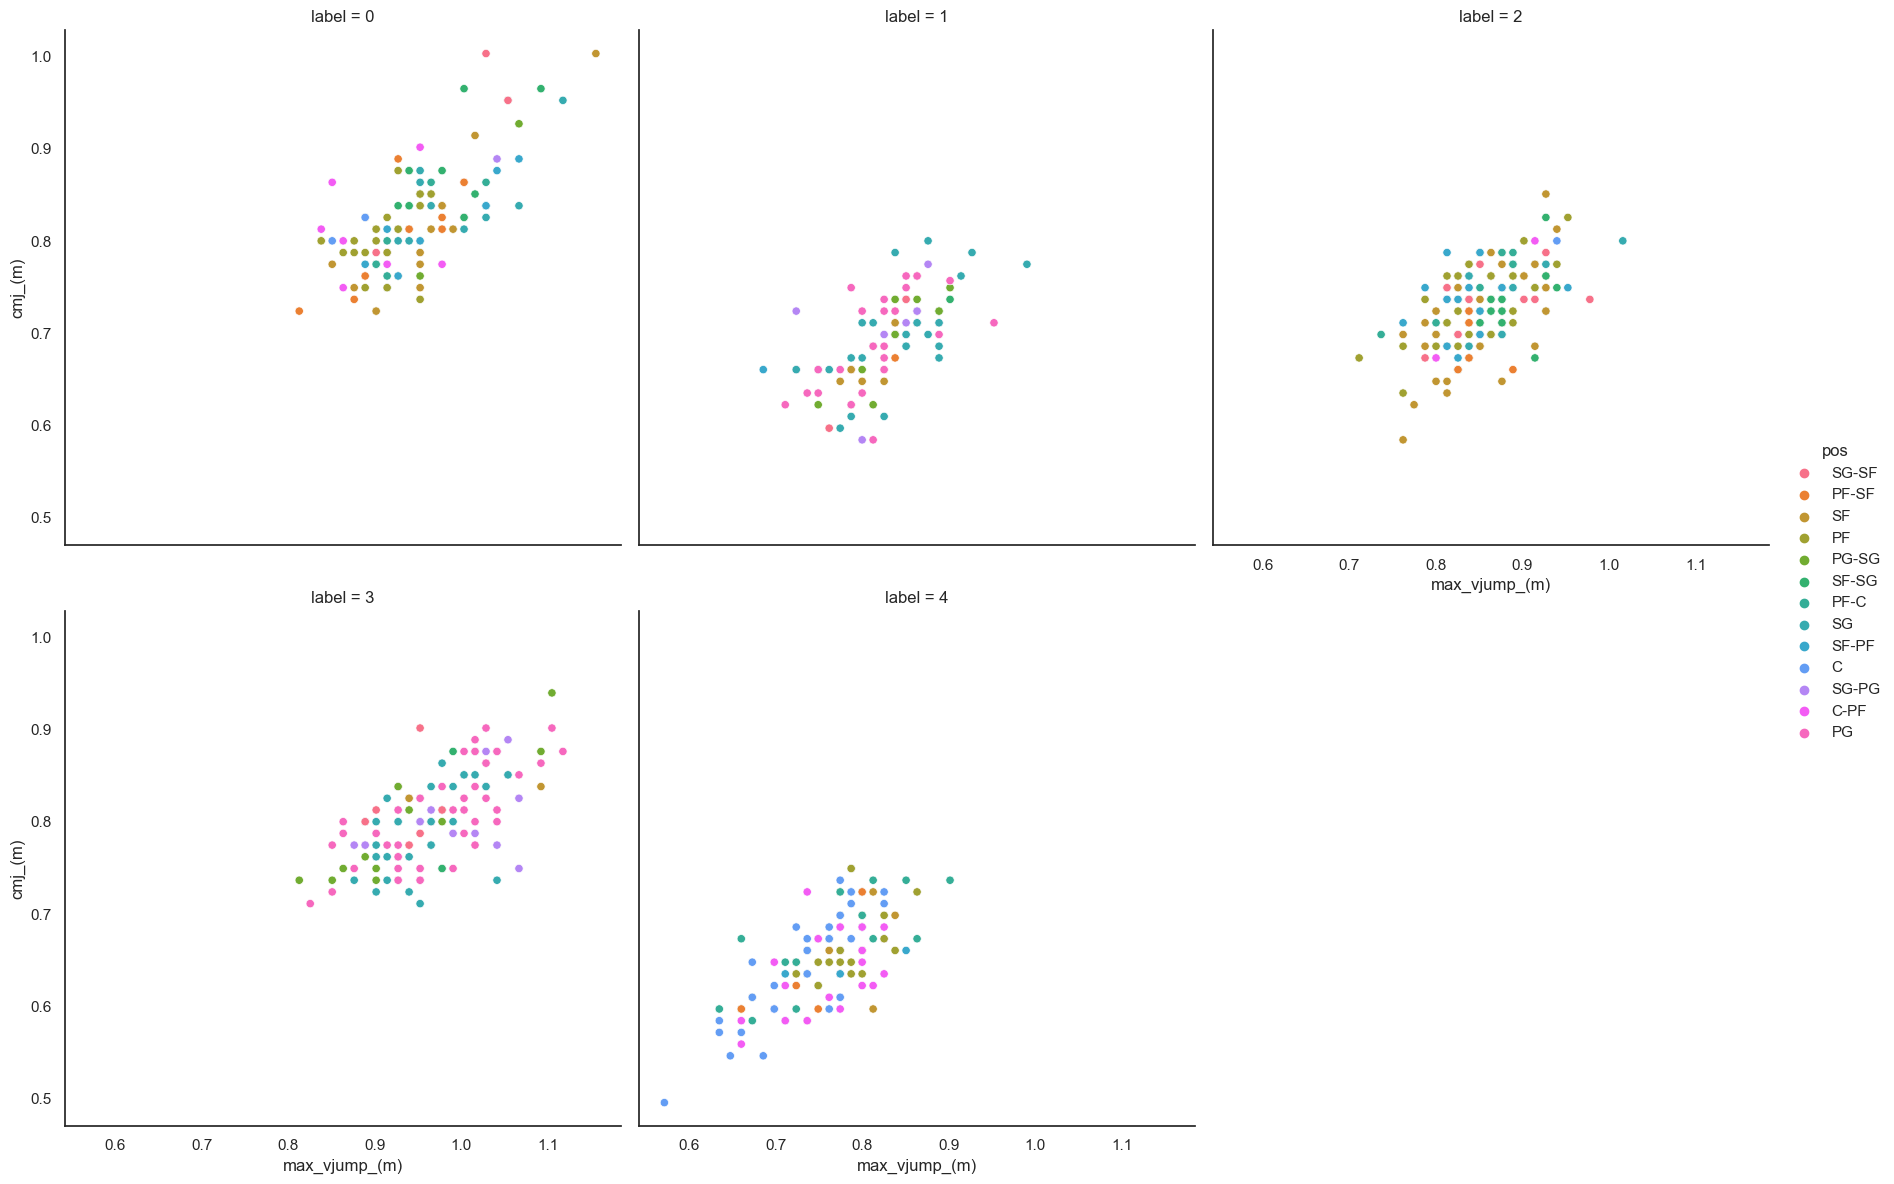

In [2506]:
cluster_max_vjump_cmj_relplot = sns.relplot(
    data=labeled_df,
    x='max_vjump_(m)',
    y='cmj_(m)',
    col='label',
    hue='pos',
    kind='scatter',
    col_wrap=3,
    height = 6,
    )

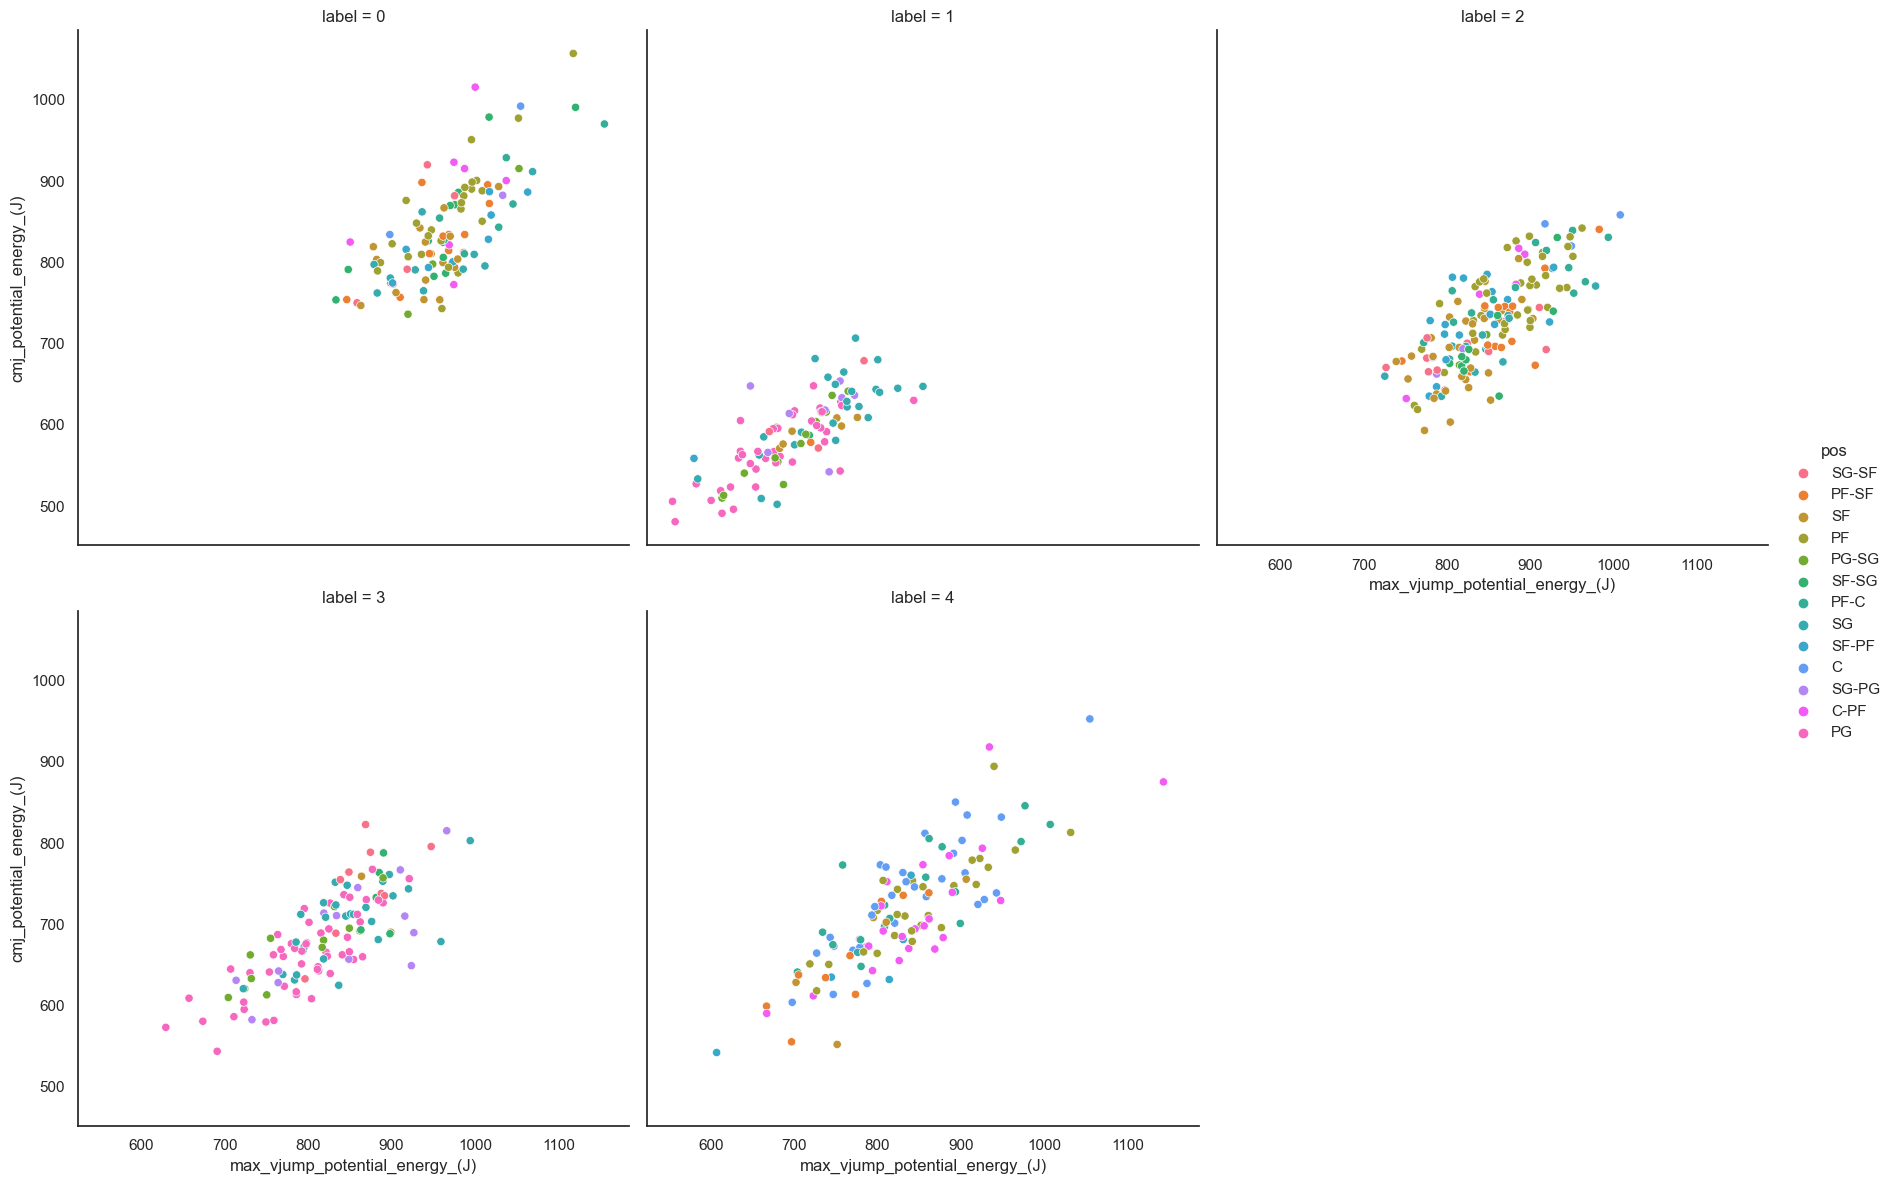

In [2507]:
cluster_max_vjump_cmj_pe_relplot = sns.relplot(
    data=labeled_df,
    x='max_vjump_potential_energy_(J)',
    y='cmj_potential_energy_(J)',
    col='label',
    hue='pos',
    kind='scatter',
    col_wrap=3,
    height = 6,
    )


## Gaussian Mixture Modeling

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/chrisizenour/opt/anaconda3/envs/msu_petway/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/Users/chrisizenour/opt/anaconda3/envs/msu_petway/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/Users/chrisizenour/opt/anaconda3/envs/msu_petway/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/Users/chrisizenour/opt/anaconda3/envs/msu_petway/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 t

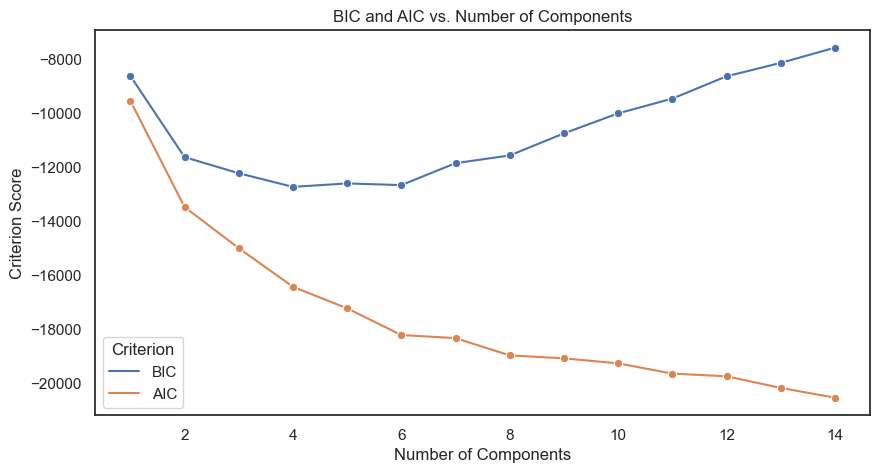

In [2508]:
gmm_bic_aic_plot = plot_gmm_criteria(clustering_df, 14)
gmm_bic_aic_plot.savefig(f'{project_data_exports_path}/gmm_bic_aic_plot.png', dpi=300,  bbox_inches='tight', pad_inches=0.5)

In [2509]:
pca_gmm_cluster_df, gmm_centroids_x, gmm_centroids_y = pca_gmm_df(clustering_df, 2, 5)
pca_gmm_cluster_df

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


pc_1      pc_2 label  cluster_0_probability  cluster_1_probability  \
0   -3.916383 -1.123224     0               0.574290               0.000396   
1    5.243532  3.018949     1               0.000042               0.989990   
2   -4.023721  1.472709     0               0.950728               0.000271   
3   -2.155939  2.625259     3               0.473669               0.002716   
4   -1.470632  1.315256     0               0.554986               0.009683   
..        ...       ...   ...                    ...                    ...   
604 -0.702608  3.325390     3               0.103448               0.008672   
605  0.060537 -1.146058     4               0.053640               0.032967   
606  4.539285  0.180943     1               0.000152               0.781130   
607 -0.094274  2.981117     3               0.099791               0.023557   
608 -2.487654 -1.878385     2               0.147873               0.001507   

     cluster_2_probability  cluster_3_probability  cluster_4_probability  
0                 0.408398               0.008827               0.008089  
1                 0.000001               0.000830               0.009137  
2                 0.008021               0.040157               0.000824  
3                 0.001127               0.519046               0.003442  
4                 0.015899               0.367050               0.052382  
..                     ...                    ...                    ...  
604               0.000126               0.883741               0.004014  
605               0.271282               0.046067               0.596044  
606               0.000709               0.000504               0.217505  
607               0.000273               0.861279               0.015100  
608               0.785861               0.013467               0.051291  

[609 rows x 8 columns]

In [2510]:
print(gmm_centroids_x, gmm_centroids_y)

[-2.71579669  3.9098683  -1.26065462 -0.5843578   1.31995542] [ 0.76985351  0.45067897 -2.40914735  2.53633967 -0.64842736]


In [2511]:
gmm_labeled_df = merge_cluster_df(metric_clustering_df, pca_gmm_cluster_df)
gmm_labeled_df.to_csv(f'{project_data_exports_path}/gmm_labeled_df.csv')
gmm_labeled_df

player  year    pos  weight_(kg)  body_fat  max_bench_press  \
0         Jamario Moon  2001     SF    83.914520       5.3              0.0   
1        Daniel Horton  2006  PG-SG    89.811216       8.0             17.0   
2          Mike Conley  2007     PG    79.378600       4.2             13.0   
3       Rodney Stuckey  2007  SG-PG    93.893544       6.1             14.0   
4            Ron Lewis  2007     SG    87.996848       4.5             16.0   
..                 ...   ...    ...          ...       ...              ...   
604  LaMarcus Aldridge  2006   PF-C   106.140528       8.7              8.0   
605       Kyle Singler  2011     SF   103.418976      10.0             10.0   
606    Michael Dunigan  2011   PF-C   107.773459       8.0             10.0   
607       Keith Benson  2011   C-PF    98.429464       6.1             12.0   
608      Trevor Harvey  2003   C-PF   111.130040      10.5             11.0   

     height_w/o_shoes_(m)  standing_reach_(m)  wingspan_(m)  cmj_(m)  ...  \
0                 1.99390              2.6162       2.12090   0.8382  ...   
1                 1.84150              2.4511       2.00660   0.7620  ...   
2                 1.80340              2.4003       1.97485   0.9017  ...   
3                 1.92405              2.5527       2.01295   0.7747  ...   
4                 1.87960              2.5146       1.99390   0.8382  ...   
..                    ...                 ...           ...      ...  ...   
604               2.08280              2.7940       2.25425   0.6731  ...   
605               2.01930              2.6924       2.08534   0.5842  ...   
606               2.04470              2.7305       2.21615   0.7493  ...   
607               2.08280              2.7813       2.22885   0.8001  ...   
608               2.07010              2.7813       2.15900   0.7493  ...   

     standing_reach_height_w/o_shoes_ratio  wingspan_height_w/o_shoes_ratio  \
0                                 1.312102                         1.063694   
1                                 1.331034                         1.089655   
2                                 1.330986                         1.095070   
3                                 1.326733                         1.046205   
4                                 1.337838                         1.060811   
..                                     ...                              ...   
604                               1.341463                         1.082317   
605                               1.333333                         1.032704   
606                               1.335404                         1.083851   
607                               1.335366                         1.070122   
608                               1.343558                         1.042945   

         pc_1      pc_2  label  cluster_0_probability  cluster_1_probability  \
0   -3.916383 -1.123224      0               0.574290               0.000396   
1   -3.045421  0.447450      0               0.862053               0.001260   
2   -5.456882 -0.109511      0               0.933721               0.000048   
3   -2.316216 -0.219768      0               0.651672               0.003782   
4   -2.951175 -0.140423      0               0.772632               0.001552   
..        ...       ...    ...                    ...                    ...   
604  2.957203 -0.557153      4               0.001725               0.311893   
605  1.765210  1.637797      4               0.039604               0.326943   
606  1.020081 -2.096086      4               0.006095               0.044912   
607  0.767778 -1.649107      4               0.013582               0.044593   
608  2.096690 -1.663236      4               0.002426               0.123928   

     cluster_2_probability  cluster_3_probability  cluster_4_probability  
0                 0.408398               0.008827               0.008089  
1                 0.058521               0.065251               0.012915  
2      

In [2512]:
gmm_grouped_clusters_df = gmm_labeled_df.groupby(['label']).agg({
    'player': 'count',
    'weight_(kg)': 'mean',
    'body_fat': 'mean',
    # 'hand_width_(m)': 'mean',
    # 'hand_length_(m)': 'mean',
    'max_bench_press': 'mean',
    'height_w/o_shoes_(m)': 'mean',
    'standing_reach_(m)': 'mean',
    'wingspan_(m)': 'mean',
    'cmj_(m)': 'mean',
    'cmj_potential_energy_(J)': 'mean',
    'cmj_estimated_takeoff_velo_(m/s)': 'mean',
    'max_vjump_(m)': 'mean',
    'max_vjump_takeoff_velo_(m/s)': 'mean',
    'max_vjump_potential_energy_(J)': 'mean',
    'three_quarter_sprint_(s)': 'mean',
    'three_quarter_velo_(m/s)': 'mean',
    'three_quarter_mean_accel_(m/s2)': 'mean',
    'three_quarter_force_(N)': 'mean',
    'lane_agility_time_(s)': 'mean',
    'standing_reach_height_w/o_shoes_ratio': 'mean',
    'wingspan_height_w/o_shoes_ratio': 'mean',
})
gmm_grouped_clusters_df = gmm_grouped_clusters_df.reset_index()
# grouped_clusters_df = grouped_clusters_df.rename(columns={
#     'label': 'Cluster',
#     'testid': 'Count',
#     'takeoff_velocity': 'Takeoff Velocity (m/s)',
#     'system_weight': 'System Weight (N)',
#     'countermovement_depth': 'Countermovement Depth (m)',
#     'time_to_takeoff': 'Time to Takeoff (s)',
#     'unweighting_phase': 'Unweighting Phase (s)',
#     'braking_phase': 'Braking Phase (s)',
#     'peak_braking_power': 'Peak Braking Power (W)',
#     'force_at_min_displacement': 'Force At Min Displacement (N)',
#     'propulsive_phase': 'Propulsive Phase (s)',
#     'peak_propulsive_power': 'Peak Propulsive Power (W)',
# })
gmm_grouped_clusters_df.to_csv(f'{project_data_exports_path}/gmm_grouped_clusters_df.csv')
gmm_grouped_clusters_df

label  player  weight_(kg)   body_fat  max_bench_press  \
0     0     131    87.064734   6.032061         9.549618   
1     1      78   112.236107  11.277564         9.717949   
2     2     126   102.584151   7.171825        13.650794   
3     3      95    87.243408   7.274211         7.200000   
4     4     179   105.022006   8.741061        12.100559   

   height_w/o_shoes_(m)  standing_reach_(m)  wingspan_(m)   cmj_(m)  \
0              1.881345            2.501076      1.997245  0.785655   
1              2.065053            2.769658      2.191971  0.633209   
2              1.989959            2.640038      2.129669  0.825903   
3              1.907874            2.536658      2.004662  0.689356   
4              2.021961            2.700878      2.151387  0.721062   

   cmj_potential_energy_(J)  ...  max_vjump_(m)  max_vjump_takeoff_velo_(m/s)  \
0                669.751424  ...       0.947168                      4.308058   
1                695.802357  ...       0.734809                      3.794507   
2                829.461557  ...       0.951895                      4.319284   
3                589.118110  ...       0.827238                      4.026844   
4                741.753634  ...       0.840825                      4.059968   

   max_vjump_potential_energy_(J)  three_quarter_sprint_(s)  \
0                      807.361214                  3.179847   
1                      807.204530                  3.496795   
2                      955.081968                  3.205556   
3                      707.848538                  3.308947   
4                      864.773092                  3.335475   

   three_quarter_velo_(m/s)  three_quarter_mean_accel_(m/s2)  \
0                  7.194237                         4.531478   
1                  6.545085                         3.752244   
2                  7.136633                         4.459221   
3                  6.913954                         4.185451   
4                  6.859863                         4.120791   

   three_quarter_force_(N)  lane_agility_time_(s)  \
0               394.162363              11.028779   
1               420.369044              12.256538   
2               456.796301              11.252619   
3               364.797599              11.246632   
4               432.324108              11.615866   

   standing_reach_height_w/o_shoes_ratio  wingspan_height_w/o_shoes_ratio  
0                               1.329421                         1.061781  
1                               1.341408                         1.061712  
2                               1.326813                         1.070432  
3                               1.329809                         1.051098  
4                               1.336022                         1.064276  

[5 rows x 21 columns]

In [2531]:
gmm_label_pos_count_df = gmm_labeled_df.groupby(['label', 'pos']).agg({'player': 'count'})
gmm_label_pos_count_df.to_csv(f'{project_data_exports_path}/gmm_label_pos_count_df.csv')
gmm_label_pos_count_df

player
label pos          
0     PG         53
      PG-SG      15
      SF          5
      SF-SG       7
      SG         32
      SG-PG      15
      SG-SF       4
1     C          22
      C-PF       16
      PF         15
      PF-C       10
      PF-SF       6
      SF          4
      SF-PF       3
      SG          2
2     C           2
      C-PF        7
      PF         27
      PF-C        8
      PF-SF      10
      PG          1
      PG-SG       3
      SF         17
      SF-PF       7
      SF-SG      12
      SG         16
      SG-PG       2
      SG-SF      14
3     PF          2
      PF-SF       1
      PG         34
      PG-SG      10
      SF         11
      SF-PF       1
      SF-SG       2
      SG         22
      SG-PG       8
      SG-SF       4
4     C          11
      C-PF       14
      PF         49
      PF-C       21
      PF-SF      19
      PG-SG       2
      SF         24
      SF-PF      20
      SF-SG       6
      SG          4
      SG-PG       1
      SG-SF       8

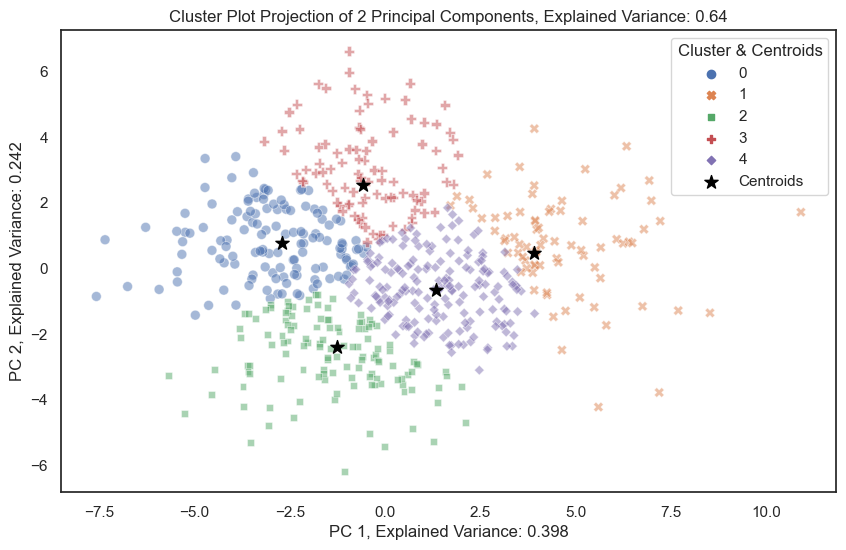

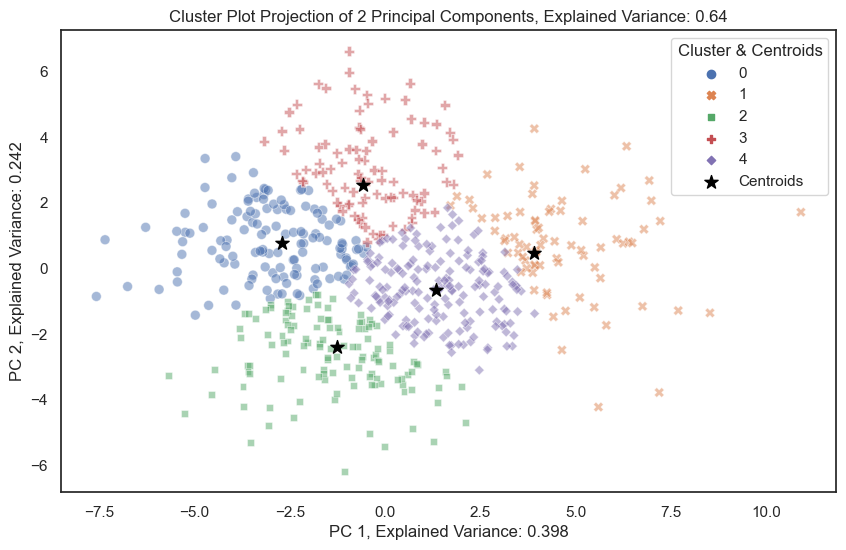

In [2513]:
pc12_gmm_cluster_plot(gmm_labeled_df, pca_exp_var_df, gmm_centroids_x, gmm_centroids_y)

# Explore GMM Clusters

In [2514]:
gmm_labeled_df

player  year    pos  weight_(kg)  body_fat  max_bench_press  \
0         Jamario Moon  2001     SF    83.914520       5.3              0.0   
1        Daniel Horton  2006  PG-SG    89.811216       8.0             17.0   
2          Mike Conley  2007     PG    79.378600       4.2             13.0   
3       Rodney Stuckey  2007  SG-PG    93.893544       6.1             14.0   
4            Ron Lewis  2007     SG    87.996848       4.5             16.0   
..                 ...   ...    ...          ...       ...              ...   
604  LaMarcus Aldridge  2006   PF-C   106.140528       8.7              8.0   
605       Kyle Singler  2011     SF   103.418976      10.0             10.0   
606    Michael Dunigan  2011   PF-C   107.773459       8.0             10.0   
607       Keith Benson  2011   C-PF    98.429464       6.1             12.0   
608      Trevor Harvey  2003   C-PF   111.130040      10.5             11.0   

     height_w/o_shoes_(m)  standing_reach_(m)  wingspan_(m)  cmj_(m)  ...  \
0                 1.99390              2.6162       2.12090   0.8382  ...   
1                 1.84150              2.4511       2.00660   0.7620  ...   
2                 1.80340              2.4003       1.97485   0.9017  ...   
3                 1.92405              2.5527       2.01295   0.7747  ...   
4                 1.87960              2.5146       1.99390   0.8382  ...   
..                    ...                 ...           ...      ...  ...   
604               2.08280              2.7940       2.25425   0.6731  ...   
605               2.01930              2.6924       2.08534   0.5842  ...   
606               2.04470              2.7305       2.21615   0.7493  ...   
607               2.08280              2.7813       2.22885   0.8001  ...   
608               2.07010              2.7813       2.15900   0.7493  ...   

     standing_reach_height_w/o_shoes_ratio  wingspan_height_w/o_shoes_ratio  \
0                                 1.312102                         1.063694   
1                                 1.331034                         1.089655   
2                                 1.330986                         1.095070   
3                                 1.326733                         1.046205   
4                                 1.337838                         1.060811   
..                                     ...                              ...   
604                               1.341463                         1.082317   
605                               1.333333                         1.032704   
606                               1.335404                         1.083851   
607                               1.335366                         1.070122   
608                               1.343558                         1.042945   

         pc_1      pc_2  label  cluster_0_probability  cluster_1_probability  \
0   -3.916383 -1.123224      0               0.574290               0.000396   
1   -3.045421  0.447450      0               0.862053               0.001260   
2   -5.456882 -0.109511      0               0.933721               0.000048   
3   -2.316216 -0.219768      0               0.651672               0.003782   
4   -2.951175 -0.140423      0               0.772632               0.001552   
..        ...       ...    ...                    ...                    ...   
604  2.957203 -0.557153      4               0.001725               0.311893   
605  1.765210  1.637797      4               0.039604               0.326943   
606  1.020081 -2.096086      4               0.006095               0.044912   
607  0.767778 -1.649107      4               0.013582               0.044593   
608  2.096690 -1.663236      4               0.002426               0.123928   

     cluster_2_probability  cluster_3_probability  cluster_4_probability  
0                 0.408398               0.008827               0.008089  
1                 0.058521               0.065251               0.012915  
2      

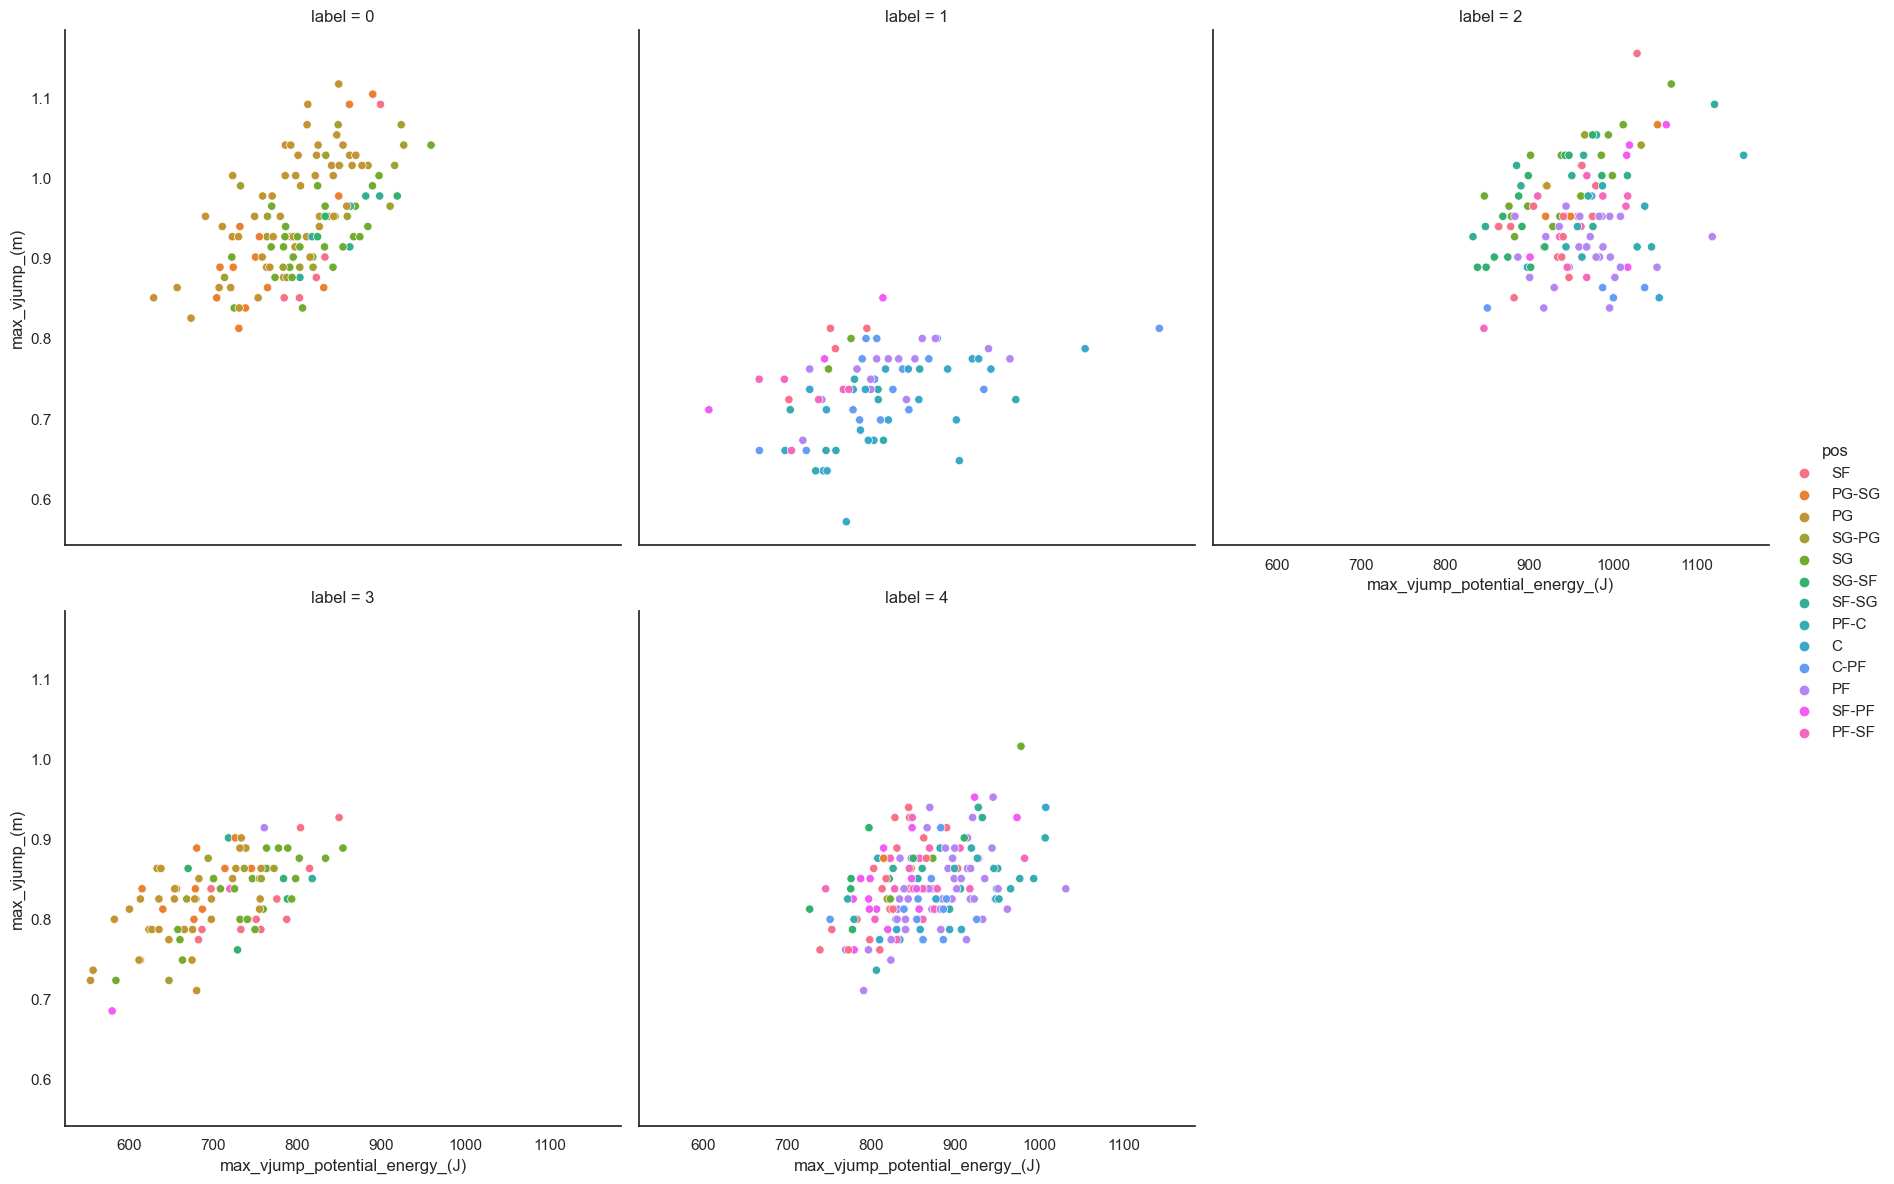

In [2544]:
sns.relplot(
    data=gmm_labeled_df,
    x='max_vjump_potential_energy_(J)',
    y='max_vjump_(m)',
    col='label',
    hue='pos',
    kind='scatter',
    col_wrap=3,
    height = 6,
)

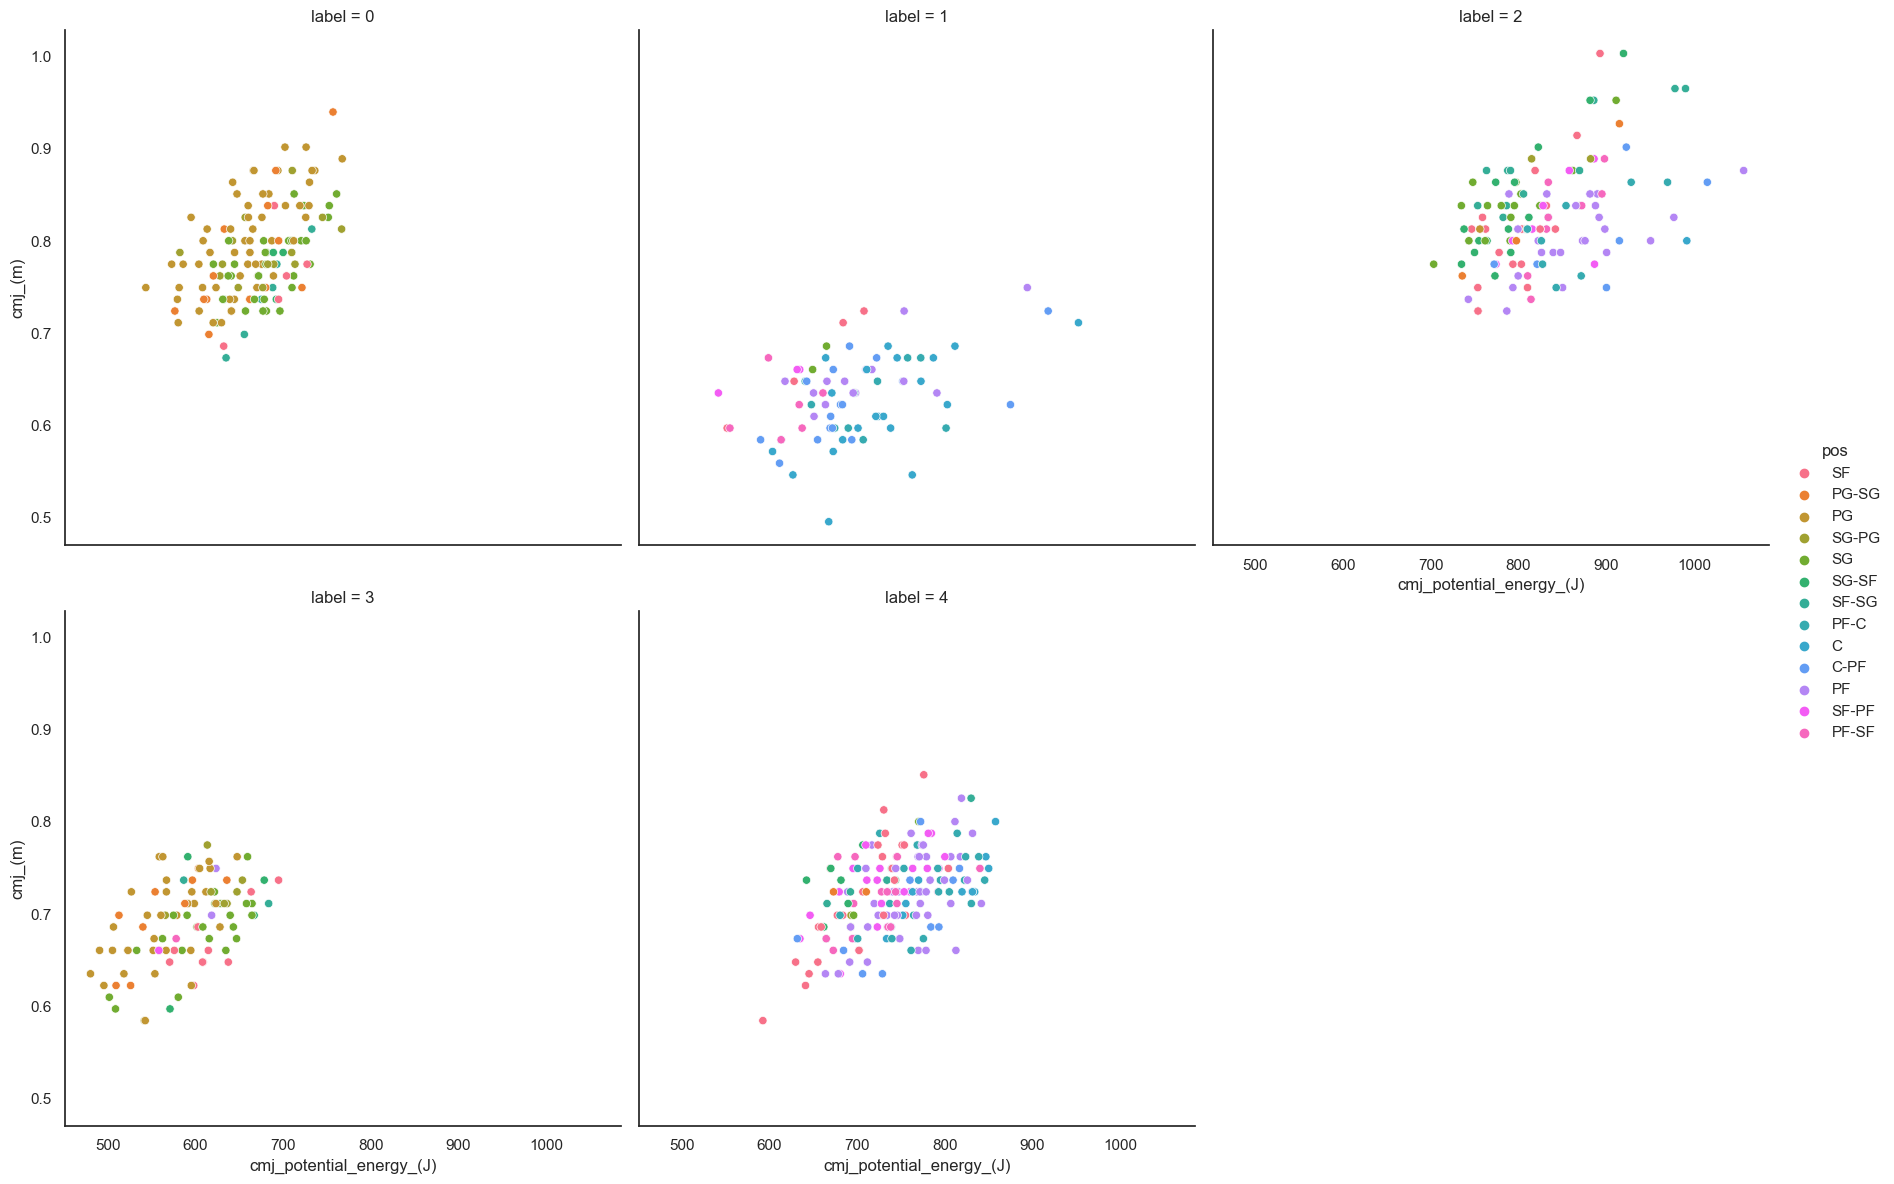

In [2545]:
sns.relplot(
    data=gmm_labeled_df,
    x='cmj_potential_energy_(J)',
    y='cmj_(m)',
    col='label',
    hue='pos',
    kind='scatter',
    col_wrap=3,
    height = 6,
)

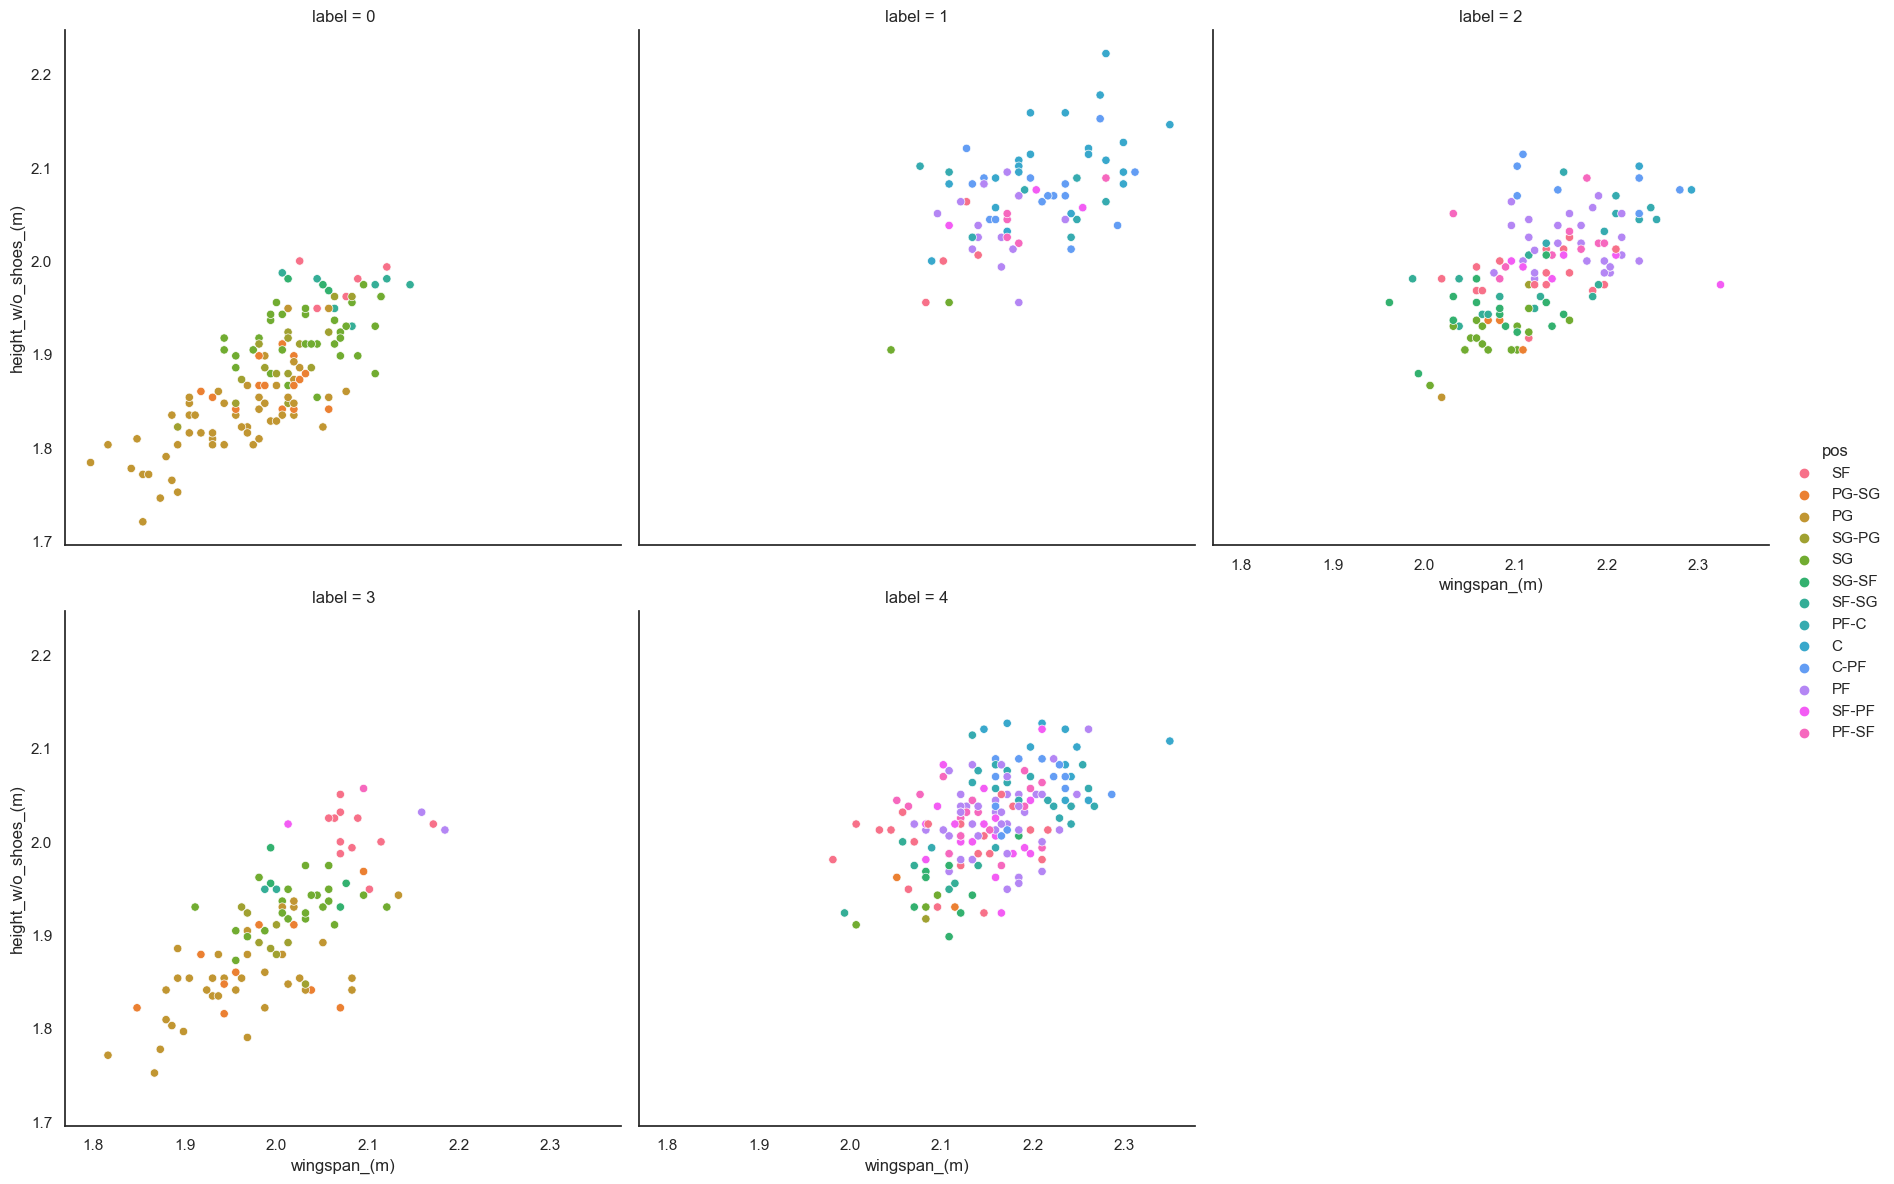

In [2546]:
sns.relplot(
    data=gmm_labeled_df,
    x='wingspan_(m)',
    y='height_w/o_shoes_(m)',
    col='label',
    hue='pos',
    kind='scatter',
    col_wrap=3,
    height = 6,
)

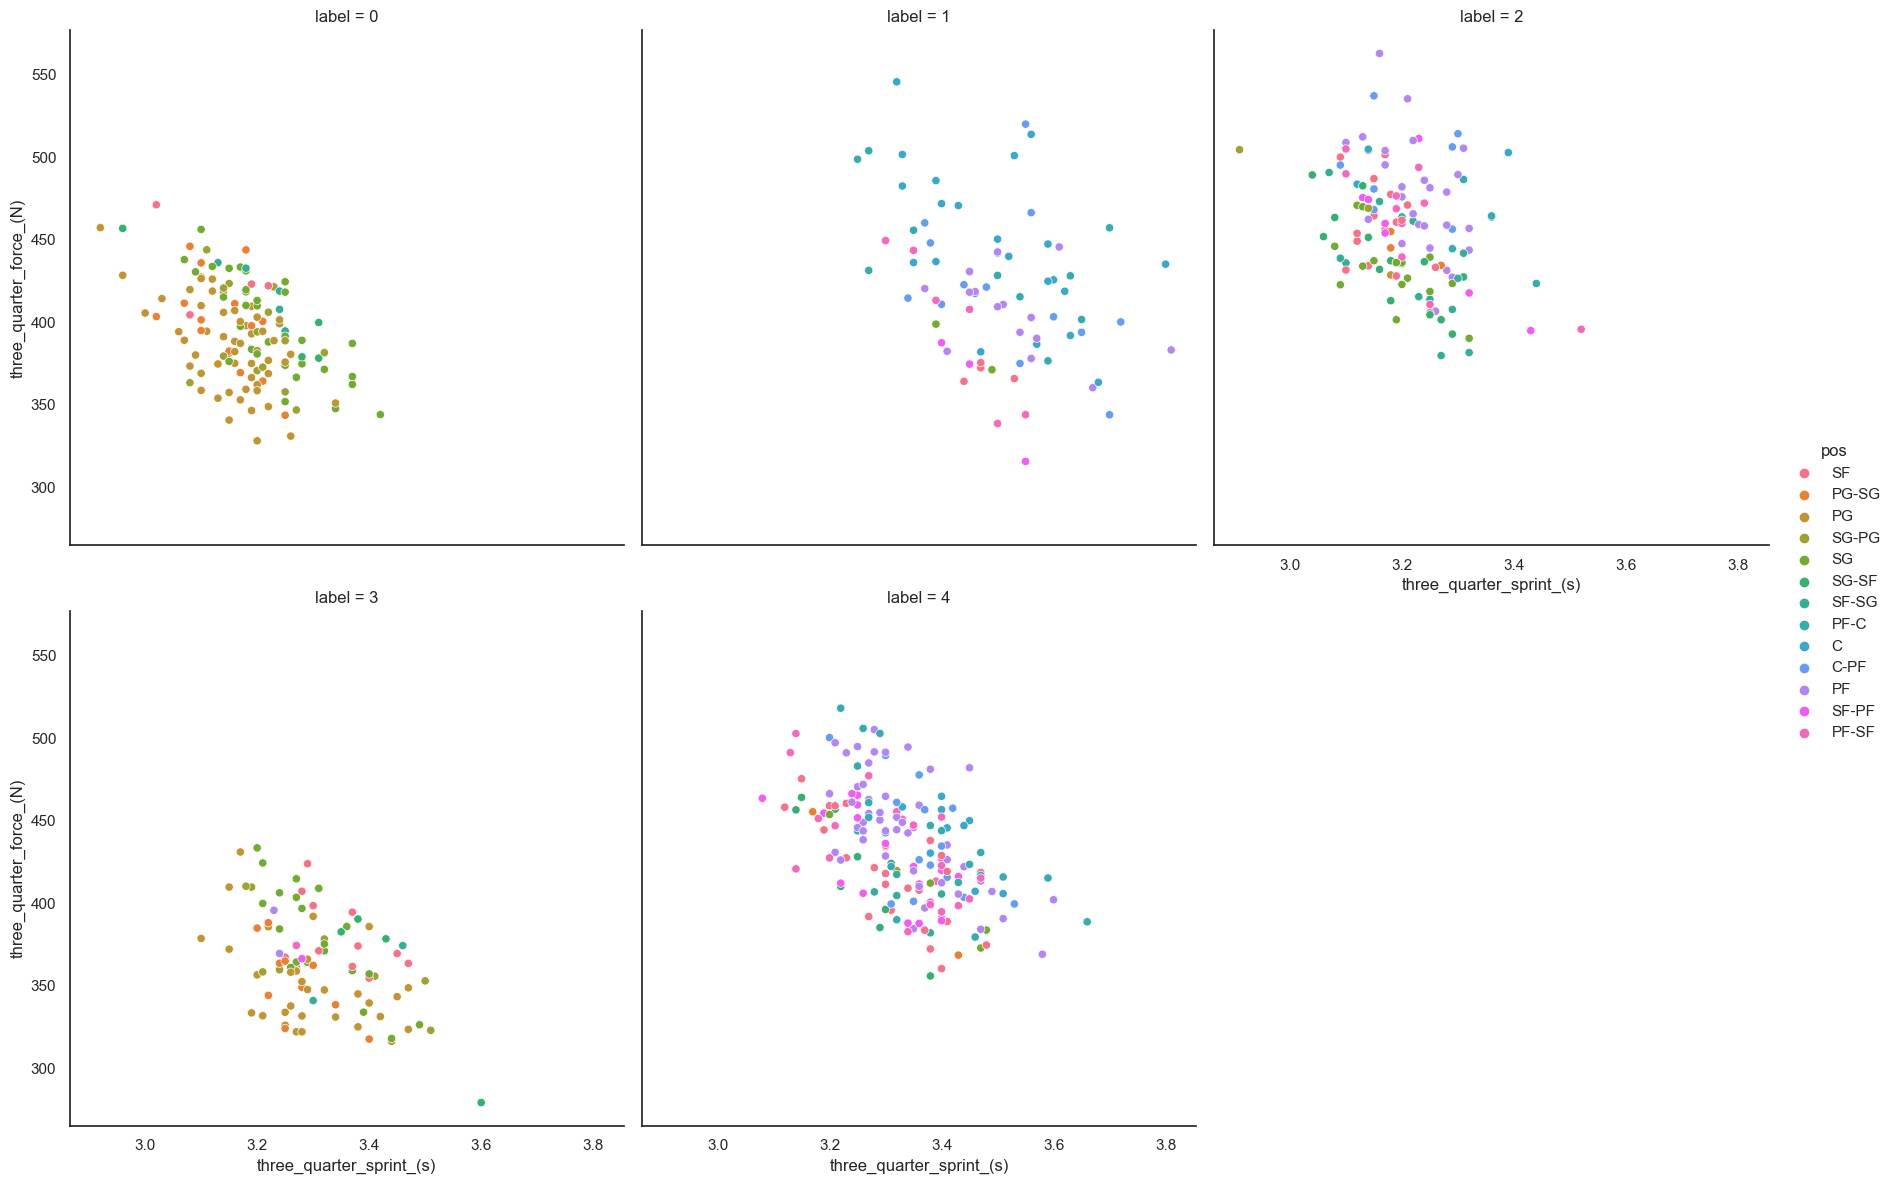

In [2548]:
sns.relplot(
    data=gmm_labeled_df,
    x='three_quarter_sprint_(s)',
    y='three_quarter_force_(N)',
    col='label',
    hue='pos',
    kind='scatter',
    col_wrap=3,
    height = 6,
)

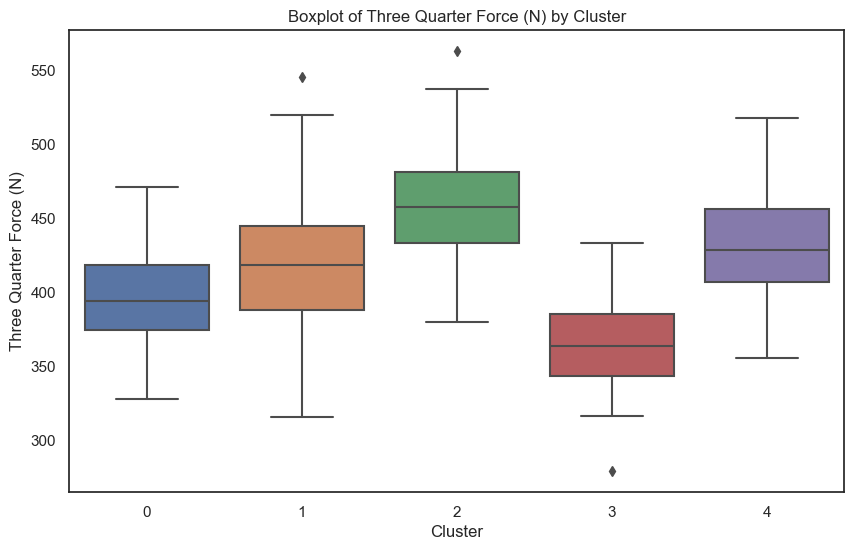

In [2553]:
cluster_three_quarter_force_box, ax = plt.subplots(1, 1, figsize=(10, 6), facecolor='white')

sns.boxplot(
    data=gmm_labeled_df,
    x='label',
    y='three_quarter_force_(N)',
    ax=ax
)
ax.set_title('Boxplot of Three Quarter Force (N) by Cluster')
ax.set_ylabel('Three Quarter Force (N)')
ax.set_xlabel('Cluster')
cluster_three_quarter_force_box.savefig(f'{project_data_exports_path}/cluster_three_quarter_force_box.png', dpi=300, bbox_inches='tight', pad_inches=0.5)

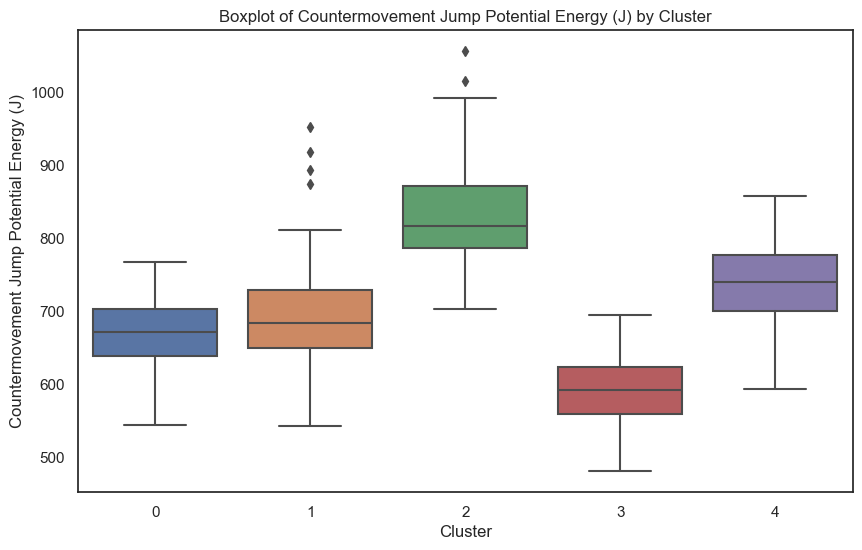

In [2554]:
cluster_cmj_potential_energy_box, ax = plt.subplots(1, 1, figsize=(10, 6), facecolor='white')

sns.boxplot(
    data=gmm_labeled_df,
    x='label',
    y='cmj_potential_energy_(J)',
    ax=ax
)
ax.set_title('Boxplot of Countermovement Jump Potential Energy (J) by Cluster')
ax.set_ylabel('Countermovement Jump Potential Energy (J)')
ax.set_xlabel('Cluster')
cluster_cmj_potential_energy_box.savefig(f'{project_data_exports_path}/cluster_cmj_potential_energy_box.png', dpi=300, bbox_inches='tight', pad_inches=0.5)

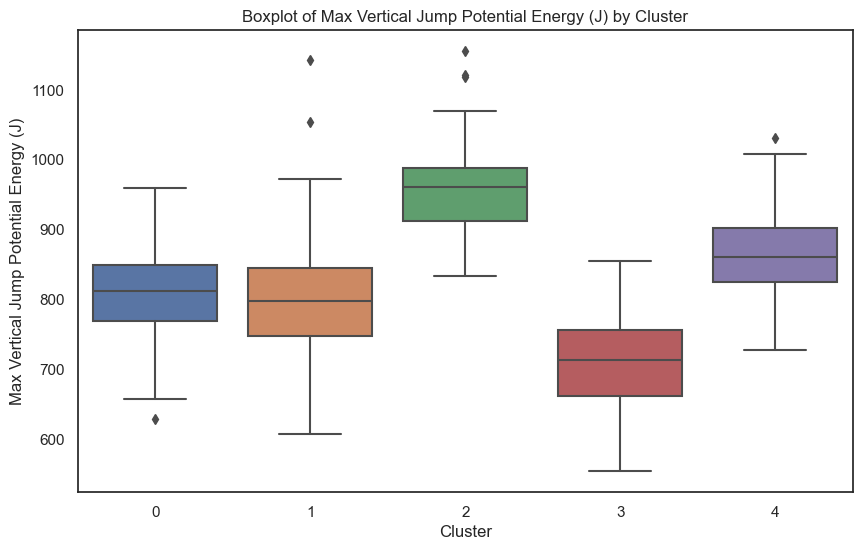

In [2555]:
cluster_max_vjump_potential_energy_box, ax = plt.subplots(1, 1, figsize=(10, 6), facecolor='white')

sns.boxplot(
    data=gmm_labeled_df,
    x='label',
    y='max_vjump_potential_energy_(J)',
    ax=ax
)
ax.set_title('Boxplot of Max Vertical Jump Potential Energy (J) by Cluster')
ax.set_ylabel('Max Vertical Jump Potential Energy (J)')
ax.set_xlabel('Cluster')
cluster_max_vjump_potential_energy_box.savefig(f'{project_data_exports_path}/cluster_max_vjump_potential_energy_box.png', dpi=300, bbox_inches='tight', pad_inches=0.5)

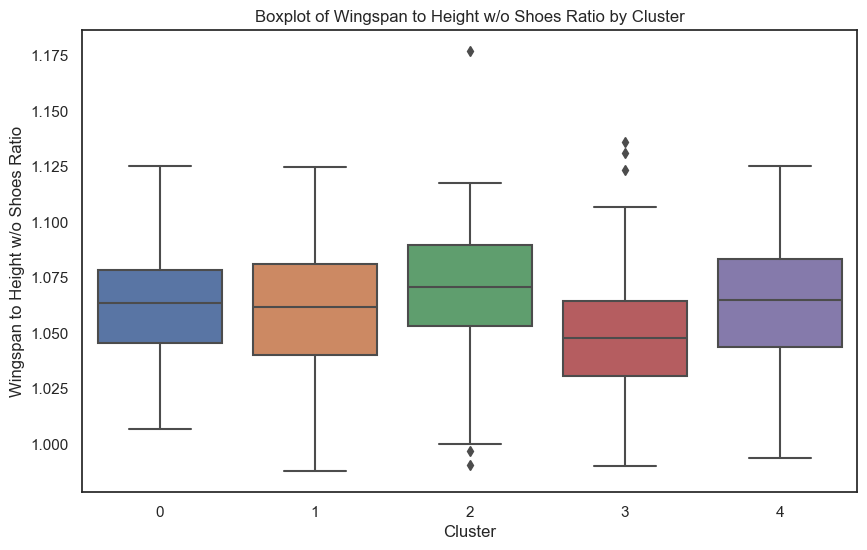

In [2556]:
cluster_wingspan_height_ratio_box, ax = plt.subplots(1, 1, figsize=(10, 6), facecolor='white')

sns.boxplot(
    data=gmm_labeled_df,
    x='label',
    y='wingspan_height_w/o_shoes_ratio',
    ax=ax
)
ax.set_title('Boxplot of Wingspan to Height w/o Shoes Ratio by Cluster')
ax.set_ylabel('Wingspan to Height w/o Shoes Ratio')
ax.set_xlabel('Cluster')
cluster_wingspan_height_ratio_box.savefig(f'{project_data_exports_path}/cluster_wingspan_height_ratio_box.png', dpi=300, bbox_inches='tight', pad_inches=0.5)

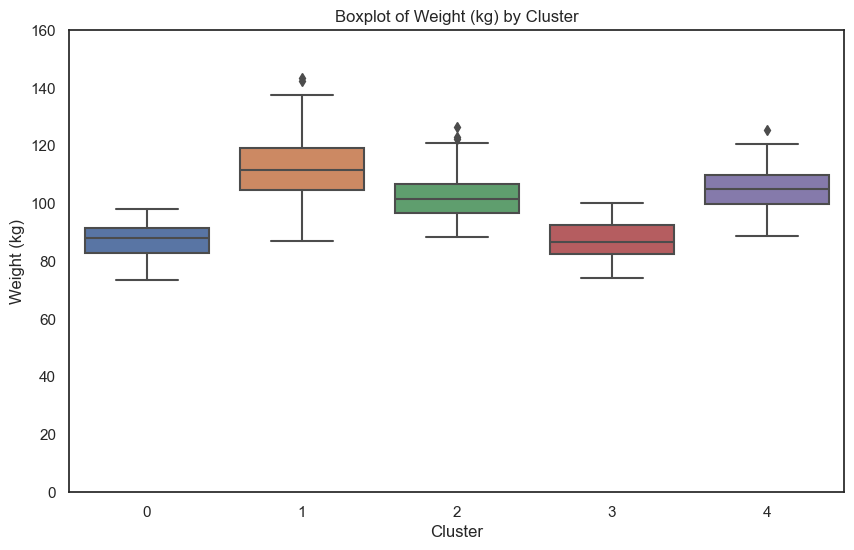

In [2558]:
cluster_weight_box, ax = plt.subplots(1, 1, figsize=(10, 6), facecolor='white')

ax.set_ylim(0, 160)

sns.boxplot(
    data=gmm_labeled_df,
    x='label',
    y='weight_(kg)',
    ax=ax
)
ax.set_title('Boxplot of Weight (kg) by Cluster')
ax.set_ylabel('Weight (kg)')
ax.set_xlabel('Cluster')
cluster_weight_box.savefig(f'{project_data_exports_path}/cluster_weight_box.png', dpi=300, bbox_inches='tight', pad_inches=0.5)

In [2515]:
gmm_top_performers_cluster_0 = gmm_labeled_df.loc[gmm_labeled_df['label'] == '0', :].sort_values(by='cluster_0_probability', ascending=False).reset_index(drop=True)
gmm_top_performers_cluster_0.to_csv(f'{project_data_exports_path}/gmm_top_performers_cluster_0.csv')
gmm_top_performers_cluster_0

player  year    pos  weight_(kg)  body_fat  max_bench_press  \
0        Keifer Sykes  2015     PG    75.840582       5.0              8.0   
1        Shane Larkin  2013     PG    77.473514       3.8             12.0   
2        Phil Pressey  2013     PG    80.285784       4.7              7.0   
3    SirValiant Brown  2001     PG    79.832192       6.7             10.0   
4       Jordan Farmar  2006     PG    77.564232       4.4             11.0   
..                ...   ...    ...          ...       ...              ...   
126      Keith Bogans  2003     SG    96.615096       8.0             10.0   
127    James Anderson  2010     SF    94.165699       7.9             14.0   
128   Bryant Matthews  2004  SF-SG    93.439952       6.7             13.0   
129       Tyler Smith  2009     SF    96.161504       7.0             10.0   
130      Luke Jackson  2004  SF-SG    96.161504       8.0             13.0   

     height_w/o_shoes_(m)  standing_reach_(m)  wingspan_(m)  cmj_(m)  ...  \
0                 1.79070              2.3622       1.87960   0.8636  ...   
1                 1.78435              2.2733       1.79705   0.8763  ...   
2                 1.76530              2.3368       1.88595   0.8382  ...   
3                 1.80340              2.3495       1.93040   0.7874  ...   
4                 1.84785              2.4003       1.90500   0.8509  ...   
..                    ...                 ...           ...      ...  ...   
126               1.93675              2.5654       2.06375   0.7493  ...   
127               1.94945              2.6416       2.04470   0.7620  ...   
128               1.97485              2.6797       2.14630   0.7366  ...   
129               1.96215              2.6543       2.07645   0.7366  ...   
130               1.98120              2.6162       2.04470   0.6731  ...   

     standing_reach_height_w/o_shoes_ratio  wingspan_height_w/o_shoes_ratio  \
0                                 1.319149                         1.049645   
1                                 1.274021                         1.007117   
2                                 1.323741                         1.068345   
3                                 1.302817                         1.070423   
4                                 1.298969                         1.030928   
..                                     ...                              ...   
126                               1.324590                         1.065574   
127                               1.355049                         1.048860   
128                               1.356913                         1.086817   
129                               1.352751                         1.058252   
130                               1.320513                         1.032051   

         pc_1      pc_2  label  cluster_0_probability  cluster_1_probability  \
0   -6.284748  1.247155      0               0.993099               0.000013   
1   -7.349331  0.868412      0               0.992198               0.000004   
2   -5.251522  1.673953      0               0.987654               0.000050   
3   -5.469256  1.125194      0               0.987062               0.000038   
4   -5.246574  1.095334      0               0.984391               0.000051   
..        ...       ...    ...                    ...                    ...   
126 -0.839440  0.127189      0               0.354235               0.023818   
127 -1.009766 -0.209422      0               0.341035               0.018860   
128 -1.075289 -0.333336      0               0.332240               0.017112   
129 -0.564143  0.452792      0               0.321735               0.032727   
130 -0.490913  0.645921      0               0.319148               0.035569   

     cluster_2_probability  cluster_3_probability  cluster_4_probability  
0                 0.005827               0.001048               0.000013  
1                 0.007685               0.000111               0.000002  
2                 

In [2516]:
gmm_top_performers_cluster_1 = gmm_labeled_df.loc[gmm_labeled_df['label'] == '1', :].sort_values(by='cluster_1_probability', ascending=False).reset_index(drop=True)
gmm_top_performers_cluster_1.to_csv(f'{project_data_exports_path}/gmm_top_performers_cluster_1.csv')
gmm_top_performers_cluster_1

player  year    pos  weight_(kg)  body_fat  max_bench_press  \
0        Pavel Podkolzin  2003      C   137.438376      16.3              5.0   
1          DeSagana Diop  2001      C   142.427888      21.0             15.0   
2   Lazaros Papadopoulos  2001   C-PF   102.965384      11.7              4.0   
3          Solomon Alabi  2010      C   107.682741       5.0             10.0   
4         Dakari Johnson  2015      C   120.020443      14.9              4.0   
..                   ...   ...    ...          ...       ...              ...   
73        Brandon Davies  2013     PF   109.678546       8.6              7.0   
74           Sammy Mejia  2007     SG    98.883056       8.3              7.0   
75         Rick Anderson  2003  SF-PF    97.975872       9.9              6.0   
76         Marcelus Kemp  2008     SG   100.243832       9.0              9.0   
77       Khris Middleton  2012     SF    98.066590       7.8              4.0   

    height_w/o_shoes_(m)  standing_reach_(m)  wingspan_(m)  cmj_(m)  ...  \
0                2.22250              2.9464       2.27965   0.4953  ...   
1                2.08280              2.8702       2.29870   0.5461  ...   
2                2.08915              2.8067       2.19710   0.5842  ...   
3                2.12090              2.8702       2.26060   0.5715  ...   
4                2.10820              2.8448       2.18440   0.5715  ...   
..                   ...                 ...           ...      ...  ...   
73               2.04470              2.7559       2.17170   0.6604  ...   
74               1.95580              2.6670       2.10820   0.6858  ...   
75               2.03835              2.7051       2.10820   0.6604  ...   
76               1.90500              2.6289       2.04470   0.6604  ...   
77               2.00025              2.6162       2.10185   0.7112  ...   

    standing_reach_height_w/o_shoes_ratio  wingspan_height_w/o_shoes_ratio  \
0                                1.325714                         1.025714   
1                                1.378049                         1.103659   
2                                1.343465                         1.051672   
3                                1.353293                         1.065868   
4                                1.349398                         1.036145   
..                                    ...                              ...   
73                               1.347826                         1.062112   
74                               1.363636                         1.077922   
75                               1.327103                         1.034268   
76                               1.380000                         1.073333   
77                               1.307937                         1.050794   

         pc_1      pc_2  label  cluster_0_probability  cluster_1_probability  \
0   10.900148  1.708973      1           8.953090e-12               0.999999   
1    8.515505 -1.359504      1           3.244980e-09               0.999116   
2    6.328919  3.716910      1           2.364223e-06               0.999090   
3    6.924076  2.673870      1           6.452476e-07               0.998758   
4    6.978681  2.060122      1           5.842410e-07               0.997857   
..        ...       ...    ...                    ...                    ...   
73   3.215779  0.466307      1           2.233162e-03               0.500224   
74   2.299883  1.828030      1           1.932538e-02               0.489693   
75   2.208322  2.084279      1           2.304132e-02               0.482908   
76   1.880385  2.192084      1           3.579774e-02               0.378474   
77   1.709720  1.912056      1           4.426398e-02               0.324652   

    cluster_2_probability  cluster_3_probability  cluster_4_probability  
0            9.514710e-11           5.424650e-13               0.000001  
1            5.156887e-06           1.211643e-09               0.000879  
2           

In [2517]:
gmm_top_performers_cluster_2 = gmm_labeled_df.loc[gmm_labeled_df['label'] == '2', :].sort_values(by='cluster_2_probability', ascending=False).reset_index(drop=True)
gmm_top_performers_cluster_2.to_csv(f'{project_data_exports_path}/gmm_top_performers_cluster_2.csv')
gmm_top_performers_cluster_2

player  year    pos  weight_(kg)  body_fat  max_bench_press  \
0      Justin Anderson  2015  SF-SG   104.598315       5.0             12.0   
1           Alton Ford  2001     PF   122.923432       8.0             21.0   
2      Harrison Barnes  2012  SF-SG   103.328258       9.6             15.0   
3           Doug Wrenn  2003  SF-PF    99.790240       7.3             15.0   
4        Iman Shumpert  2011  PG-SG   100.606706       6.5             18.0   
..                 ...   ...    ...          ...       ...              ...   
121     Malik Hairston  2008     SG    92.532768       6.9             13.0   
122   Gerald Henderson  2009  SG-SF    97.340843       4.4              8.0   
123      Morris Almond  2006  SG-SF    97.068688       6.9             13.0   
124   Maurice Harkless  2012     SF    93.712107       5.3              5.0   
125  Terrence Williams  2009  SG-SF    96.705814       5.1              9.0   

     height_w/o_shoes_(m)  standing_reach_(m)  wingspan_(m)  cmj_(m)  ...  \
0                 1.96215              2.5654       2.12725   0.9652  ...   
1                 2.03835              2.6035       2.09550   0.8763  ...   
2                 2.00660              2.5781       2.11455   0.9652  ...   
3                 1.97485              2.5527       2.32410   0.8763  ...   
4                 1.93675              2.5273       2.07010   0.9271  ...   
..                    ...                 ...           ...      ...  ...   
121               1.93675              2.6289       2.05740   0.7747  ...   
122               1.93040              2.6035       2.08915   0.8001  ...   
123               1.94945              2.6035       2.08280   0.7874  ...   
124               2.01295              2.6035       2.13360   0.8255  ...   
125               1.95580              2.6289       2.05740   0.7747  ...   

     standing_reach_height_w/o_shoes_ratio  wingspan_height_w/o_shoes_ratio  \
0                                 1.307443                         1.084142   
1                                 1.277259                         1.028037   
2                                 1.284810                         1.053797   
3                                 1.292605                         1.176849   
4                                 1.304918                         1.068852   
..                                     ...                              ...   
121                               1.357377                         1.062295   
122                               1.348684                         1.082237   
123                               1.335505                         1.068404   
124                               1.293375                         1.059937   
125                               1.344156                         1.051948   

         pc_1      pc_2  label  cluster_0_probability  cluster_1_probability  \
0   -3.523905 -5.299734      2               0.000564               0.000031   
1   -1.066676 -6.185987      2               0.000021               0.000239   
2   -3.061050 -4.781598      2               0.001150               0.000068   
3   -2.412745 -4.549393      2               0.001219               0.000159   
4   -3.711398 -4.222630      2               0.004752               0.000054   
..        ...       ...    ...                    ...                    ...   
121 -2.576416 -1.012470      2               0.435584               0.002316   
122 -2.002379 -0.959754      2               0.358245               0.004831   
123 -1.374156 -0.916261      2               0.258561               0.010112   
124 -1.778987 -0.809561      2               0.365131               0.006706   
125 -1.830337 -0.787006      2               0.382358               0.006363   

     cluster_2_probability  cluster_3_probability  cluster_4_probability  
0                 0.998841               0.000092               0.000473  
1                 0.997872               0.000148               0.001720  
2      

In [2518]:
gmm_top_performers_cluster_3 = gmm_labeled_df.loc[gmm_labeled_df['label'] == '3', :].sort_values(by='cluster_3_probability', ascending=False).reset_index(drop=True)
gmm_top_performers_cluster_3.to_csv(f'{project_data_exports_path}/gmm_top_performers_cluster_3.csv')
gmm_top_performers_cluster_3

player  year    pos  weight_(kg)  body_fat  max_bench_press  \
0      Omar Quintero  2004     PG    77.110640      14.1              2.0   
1      Ivan Koljevic  2004     PG    78.017824       6.7              4.0   
2     Gerry McNamara  2006  PG-SG    80.285784      12.8              3.0   
3       Tyler Harvey  2015     SG    82.281589       9.2              1.0   
4   Demetrius Porter  2001     PG    80.739376      12.4              5.0   
..               ...   ...    ...          ...       ...              ...   
90   Hollis Thompson  2012     SF    93.439952       6.0              6.0   
91    William Buford  2012  SG-SF    97.340843      11.3              8.0   
92           Yue Sun  2007     SF    96.161504       5.1              9.0   
93       Evan Turner  2010     SG    96.977970       8.6              9.0   
94     Wayne Wallace  2003     PF    84.821704       4.6              6.0   

    height_w/o_shoes_(m)  standing_reach_(m)  wingspan_(m)  cmj_(m)  ...  \
0                1.77165              2.3495       1.81610   0.6350  ...   
1                1.85420              2.4130       1.89230   0.6604  ...   
2                1.82245              2.3495       1.84785   0.6858  ...   
3                1.89865              2.5019       1.96850   0.6604  ...   
4                1.79705              2.3876       1.89865   0.6604  ...   
..                   ...                 ...           ...      ...  ...   
90               2.00025              2.6035       2.07010   0.7239  ...   
91               1.93040              2.5908       2.07010   0.6985  ...   
92               2.02565              2.6670       2.05740   0.7366  ...   
93               1.97485              2.6289       2.03200   0.6985  ...   
94               2.01295              2.7432       2.18440   0.7493  ...   

    standing_reach_height_w/o_shoes_ratio  wingspan_height_w/o_shoes_ratio  \
0                                1.326165                         1.025090   
1                                1.301370                         1.020548   
2                                1.289199                         1.013937   
3                                1.317726                         1.036789   
4                                1.328622                         1.056537   
..                                    ...                              ...   
90                               1.301587                         1.034921   
91                               1.342105                         1.072368   
92                               1.316614                         1.015674   
93                               1.331190                         1.028939   
94                               1.362776                         1.085174   

        pc_1      pc_2  label  cluster_0_probability  cluster_1_probability  \
0  -0.950373  6.612342      3               0.000627               0.000232   
1  -0.950223  5.971557      3               0.002240               0.000488   
2  -0.803443  5.471217      3               0.005042               0.000992   
3   0.651789  5.632513      3               0.001607               0.005347   
4  -0.486444  5.289552      3               0.005559               0.001720   
..       ...       ...    ...                    ...                    ...   
90 -0.053261  1.030626      3               0.238594               0.056339   
91  1.289056  1.709954      3               0.070815               0.219537   
92  0.507068  1.190416      3               0.147744               0.100223   
93 -0.192167  0.900637      3               0.263273               0.048806   
94 -0.479250  0.797810      3               0.324639               0.035892   

    cluster_2_probability  cluster_3_probability  cluster_4_probability  
0            3.351076e-09               0.999141           2.976365e-07  
1            3.290103e-08               0.997270           2.427713e-06  
2            1.714326e-07               0.993952           1.311044e

In [2519]:
gmm_top_performers_cluster_4 = gmm_labeled_df.loc[gmm_labeled_df['label'] == '4', :].sort_values(by='cluster_4_probability', ascending=False).reset_index(drop=True)
gmm_top_performers_cluster_4.to_csv(f'{project_data_exports_path}/gmm_top_performers_cluster_4.csv')
gmm_top_performers_cluster_4

player  year    pos  weight_(kg)  body_fat  max_bench_press  \
0      Tyson Chandler  2001  SF-PF   101.604608       6.7              2.0   
1       Bernard James  2012     PF   104.235442       5.0              6.0   
2         Jeff Adrien  2009     PF   107.138430       7.9             16.0   
3      Brandon Ashley  2015     PF   103.418976       8.8              9.0   
4            Pape Sow  2004   PF-C   105.686936       9.3             18.0   
..                ...   ...    ...          ...       ...              ...   
174      Damone Brown  2001     SF    91.625584       6.7              6.0   
175       James Ennis  2013     SF    91.081274       4.5              7.0   
176       Danny Green  2009  SG-SF    94.347136       5.6             15.0   
177  LaVell Blanchard  2003     SF    92.986360      11.7             12.0   
178     Robbie Hummel  2012     SF    98.883056       9.4             13.0   

     height_w/o_shoes_(m)  standing_reach_(m)  wingspan_(m)  cmj_(m)  ...  \
0                 2.12090              2.7940       2.20980   0.7874  ...   
1                 2.05105              2.7559       2.20980   0.7620  ...   
2                 1.96215              2.7305       2.18440   0.6985  ...   
3                 2.01295              2.6670       2.22885   0.8001  ...   
4                 2.04470              2.7559       2.18440   0.7112  ...   
..                    ...                 ...           ...      ...  ...   
174               2.03835              2.6543       2.12725   0.8128  ...   
175               1.97485              2.6543       2.12090   0.7493  ...   
176               1.96215              2.6162       2.08280   0.7366  ...   
177               1.98120              2.5781       1.98120   0.8509  ...   
178               2.01295              2.5908       2.04470   0.6985  ...   

     standing_reach_height_w/o_shoes_ratio  wingspan_height_w/o_shoes_ratio  \
0                                 1.317365                         1.041916   
1                                 1.343653                         1.077399   
2                                 1.391586                         1.113269   
3                                 1.324921                         1.107256   
4                                 1.347826                         1.068323   
..                                     ...                              ...   
174                               1.302181                         1.043614   
175                               1.344051                         1.073955   
176                               1.333333                         1.061489   
177                               1.301282                         1.000000   
178                               1.287066                         1.015773   

         pc_1      pc_2  label  cluster_0_probability  cluster_1_probability  \
0    1.572579 -0.927681      4               0.009564               0.106444   
1    1.751330 -0.689454      4               0.009152               0.131542   
2    1.746821 -0.671585      4               0.009350               0.132026   
3    1.654610 -1.114319      4               0.007250               0.105494   
4    1.949327 -1.032022      4               0.005183               0.133777   
..        ...       ...    ...                    ...                    ...   
174 -0.949163 -0.476033      4               0.273464               0.018703   
175 -0.074919  0.834806      4               0.235897               0.055146   
176 -0.142336  0.785955      4               0.247468               0.051394   
177 -0.825992 -0.049998      4               0.323020               0.023547   
178  1.633974  1.841468      4               0.048279               0.302634   

     cluster_2_probability  cluster_3_probability  cluster_4_probability  
0                 0.072395               0.018263               0.793334  
1                 0.048316               0.019157               0.791833  
2                 

## GMM Cluster Radar Chart

In [2520]:
gmm_anthro_features = [
    'weight_(kg)', 
    'body_fat', 
    # 'hand_width_(m)',
    # 'hand_length_(m)',
    'standing_reach_(m)', 
    'wingspan_(m)', 
    'height_w/o_shoes_(m)',
    'standing_reach_height_w/o_shoes_ratio',
    'wingspan_height_w/o_shoes_ratio',
]

gmm_cluster_anthro_means = gmm_labeled_df.groupby('label')[gmm_anthro_features].mean()

In [2521]:
gmm_non_anthro_features = [
    'max_bench_press',
    'cmj_(m)',
    'cmj_potential_energy_(J)',
    'cmj_estimated_takeoff_velo_(m/s)',
    'max_vjump_(m)',
    'max_vjump_takeoff_velo_(m/s)',
    'max_vjump_potential_energy_(J)',
    'three_quarter_sprint_(s)',
    'three_quarter_velo_(m/s)',
    'three_quarter_mean_accel_(m/s2)',
    'three_quarter_force_(N)',
    'lane_agility_time_(s)',
]
gmm_cluster_non_anthro_means = gmm_labeled_df.groupby('label')[gmm_non_anthro_features].mean()

In [2538]:
cluster_2_top_5 = ['Justin Anderson', 'Alton Ford', 'Harrison Barnes', 'Doug Wrenn', 'Iman Shumpert']
cluster_2_top_5_df = gmm_labeled_df.loc[gmm_labeled_df['player'].isin(cluster_2_top_5), :]
cluster_2_top_5_anthro_means = cluster_2_top_5_df.groupby('player')[gmm_anthro_features].mean()
cluster_2_top_5_anthro_means

weight_(kg)  body_fat  standing_reach_(m)  wingspan_(m)  \
player                                                                     
Alton Ford        122.923432       8.0              2.6035       2.09550   
Doug Wrenn         99.790240       7.3              2.5527       2.32410   
Harrison Barnes   103.328258       9.6              2.5781       2.11455   
Iman Shumpert     100.606706       6.5              2.5273       2.07010   
Justin Anderson   104.598315       5.0              2.5654       2.12725   

                 height_w/o_shoes_(m)  standing_reach_height_w/o_shoes_ratio  \
player                                                                         
Alton Ford                    2.03835                               1.277259   
Doug Wrenn                    1.97485                               1.292605   
Harrison Barnes               2.00660                               1.284810   
Iman Shumpert                 1.93675                               1.304918   
Justin Anderson               1.96215                               1.307443   

                 wingspan_height_w/o_shoes_ratio  
player                                            
Alton Ford                              1.028037  
Doug Wrenn                              1.176849  
Harrison Barnes                         1.053797  
Iman Shumpert                           1.068852  
Justin Anderson                         1.084142

In [2539]:
cluster_2_top_5 = ['Justin Anderson', 'Alton Ford', 'Harrison Barnes', 'Doug Wrenn', 'Iman Shumpert']
cluster_2_top_5_df = gmm_labeled_df.loc[gmm_labeled_df['player'].isin(cluster_2_top_5), :]
cluster_2_top_5_non_anthro_means = cluster_2_top_5_df.groupby('player')[gmm_non_anthro_features].mean()
cluster_2_top_5_non_anthro_means

max_bench_press  cmj_(m)  cmj_potential_energy_(J)  \
player                                                                
Alton Ford                  21.0   0.8763               1056.711652   
Doug Wrenn                  15.0   0.8763                857.847098   
Harrison Barnes             15.0   0.9652                978.375180   
Iman Shumpert               18.0   0.9271                915.002997   
Justin Anderson             12.0   0.9652                990.400862   

                 cmj_estimated_takeoff_velo_(m/s)  max_vjump_(m)  \
player                                                             
Alton Ford                               4.146445         0.9271   
Doug Wrenn                               4.146445         1.0414   
Harrison Barnes                          4.351692         1.0033   
Iman Shumpert                            4.264939         1.0668   
Justin Anderson                          4.351692         1.0922   

                 max_vjump_takeoff_velo_(m/s)  max_vjump_potential_energy_(J)  \
player                                                                          
Alton Ford                           4.264939                     1117.970298   
Doug Wrenn                           4.520207                     1019.470464   
Harrison Barnes                      4.436749                     1016.995253   
Iman Shumpert                        4.574999                     1052.880161   
Justin Anderson                      4.629143                     1120.716765   

                 three_quarter_sprint_(s)  three_quarter_velo_(m/s)  \
player                                                                
Alton Ford                           3.16                  7.234177   
Doug Wrenn                           3.17                  7.211356   
Harrison Barnes                      3.16                  7.234177   
Iman Shumpert                        3.18                  7.188679   
Justin Anderson                      3.22                  7.099379   

                 three_quarter_mean_accel_(m/s2)  three_quarter_force_(N)  \
player                                                                      
Alton Ford                              4.578593               562.816387   
Doug Wrenn                              4.549752               454.020815   
Harrison Barnes                         4.578593               473.098055   
Iman Shumpert                           4.521182               454.861218   
Justin Anderson                         4.409552               461.231721   

                 lane_agility_time_(s)  
player                                  
Alton Ford                       11.70  
Doug Wrenn                       11.38  
Harrison Barnes                  10.93  
Iman Shumpert                    11.10  
Justin Anderson                  11.13

### MinMax Normalized

In [2522]:
# Normalize the data for radar chart
minmax_scaler = MinMaxScaler()
gmm_cluster_anthro_minmax_scaled = minmax_scaler.fit_transform(gmm_cluster_anthro_means)
gmm_cluster_anthro_minmax_scaled_df = pd.DataFrame(gmm_cluster_anthro_minmax_scaled, columns=gmm_anthro_features, index=gmm_cluster_anthro_means.index)

# Prepare for plotting
gmm_anthro_num_vars = len(gmm_anthro_features)
gmm_anthro_angles = np.linspace(0, 2 * np.pi, gmm_anthro_num_vars, endpoint=False).tolist()  # Close the circle
gmm_cluster_anthro_minmax_scaled_df = pd.concat([gmm_cluster_anthro_minmax_scaled_df, gmm_cluster_anthro_minmax_scaled_df.iloc[:, 0]], axis=1)  # Repeat the first value at the end
gmm_anthro_angles += gmm_anthro_angles[:1]  # Repeat the first angle at the end

gmm_cluster_anthro_minmax_scaled_df.to_csv(f'{project_data_exports_path}/gmm_cluster_anthro_minmax_scaled_df.csv')
gmm_cluster_anthro_minmax_scaled_df

weight_(kg)  body_fat  standing_reach_(m)  wingspan_(m)  \
label                                                            
0         0.000000  0.000000            0.000000      0.000000   
1         1.000000  1.000000            1.000000      1.000000   
2         0.616550  0.217284            0.517390      0.680053   
3         0.007098  0.236803            0.132481      0.038089   
4         0.713401  0.516442            0.743915      0.791584   

       height_w/o_shoes_(m)  standing_reach_height_w/o_shoes_ratio  \
label                                                                
0                  0.000000                               0.178704   
1                  1.000000                               1.000000   
2                  0.591233                               0.000000   
3                  0.144410                               0.205328   
4                  0.765432                               0.630963   

       wingspan_height_w/o_shoes_ratio  weight_(kg)  
label                                                
0                             0.552563     0.000000  
1                             0.548967     1.000000  
2                             1.000000     0.616550  
3                             0.000000     0.007098  
4                             0.681570     0.713401

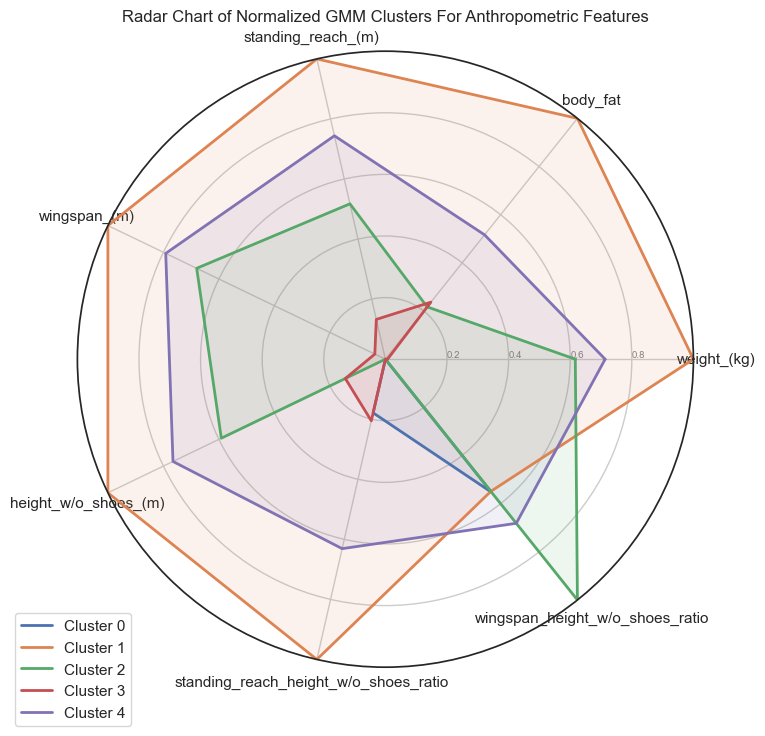

In [2523]:
# Create a figure
gmm_minmax_scaled_cluster_anthro_radar, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Draw one axe per variable and add labels
plt.xticks(gmm_anthro_angles[:-1], gmm_anthro_features)

# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([0.2, 0.4, 0.6, 0.8], ["0.2", "0.4", "0.6", "0.8"], color="grey", size=7)
plt.ylim(0, 1)

# Plot each cluster
for idx in gmm_cluster_anthro_minmax_scaled_df.index:
    values = gmm_cluster_anthro_minmax_scaled_df.loc[idx].tolist()
    ax.plot(gmm_anthro_angles, values, linewidth=2, linestyle='solid', label=f'Cluster {idx}')
    ax.fill(gmm_anthro_angles, values, alpha=0.1)

# Add a legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.title('Radar Chart of Normalized GMM Clusters For Anthropometric Features')
plt.savefig(f'{project_data_exports_path}/gmm_minmax_scaled_cluster_anthro_radar.png', dpi=300, bbox_inches='tight', pad_inches=0.5)

In [2524]:
minmax_scaler = MinMaxScaler()
gmm_cluster_non_anthro_minmax_scaled = minmax_scaler.fit_transform(gmm_cluster_non_anthro_means)
gmm_cluster_non_anthro_minmax_scaled_df = pd.DataFrame(gmm_cluster_non_anthro_minmax_scaled, columns=gmm_non_anthro_features, index=gmm_cluster_non_anthro_means.index)

# Prepare for plotting
gmm_non_anthro_num_vars = len(gmm_non_anthro_features)
gmm_non_anthro_angles = np.linspace(0, 2 * np.pi, gmm_non_anthro_num_vars, endpoint=False).tolist()  # Close the circle
gmm_cluster_non_anthro_minmax_scaled_df = pd.concat([gmm_cluster_non_anthro_minmax_scaled_df, gmm_cluster_non_anthro_minmax_scaled_df.iloc[:, 0]], axis=1)  # Repeat the first value at the end
gmm_non_anthro_angles += gmm_non_anthro_angles[:1]  # Repeat the first angle at the end

gmm_cluster_non_anthro_minmax_scaled_df.to_csv(f'{project_data_exports_path}/gmm_cluster_non_anthro_minmax_scaled_df.csv')
gmm_cluster_non_anthro_minmax_scaled_df

max_bench_press   cmj_(m)  cmj_potential_energy_(J)  \
label                                                        
0             0.364237  0.791129                  0.335492   
1             0.390332  0.000000                  0.443882   
2             1.000000  1.000000                  1.000000   
3             0.000000  0.291379                  0.000000   
4             0.759683  0.455919                  0.635073   

       cmj_estimated_takeoff_velo_(m/s)  max_vjump_(m)  \
label                                                    
0                              0.802039       0.978224   
1                              0.000000       0.000000   
2                              1.000000       1.000000   
3                              0.306061       0.425770   
4                              0.473397       0.488360   

       max_vjump_takeoff_velo_(m/s)  max_vjump_potential_energy_(J)  \
label                                                                 
0                          0.978608                        0.402505   
1                          0.000000                        0.401871   
2                          1.000000                        1.000000   
3                          0.442734                        0.000000   
4                          0.505856                        0.634722   

       three_quarter_sprint_(s)  three_quarter_velo_(m/s)  \
label                                                       
0                      0.000000                  1.000000   
1                      1.000000                  0.000000   
2                      0.081112                  0.911262   
3                      0.407323                  0.568232   
4                      0.491020                  0.484906   

       three_quarter_mean_accel_(m/s2)  three_quarter_force_(N)  \
label                                                             
0                             1.000000                 0.319187   
1                             0.000000                 0.604046   
2                             0.907272                 1.000000   
3                             0.555939                 0.000000   
4                             0.472960                 0.733994   

       lane_agility_time_(s)  max_bench_press  
label                                          
0                   0.000000         0.364237  
1                   1.000000         0.390332  
2                   0.182316         1.000000  
3                   0.177439         0.000000  
4                   0.478178         0.759683

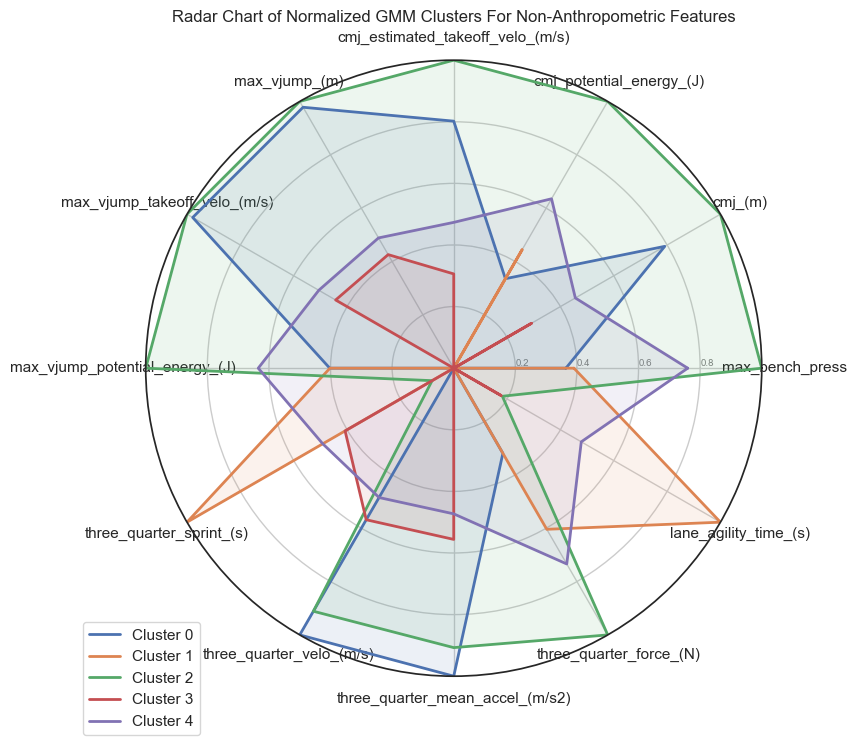

In [2525]:
# Create a figure
gmm_minmax_scaled_cluster_non_anthro_radar, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Draw one axe per variable and add labels
plt.xticks(gmm_non_anthro_angles[:-1], gmm_non_anthro_features)

# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([0.2, 0.4, 0.6, 0.8], ["0.2", "0.4", "0.6", "0.8"], color="grey", size=7)
plt.ylim(0, 1)

# Plot each cluster
for idx in gmm_cluster_non_anthro_minmax_scaled_df.index:
    values = gmm_cluster_non_anthro_minmax_scaled_df.loc[idx].tolist()
    ax.plot(gmm_non_anthro_angles, values, linewidth=2, linestyle='solid', label=f'Cluster {idx}')
    ax.fill(gmm_non_anthro_angles, values, alpha=0.1)

# Add a legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.title('Radar Chart of Normalized GMM Clusters For Non-Anthropometric Features')
plt.savefig(f'{project_data_exports_path}/gmm_minmax_scaled_cluster_non_anthro_radar.png', dpi=300, bbox_inches='tight', pad_inches=0.5)

In [2540]:
minmax_scaler = MinMaxScaler()
gmm_cluster_top_5_anthro_minmax_scaled = minmax_scaler.fit_transform(cluster_2_top_5_anthro_means)
gmm_cluster_top_5_anthro_minmax_scaled_df = pd.DataFrame(gmm_cluster_top_5_anthro_minmax_scaled, columns=gmm_anthro_features, index=cluster_2_top_5_anthro_means.index)

# Prepare for plotting
gmm_top_5_anthro_num_vars = len(gmm_anthro_features)
gmm_top_5_anthro_angles = np.linspace(0, 2 * np.pi, gmm_top_5_anthro_num_vars, endpoint=False).tolist()  # Close the circle
gmm_cluster_top_5_anthro_minmax_scaled_df = pd.concat([gmm_cluster_top_5_anthro_minmax_scaled_df, gmm_cluster_top_5_anthro_minmax_scaled_df.iloc[:, 0]], axis=1)  # Repeat the first value at the end
gmm_top_5_anthro_angles += gmm_top_5_anthro_angles[:1]  # Repeat the first angle at the end

gmm_cluster_top_5_anthro_minmax_scaled_df.to_csv(f'{project_data_exports_path}/gmm_cluster_top_5_anthro_minmax_scaled_df.csv')
gmm_cluster_top_5_anthro_minmax_scaled_df

weight_(kg)  body_fat  standing_reach_(m)  wingspan_(m)  \
player                                                                     
Alton Ford          1.000000  0.652174            1.000000         0.100   
Doug Wrenn          0.000000  0.500000            0.333333         1.000   
Harrison Barnes     0.152941  1.000000            0.666667         0.175   
Iman Shumpert       0.035294  0.326087            0.000000         0.000   
Justin Anderson     0.207843  0.000000            0.500000         0.225   

                 height_w/o_shoes_(m)  standing_reach_height_w/o_shoes_ratio  \
player                                                                         
Alton Ford                     1.0000                               0.000000   
Doug Wrenn                     0.3750                               0.508399   
Harrison Barnes                0.6875                               0.250178   
Iman Shumpert                  0.0000                               0.916338   
Justin Anderson                0.2500                               1.000000   

                 wingspan_height_w/o_shoes_ratio  weight_(kg)  
player                                                         
Alton Ford                              0.000000     1.000000  
Doug Wrenn                              1.000000     0.000000  
Harrison Barnes                         0.173105     0.152941  
Iman Shumpert                           0.274274     0.035294  
Justin Anderson                         0.377021     0.207843

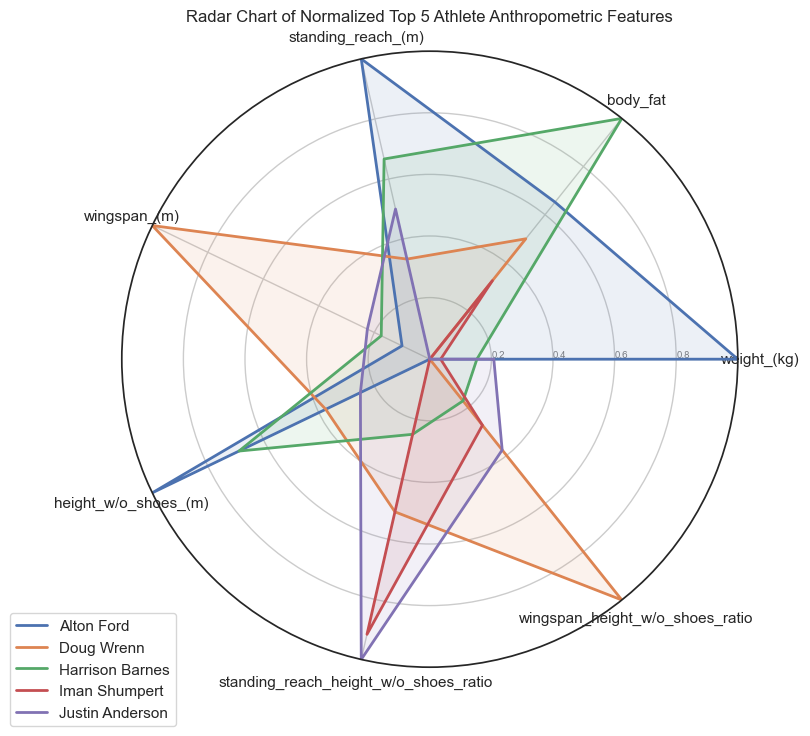

In [2541]:
# Create a figure
gmm_minmax_scaled_cluster_top_5_anthro_radar, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Draw one axe per variable and add labels
plt.xticks(gmm_top_5_anthro_angles[:-1], gmm_anthro_features)

# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([0.2, 0.4, 0.6, 0.8], ["0.2", "0.4", "0.6", "0.8"], color="grey", size=7)
plt.ylim(0, 1)

# Plot each cluster
for idx in gmm_cluster_top_5_anthro_minmax_scaled_df.index:
    values = gmm_cluster_top_5_anthro_minmax_scaled_df.loc[idx].tolist()
    ax.plot(gmm_top_5_anthro_angles, values, linewidth=2, linestyle='solid', label=f'{idx}')
    ax.fill(gmm_top_5_anthro_angles, values, alpha=0.1)

# Add a legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.title('Radar Chart of Normalized Top 5 Athlete Anthropometric Features')
plt.savefig(f'{project_data_exports_path}/gmm_minmax_scaled_cluster_top_5_anthro_radar.png', dpi=300, bbox_inches='tight', pad_inches=0.5)

In [2542]:
minmax_scaler = MinMaxScaler()
gmm_cluster_top_5_non_anthro_minmax_scaled = minmax_scaler.fit_transform(cluster_2_top_5_non_anthro_means)
gmm_cluster_top_5_non_anthro_minmax_scaled_df = pd.DataFrame(gmm_cluster_top_5_non_anthro_minmax_scaled, columns=gmm_non_anthro_features, index=cluster_2_top_5_non_anthro_means.index)

# Prepare for plotting
gmm_top_5_non_anthro_num_vars = len(gmm_non_anthro_features)
gmm_top_5_non_anthro_angles = np.linspace(0, 2 * np.pi, gmm_top_5_non_anthro_num_vars, endpoint=False).tolist()  # Close the circle
gmm_cluster_top_5_non_anthro_minmax_scaled_df = pd.concat([gmm_cluster_top_5_non_anthro_minmax_scaled_df, gmm_cluster_top_5_non_anthro_minmax_scaled_df.iloc[:, 0]], axis=1)  # Repeat the first value at the end
gmm_top_5_non_anthro_angles += gmm_top_5_non_anthro_angles[:1]  # Repeat the first angle at the end

gmm_cluster_top_5_non_anthro_minmax_scaled_df.to_csv(f'{project_data_exports_path}/gmm_cluster_top_5_non_anthro_minmax_scaled_df.csv')
gmm_cluster_top_5_non_anthro_minmax_scaled_df

max_bench_press   cmj_(m)  cmj_potential_energy_(J)  \
player                                                                 
Alton Ford              1.000000  0.000000                  1.000000   
Doug Wrenn              0.333333  0.000000                  0.000000   
Harrison Barnes         0.333333  1.000000                  0.606081   
Iman Shumpert           0.666667  0.571429                  0.287411   
Justin Anderson         0.000000  1.000000                  0.666553   

                 cmj_estimated_takeoff_velo_(m/s)  max_vjump_(m)  \
player                                                             
Alton Ford                               0.000000       0.000000   
Doug Wrenn                               0.000000       0.692308   
Harrison Barnes                          1.000000       0.461538   
Iman Shumpert                            0.577322       0.846154   
Justin Anderson                          1.000000       1.000000   

                 max_vjump_takeoff_velo_(m/s)  max_vjump_potential_energy_(J)  \
player                                                                          
Alton Ford                           0.000000                        0.973521   
Doug Wrenn                           0.700892                        0.023864   
Harrison Barnes                      0.471743                        0.000000   
Iman Shumpert                        0.851336                        0.345974   
Justin Anderson                      1.000000                        1.000000   

                 three_quarter_sprint_(s)  three_quarter_velo_(m/s)  \
player                                                                
Alton Ford                       0.000000                  1.000000   
Doug Wrenn                       0.166667                  0.830705   
Harrison Barnes                  0.000000                  1.000000   
Iman Shumpert                    0.333333                  0.662474   
Justin Anderson                  1.000000                  0.000000   

                 three_quarter_mean_accel_(m/s2)  three_quarter_force_(N)  \
player                                                                      
Alton Ford                              1.000000                 1.000000   
Doug Wrenn                              0.829382                 0.000000   
Harrison Barnes                         1.000000                 0.175349   
Iman Shumpert                           0.660371                 0.007725   
Justin Anderson                         0.000000                 0.066279   

                 lane_agility_time_(s)  max_bench_press  
player                                                   
Alton Ford                    1.000000         1.000000  
Doug Wrenn                    0.584416         0.333333  
Harrison Barnes               0.000000         0.333333  
Iman Shumpert                 0.220779         0.666667  
Justin Anderson               0.259740         0.000000

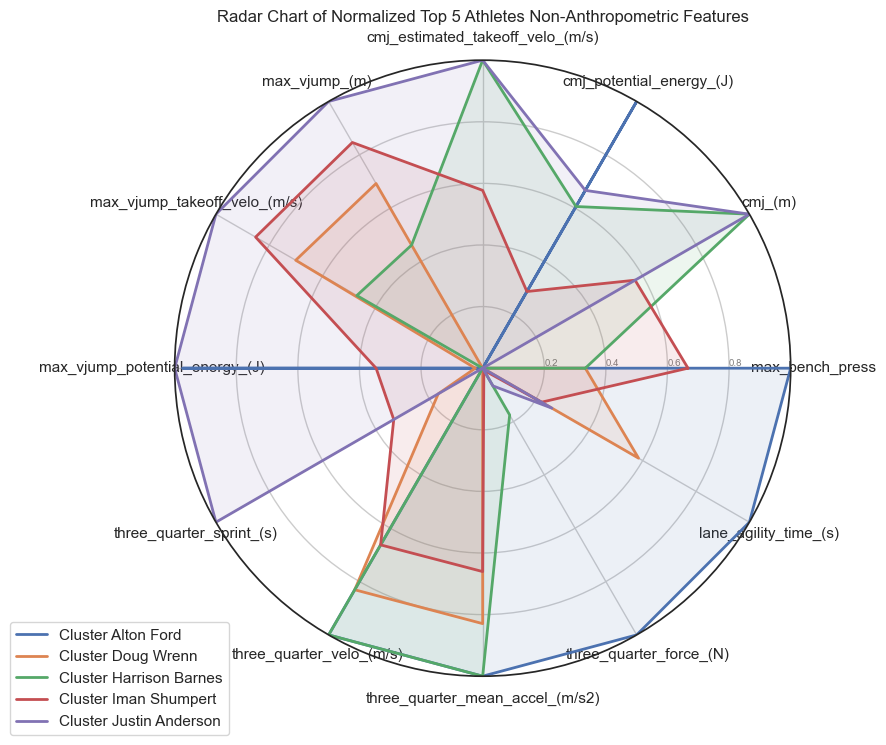

In [2543]:
# Create a figure
gmm_minmax_scaled_cluster_top_5_non_anthro_radar, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Draw one axe per variable and add labels
plt.xticks(gmm_top_5_non_anthro_angles[:-1], gmm_non_anthro_features)

# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([0.2, 0.4, 0.6, 0.8], ["0.2", "0.4", "0.6", "0.8"], color="grey", size=7)
plt.ylim(0, 1)

# Plot each cluster
for idx in gmm_cluster_top_5_non_anthro_minmax_scaled_df.index:
    values = gmm_cluster_top_5_non_anthro_minmax_scaled_df.loc[idx].tolist()
    ax.plot(gmm_top_5_non_anthro_angles, values, linewidth=2, linestyle='solid', label=f'Cluster {idx}')
    ax.fill(gmm_top_5_non_anthro_angles, values, alpha=0.1)

# Add a legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.title('Radar Chart of Normalized Top 5 Athletes Non-Anthropometric Features')
plt.savefig(f'{project_data_exports_path}/gmm_minmax_scaled_cluster_top_5_non_anthro_radar.png', dpi=300, bbox_inches='tight', pad_inches=0.5)

### Standard Scaler

In [2526]:
# Normalize the data for radar chart
std_scaler = StandardScaler()
gmm_cluster_anthro_std_scaled = std_scaler.fit_transform(gmm_cluster_anthro_means)
gmm_cluster_anthro_std_scaled_df = pd.DataFrame(gmm_cluster_anthro_std_scaled, columns=gmm_anthro_features, index=gmm_cluster_anthro_means.index)

# Prepare for plotting
gmm_anthro_num_vars = len(gmm_anthro_features)
gmm_anthro_angles = np.linspace(0, 2 * np.pi, gmm_anthro_num_vars, endpoint=False).tolist()  # Close the circle
gmm_cluster_anthro_std_scaled_df = pd.concat([gmm_cluster_anthro_std_scaled_df, gmm_cluster_anthro_std_scaled_df.iloc[:, 0]], axis=1)  # Repeat the first value at the end
gmm_anthro_angles += gmm_anthro_angles[:1]  # Repeat the first angle at the end

gmm_cluster_anthro_std_scaled_df.to_csv(f'{project_data_exports_path}/gmm_cluster_anthro_std_scaled_df.csv')
gmm_cluster_anthro_std_scaled_df

weight_(kg)  body_fat  standing_reach_(m)  wingspan_(m)  \
label                                                            
0        -1.170894 -1.143992           -1.286339     -1.231395   
1         1.334175  1.758760            1.400491      1.221851   
2         0.373607 -0.513270            0.103799      0.436943   
3        -1.153112 -0.456612           -0.930386     -1.137954   
4         0.616224  0.355113            0.712435      0.710556   

       height_w/o_shoes_(m)  standing_reach_height_w/o_shoes_ratio  \
label                                                                
0                 -1.331922                              -0.617273   
1                  1.330778                               1.642982   
2                  0.242354                              -1.109076   
3                 -0.947402                              -0.544003   
4                  0.706193                               0.627370   

       wingspan_height_w/o_shoes_ratio  weight_(kg)  
label                                                
0                            -0.012554    -1.170894  
1                            -0.023683     1.334175  
2                             1.372096     0.373607  
3                            -1.722533    -1.153112  
4                             0.386674     0.616224

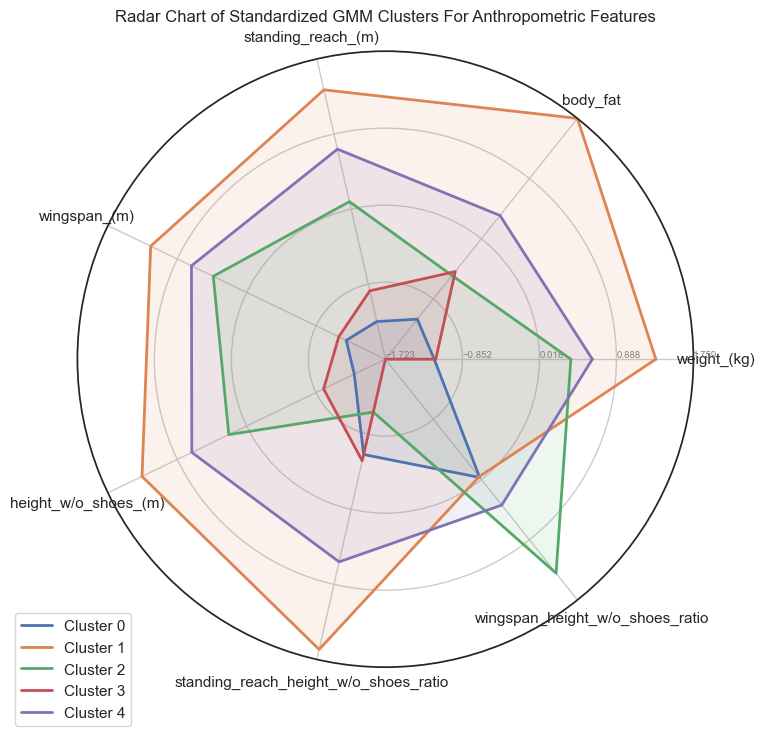

In [2527]:
anthro_min_val, anthro_max_val = gmm_cluster_anthro_std_scaled_df.min().min(), gmm_cluster_anthro_std_scaled_df.max().max()

# Create a figure
gmm_std_scaled_anthro_cluster_radar, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Draw one axe per variable and add labels
plt.xticks(gmm_anthro_angles[:-1], gmm_anthro_features)

# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks(np.linspace(anthro_min_val, anthro_max_val, 5), color="grey", size=7)
plt.ylim(anthro_min_val, anthro_max_val)

# Plot each cluster
for idx in gmm_cluster_anthro_std_scaled_df.index:
    values = gmm_cluster_anthro_std_scaled_df.loc[idx].tolist()
    ax.plot(gmm_anthro_angles, values, linewidth=2, linestyle='solid', label=f'Cluster {idx}')
    ax.fill(gmm_anthro_angles, values, alpha=0.1)

# Add a legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.title('Radar Chart of Standardized GMM Clusters For Anthropometric Features')
plt.savefig(f'{project_data_exports_path}/gmm_std_scaled_cluster_anthro_radar.png', dpi=300, bbox_inches='tight', pad_inches=0.5)

In [2528]:
# Normalize the data for radar chart
std_scaler = StandardScaler()
gmm_cluster_non_anthro_std_scaled = std_scaler.fit_transform(gmm_cluster_non_anthro_means)
gmm_cluster_non_anthro_std_scaled_df = pd.DataFrame(gmm_cluster_non_anthro_std_scaled, columns=gmm_non_anthro_features, index=gmm_cluster_non_anthro_means.index)

# Prepare for plotting
gmm_non_anthro_num_vars = len(gmm_non_anthro_features)
gmm_non_anthro_angles = np.linspace(0, 2 * np.pi, gmm_non_anthro_num_vars, endpoint=False).tolist()  # Close the circle
gmm_cluster_non_anthro_std_scaled_df = pd.concat([gmm_cluster_non_anthro_std_scaled_df, gmm_cluster_non_anthro_std_scaled_df.iloc[:, 0]], axis=1)  # Repeat the first value at the end
gmm_non_anthro_angles += gmm_non_anthro_angles[:1]  # Repeat the first angle at the end

gmm_cluster_non_anthro_std_scaled_df.to_csv(f'{project_data_exports_path}/gmm_cluster_non_anthro_std_scaled_df.csv')
gmm_cluster_non_anthro_std_scaled_df

max_bench_press   cmj_(m)  cmj_potential_energy_(J)  \
label                                                        
0            -0.400860  0.798558                 -0.445640   
1            -0.325396 -1.430325                 -0.117933   
2             1.437722  1.387020                  1.563427   
3            -1.454208 -0.609410                 -1.459963   
4             0.742742 -0.145843                  0.460109   

       cmj_estimated_takeoff_velo_(m/s)  max_vjump_(m)  \
label                                                    
0                              0.806119       1.065682   
1                             -1.456569      -1.542117   
2                              1.364602       1.123734   
3                             -0.593119      -0.407076   
4                             -0.121034      -0.240223   

       max_vjump_takeoff_velo_(m/s)  max_vjump_potential_energy_(J)  \
label                                                                 
0                          1.053893                       -0.260439   
1                         -1.569278                       -0.262374   
2                          1.111235                        1.563528   
3                         -0.382524                       -1.489163   
4                         -0.213326                        0.448448   

       three_quarter_sprint_(s)  three_quarter_velo_(m/s)  \
label                                                       
0                     -1.115347                  1.146124   
1                      1.701961                 -1.669077   
2                     -0.886829                  0.896309   
3                      0.032208                 -0.069389   
4                      0.268007                 -0.303968   

       three_quarter_mean_accel_(m/s2)  three_quarter_force_(N)  \
label                                                             
0                             1.161286                -0.616173   
1                            -1.652141                 0.210755   
2                             0.900404                 1.360184   
3                            -0.088047                -1.542752   
4                            -0.321502                 0.587986   

       lane_agility_time_(s)  max_bench_press  
label                                          
0                  -1.045751        -0.400860  
1                   1.799160        -0.325396  
2                  -0.527078         1.437722  
3                  -0.540952        -1.454208  
4                   0.314622         0.742742

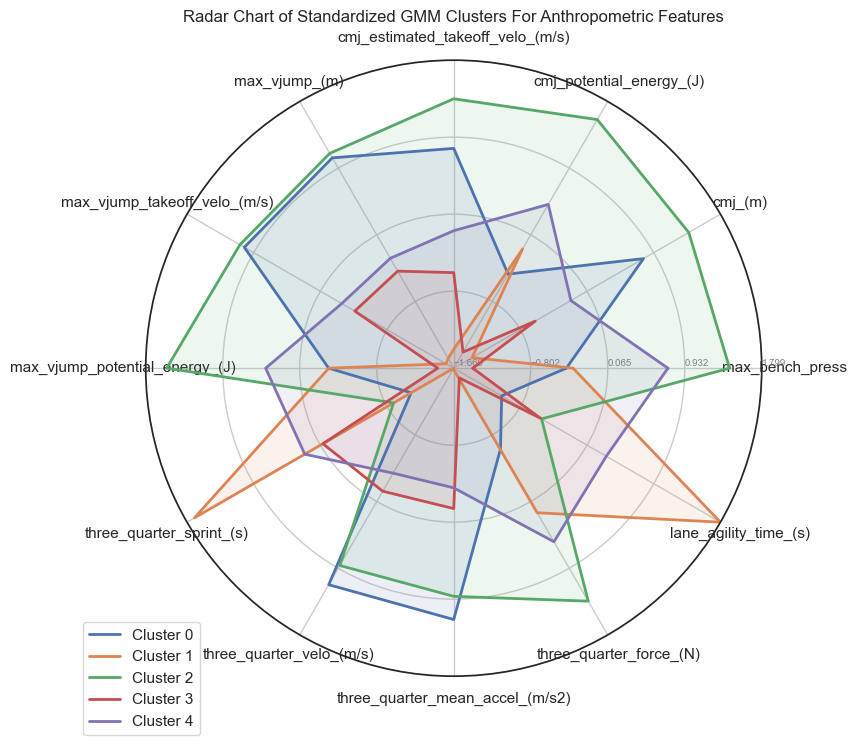

In [2529]:
non_anthro_min_val, non_anthro_max_val = gmm_cluster_non_anthro_std_scaled_df.min().min(), gmm_cluster_non_anthro_std_scaled_df.max().max()

# Create a figure
gmm_std_scaled_non_anthro_cluster_radar, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Draw one axe per variable and add labels
plt.xticks(gmm_non_anthro_angles[:-1], gmm_non_anthro_features)

# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks(np.linspace(non_anthro_min_val, non_anthro_max_val, 5), color="grey", size=7)
plt.ylim(non_anthro_min_val, non_anthro_max_val)

# Plot each cluster
for idx in gmm_cluster_non_anthro_std_scaled_df.index:
    values = gmm_cluster_non_anthro_std_scaled_df.loc[idx].tolist()
    ax.plot(gmm_non_anthro_angles, values, linewidth=2, linestyle='solid', label=f'Cluster {idx}')
    ax.fill(gmm_non_anthro_angles, values, alpha=0.1)

# Add a legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.title('Radar Chart of Standardized GMM Clusters For Anthropometric Features')
plt.savefig(f'{project_data_exports_path}/gmm_std_scaled_cluster_non_anthro_radar.png', dpi=300, bbox_inches='tight', pad_inches=0.5)